In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import plotly.express as px
import re

import unittest
import pytest

import spacy
nlp_model = spacy.load("en_core_web_md")
from sklearn.metrics.pairwise import cosine_similarity 

from rapidfuzz import fuzz, process

from statsmodels.tsa.seasonal import seasonal_decompose

# Introduction
---

Hi! This notebook is meant to be my own scratch book for cleaning and analysis of different datasets to generate insights about ASUC financial data. Throughout the notebook I go into granular detail on how I explored raw datasets, developed cleaning functions and visualized relationships. 

There's roughly four sections on the raw datasets themselves, cleaning the raw datasets, analyzing different cleaned datasets then a small section on Expected Cumilative Difference (ECD) which is a budgeting key performance indicator I developed. 

### Broad Research Questions

- What are the yearly spending / allocation trends of the ASUC Finance Committee across the years?
- What do the spending / allocation trends look like with respect to different types of RSOs (eg. performance groups, academic orgs, etc) look like across the years? 
- How do current Ficomm spending trends (FY25) compare to last year's Ficomm (FY24)?
- How do current Ficomm spending trends in terms of allocations made to different types of RSOs compare to last year?

### A Problems I Hope to Tackle: 

- Greater awareness of trends and distributions regarding where the ASUC's money is exactly going
- More efficient and equitable allocation of funds to make a stronger impact on clubs
- Increased transparency in terns of ASUC finances

# The Raw Datasets: Initial Probing
---

In this section I'll introduce the four we'll be using and cleaning them into a useable format. Each section will describe what a dataset is, what is was collected for and some initial information on the metadata of the dataset. 

### SU Finance PR Requests Raw Dataset
This dataset was acquired by my request from the SGPA (Student Governance and Program Advising, Berkeley's advising center for student government officials ran by professional staff advisors). It details changes made to the Contingency Fund processed by SU Finance (Student Union Finance, a team of professional staff that manage and process the actual financial transactions after students leaders in orgs make decisions about wanting to allocate funds to different places). This could be things like Purchase Requests or PR requests made to the Contingency Fund, which happens when clubs apply to and get approved for funding from the Contingency Fund by the ASUC Finance Committee. The ASUC Ficomm makes the decision and SU Finance processes the actual allocation through PR requests. This could also be things like positive injections of money into the fund, which usually happens when funds in the accounts of inactive or frozen clubs (termed Registered Student Organizations or RSOs, more on this later) gets cycled back into the ASUC. 

We will call this dataset `SUContRaw`. We're introducing it first because it's one of the more intuitively understandable and cleaner datasets even though the context behind it is a bit technical (referencing language like SGPA, purchase requests, SU Finance and RSOs). The data contains information from FY17 (2016-2017) to FY24 (2023-2024). 

Let's dig around to learn more about this dataset.

In [4]:
SUContRaw = pd.read_csv('ASUC Dataset CSVs/Complete Raw Contingency - Sheet1.csv')
SUContRaw.head(5)

,Account Name,Account Description,Transaction Reference #,Date,Reconciled,Created By,Payee/Source First Name,Payee/Source Last Name,Originator Account Name,From Request - Account Name,...,From Request - Payee City,From Request - Payee State,From Request - Payee ZIP,Memo,Category,Type,Transaction Method,Amount,Ending Balance After,Available Balance After
0,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1705233,8/17/2016,No,NaN,Reversal of Year End 15-16 Balance,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,NaN,NaN,Reversal of Year End 15-16 Balance,X-Adjustment (Admin use only),Direct Deposit ACH/Stripe,Payment,"$25,080.28",$0.00,$0.00
1,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1705287,8/17/2016,No,NaN,FY 16-17 Budget Allocation - Senate Contingenc...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,NaN,NaN,FY 16-17 Budget Allocation - Senate Contingenc...,X-Adjustment (Admin use only),Direct Deposit ACH/Stripe,Deposit,"$80,000.00",$0.00,"$80,000.00"
2,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1705571,8/24/2016,No,Robert Jittrikawiphol,Transfer from '3-40-203100-00000-ASUCFunds-UAV...,NaN,3-40-203100-00000-ASUCFunds-UAVA-B,NaN,...,NaN,NaN,NaN,"ESC grouped organization , returning funds bac...",X-Adjustment (Admin use only),NaN,Deposit,$400.00,$0.00,"$80,400.00"
3,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1707772,10/6/2016,No,VIRGIL TANG,Sheena,Paul,3-40-100220-00000-ASUCFunds-SCF,3-40-100220-00000-ASUCFunds-SCF,...,Oakland,CA,94609.0,VT 9/28/2016 CK#122570,Stipend,Check,Payment,$200.00,$0.00,"$80,200.00"
4,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1707841,10/6/2016,No,NaN,Robert Jittrikawiphol,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,NaN,NaN,"October 5, 2016 ASUC Senate Contingency Fund A...",Transfer between Accounts,Internal Allocation/Transaction/Transfer,Payment,"$4,020.00",$0.00,"$76,180.00"


In [5]:
#let's just check the shape first
SUContRaw_Initial_Shape = SUContRaw.shape
SUContRaw_Initial_Shape

(540, 26)

In [6]:
#what about column names?
SUContRaw_Initial_Columns = SUContRaw.columns
SUContRaw_Initial_Columns

Index(['Account Name', 'Account Description', 'Transaction Reference #',
       'Date', 'Reconciled', 'Created By', 'Payee/Source First Name',
       'Payee/Source Last Name', 'Originator Account Name',
       'From Request - Account Name', 'Request Number',
       'From Request - Subject', 'From Request - Payee First Name',
       'From Request - Payee Last Name', 'From Request - Payee Address1',
       'From Request - Payee Address2', 'From Request - Payee City',
       'From Request - Payee State', 'From Request - Payee ZIP', 'Memo',
       'Category', 'Type', 'Transaction Method', 'Amount',
       'Ending Balance After', 'Available Balance After'],
      dtype='object')

In [7]:
#what's the data type of the columns? 
col_types = {}
for col in SUContRaw.columns: 
    col_types[col] = SUContRaw[col].dtype
col_types 

{'Account Name': dtype('O'),
 'Account Description': dtype('O'),
 'Transaction Reference #': dtype('int64'),
 'Date': dtype('O'),
 'Reconciled': dtype('O'),
 'Created By': dtype('O'),
 'Payee/Source First Name': dtype('O'),
 'Payee/Source Last Name': dtype('O'),
 'Originator Account Name': dtype('O'),
 'From Request - Account Name': dtype('O'),
 'Request Number': dtype('float64'),
 'From Request - Subject': dtype('O'),
 'From Request - Payee First Name': dtype('O'),
 'From Request - Payee Last Name': dtype('O'),
 'From Request - Payee Address1': dtype('O'),
 'From Request - Payee Address2': dtype('O'),
 'From Request - Payee City': dtype('O'),
 'From Request - Payee State': dtype('O'),
 'From Request - Payee ZIP': dtype('float64'),
 'Memo': dtype('O'),
 'Category': dtype('O'),
 'Type': dtype('O'),
 'Transaction Method': dtype('O'),
 'Amount': dtype('O'),
 'Ending Balance After': dtype('O'),
 'Available Balance After': dtype('O')}

In [8]:
#Ooh a lot of "dtype('0')" for some reason, let's check an individual entry
SUCont_AccName_FirstVal = pd.Series(SUContRaw['Account Name']).loc[0]
(SUCont_AccName_FirstVal, type(SUCont_AccName_FirstVal))

('3-40-100220-00000-ASUCFunds-SCF', str)

In [9]:
#This individual entry is a string, makes sense given that the column is 'Account Name'
#Let's check a couple other columns with "dtype('0')" that we would expect to be strings, are all their entries strings too?
pd.Series([ type (i) for i in SUContRaw['Payee/Source Last Name']]).value_counts()

<class 'float'>    536
<class 'str'>        4
Name: count, dtype: int64

In [10]:
pd.Series([ type (i) for i in SUContRaw['Created By']]).value_counts()

<class 'str'>      497
<class 'float'>     43
Name: count, dtype: int64

In [11]:
pd.Series([ type (i) for i in SUContRaw['Account Name']]).value_counts()

<class 'str'>    540
Name: count, dtype: int64

In [12]:
#Hmm we have some variation, some columns have all string entries while others have some entries that are floats?
#Let's look at the entries that are supposedly floats and inspect their datatype further
SUContRaw[SUContRaw['Payee/Source Last Name'].apply(lambda x: isinstance(x, float))]['Payee/Source Last Name'].unique()

array([nan], dtype=object)

In [13]:
#Ah, it seems that the entries that are classfied as 'floats' are actually NaN values
SUContRaw[SUContRaw['Created By'].apply(lambda x: isinstance(x, float))]['Created By'].unique()

array([nan], dtype=object)

In [14]:
#Checking date column information, is the datatype of our dates string or datetime objects?
SUContRaw['Date']

0      8/17/2016
1      8/17/2016
2      8/24/2016
3      10/6/2016
4      10/6/2016
         ...    
535    4/23/2024
536    4/23/2024
537    4/28/2024
538    4/28/2024
539    4/28/2024
Name: Date, Length: 540, dtype: object

In [15]:
#All our date entries are indeed strings not datetime objects
SUContRaw['Date'].apply(lambda x: type(x)).value_counts()

Date
<class 'str'>    540
Name: count, dtype: int64

In [16]:
#Now let's look at the counts of different kinds of entries in different columns
SUContRaw['Payee/Source Last Name'].value_counts(dropna=False)

Payee/Source Last Name
NaN               536
Jittrikawiphol      2
Paul                1
JIttrikawiphol      1
Name: count, dtype: int64

In [17]:
SUContRaw['Created By'].value_counts(dropna=False)

Created By
Robert Jittrikawiphol    367
Henry F Isselbacher      128
NaN                       43
VIRGIL TANG                2
Name: count, dtype: int64

In [18]:

SUContRaw['Type'].value_counts(dropna=False)

Type
NaN                                         494
Internal Allocation/Transaction/Transfer     32
Direct Deposit ACH/Stripe                    12
Check                                         2
Name: count, dtype: int64

In [19]:
#Looks like we have a lot of NaN values in most columns
SUContRaw['Category'].value_counts(dropna=False)

Category
Transfer between Accounts                      500
Bank Transfer (Admin use only)                  23
X-Adjustment (Admin use only)                    8
NaN                                              6
Stipend                                          1
Payment to Vendor                                1
ASUC Instant Card Purchase (Admin use only)      1
Name: count, dtype: int64

In [20]:
#Now let's check the datatype of our numerical columns: 'Amount', 'Ending Balance After' and 'Available Balance After'.
print(SUContRaw['Amount'].dtype)
print(SUContRaw['Ending Balance After'].dtype)
print(SUContRaw['Available Balance After'].dtype)

object
object
object


In [21]:
#Looks like every entry in our three numerical columns are all strings
print(SUContRaw['Amount'].apply(lambda x: type(x)).value_counts())
print(SUContRaw['Ending Balance After'].apply(lambda x: type(x)).value_counts())
print(SUContRaw['Available Balance After'].apply(lambda x: type(x)).value_counts())

Amount
<class 'str'>    540
Name: count, dtype: int64
Ending Balance After
<class 'str'>    540
Name: count, dtype: int64
Available Balance After
<class 'str'>    540
Name: count, dtype: int64


##### SU Finance Granularity and Initial Observations

There are 27 columns and 540 rows with each row representing a transaction. We would say that the Primary Key then is `Transaction Reference #` and the granularity of the data is transactions made to the Contingency Funding account. 

Checking the types of the columns we also see that most of them are `dtype('0')` this is the Pandas representation for a general "Object" data type in python. In this case we would probably expect it to be most entries in these columns to be strings as demonstrated by checking the value of `Account Name`. But when we probe deeper to look at different columns and see what kind of data types show up, we find significant variation. Some columns only have strings, others that we would expect to only have strings like `Payee/Source Last Name` actually have floats. However, upon closer inspection all those float values are actually just NaN values which are registered as floats in python. This is most likely fine but we will do some somewhat superfluous cleaning later on just make sure every entry in these columns are either strings or NaN values. 

One column of interest is the `Date` column which details the date of each transaction. We can see upon closer inspection each date is actually a string object. Thus this will be something we have to clean later on as well.

Finally with the `Amount`, `Ending Balance After` and `Available Balance After` columns (ie our numerical columns of interest), we see that these are all strings not integers or floats. Thus another complication for us to sort out once we get to data cleaning.

### OASIS RSO Registration Raw Dataset
This dataset was sourced from the public spreadsheet OASIS (Berkeley's club advising center ran by professional staff advisors that manages club registration, space access and more for Berkeley roughly 1200+ Registered Student Organizations or RSO for short) uses to track RSO registration. 

Each academic year, every single club on campus has the option to register or re-register with OASIS, most clubs do because it garuantees accessing to spacing, funding and a lot of different ammenities. However, not every club is able to complete the registration process in time. Thus the OASIS RSO registration spreadsheet is a relatively comprehensive list of all active students clubs as well as inactive student clubs / clubs that did not make the timeline in any given semester. 

The [original google spreadsheet](https://docs.google.com/spreadsheets/d/1T70B_5eS9FJ959HoJIFJKTF--sVAzwjes9ZR1saL_Ms/edit?usp=sharing) has one sheet per academic year and the sheets differ in formatting and information throughout the years. Thus the quickest way to convert all this without losing information or having to pre-sort the data was just to download a CSV file for each sheet. Thus I've initialized multiple `OR####` (stands for OASIS Raw) dataframes corresponding to each academic year and added a `Year` column just so we can immediately tell by looking at the rows of the dataset what year the data is from. This is done through a `year_adder` function I've defined.

Let's open up these dataframes and collect some initial information how they're structured.

In [22]:
OR2425 = pd.read_csv('ASUC Dataset CSVs/OASIS Reg Datasets/24-25 Reg Steps Progress Tracker.csv')
OR2324 = pd.read_csv('ASUC Dataset CSVs/OASIS Reg Datasets/23-24 Reg Steps Progress Tracker.csv')
OR2223 = pd.read_csv('ASUC Dataset CSVs/OASIS Reg Datasets/22-23 Reg Steps Complete.csv')
OR2122 = pd.read_csv('ASUC Dataset CSVs/OASIS Reg Datasets/21-22 Registration Steps Completed.csv')
OR2021 = pd.read_csv('ASUC Dataset CSVs/OASIS Reg Datasets/20-21 Registration Steps Completed.csv')
OR1920 = pd.read_csv('ASUC Dataset CSVs/OASIS Reg Datasets/19-20 Registration Steps Completed.csv')
OR1819 = pd.read_csv('ASUC Dataset CSVs/OASIS Reg Datasets/18-19 Registration Steps Completed AS OF 6_26_19.csv')
OR1718 = pd.read_csv('ASUC Dataset CSVs/OASIS Reg Datasets/17-18 Registration Steps Completed AS OF 5_20_18.csv')
OR1617 = pd.read_csv('ASUC Dataset CSVs/OASIS Reg Datasets/16-17 Registration Steps Completion Status.csv')

First let's just add a column called 'Year' to each dataset that classifies the year. This will be helpful later when we eventually join everything into a single dataset. We will encode the academic year as a string under the 'Year' column and have a 'Year Rank' column that represents how recent each academic year later so it's easy to sort. Lower year rank order values represent older years (eg. 1 corresponds to 2016-2017, whereas 9 corresponds to 2024-2025).

In [23]:
def year_adder(df_list, year_list, year_rank):
    """
    Takes a list of dataframes and a corresponding list of years, 
    then mutates those dataframes with a year column containing the year in a element-wise fashion
    """

    for i in range(len(df_list)):
        df_list[i]['Year'] = np.full(df_list[i].shape[0], year_list[i])
        df_list[i]['Year Rank'] = np.full(df_list[i].shape[0], year_rank[i])
OR_list = [OR2425, OR2324, OR2223, OR2122, OR2021, OR1920, OR1819, OR1718, OR1617]
year_list = ['2024-2025', '2023-2024', '2022-2023', '2021-2022', '2020-2021', '2019-2020', '2018-2019', '2017-2018', '2016-2017']
rank_order = [ i for i in range(len(year_list), 0, -1)]
year_adder(OR_list, year_list, rank_order)
#Fun note: I thought about coding a custom data class just for academic year with it's own sorting behavior but that's too much work

In [24]:
#checking datasets to see what they look like and check that our year_adder function worked
OR2425.head(3)

,Org ID,Organization Name,All Registration Steps Completed?,Reg Form Progress\n\n (Pending means you need to wait for OASIS Staff to approve your Reg form),Number of Signatories\n(Need 4 to 8),Completed T&C,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank
0,236738,#BUILTBYGIRLS @ Berkeley,No,Not Started,1,In Progress,NEW ORG PENDING FINAL COMPLETION OF APPROVAL S...,https://callink.berkeley.edu/actioncenter/orga...,LEAD Center Category: Professional RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9
1,145543,(RE)generation: Indigenous Social Welfare Caucus,No,Inprogress,1,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,LEAD Center Category: Cultural & Identity/Cult...,Melissa Landeros at melissalanderos@berkeley.edu,2024-2025,9
2,94214,100 Strong: Female Mentorship and Leadership D...,No,Not Started,1,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,LEAD Center Category: Service RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2024-2025,9


### Functionality Tests vs Utility Test Functions

As we go about developing more rigorous functions to clean more data I will introduce Utility Test Functions and Functionality Tests for data-cleaning and testing more complicated data-cleaning functions. 

Utility Test Functions are primarily data-cleaning functions that are primarily used to check the integrity of some datastructure. They will be written and applied directly on this notebook, oftentimes to both do quick checks over some final product and interogate the integrity of some datastructure that needs to be cleaned. Functionality Tests are proper test cases meant to interrogate the functionality of some function, usually a more heavy duty data cleaning, transformation or engineering function, in the notebook. I will be using both unittest and pytests for Functionality Tests (just for my own learning sake!)

Note this distinction isn't a clear cut one, this kind of taxonomy is just used to structure and identify the variety of different 'tests' and cleaning functions I employ in this project. 

The following `year_adder` function for example would classify as a Utility Test Function while the `year_adder` function would technically be a data cleaning function that would need it's own functionality tests. However, given the simple structure and narrow objective of the `year_adder` function I will refrain writing comprehensive Functionality Tests due to time and resource constrainst and just rely on using the `year_adder` Utility Test Function as a Functionality Test. 

As a personal notational touch, I denote lightweight data cleaning functions and Utility Test Functions in lower case (eg. 'low_duty_function' or 'utility_test_function') whereas I denote heavy duty data cleaning, transformation and engineering functions with capitalized first letters (eg. 'Heavy_Duty_Function')


In [25]:
def year_test(df_list, year_list, year_rank_list):
    """
    test function that iterates through a sorted list of dataframes, years and year ranks to 
    check that the 'year' and 'year rank' columns are encoded to the right year and year ranks
    """
    
    length = len(df_list)
    for i in range(length):
        if (df_list[i]['Year'] == year_list[i]).all(): print(f"All entries in 'Year' column of dataframe {i+1} out of {length} are correct.")
        else: print(f"ERROR: Not all entries in 'Year' column of dataframe {i+1} out of {length} are correct.")
        if (df_list[i]['Year Rank'] == year_rank_list[i]).all(): print(f"All entries in 'Year Rank' column of dataframe {i+1} out of {length} are correct.")
        else: print(f"ERROR: Not all entries in 'Year Rank' column of dataframe {i+1} out of {length} are correct.")

year_test(OR_list, year_list, rank_order)

All entries in 'Year' column of dataframe 1 out of 9 are correct.
All entries in 'Year Rank' column of dataframe 1 out of 9 are correct.
All entries in 'Year' column of dataframe 2 out of 9 are correct.
All entries in 'Year Rank' column of dataframe 2 out of 9 are correct.
All entries in 'Year' column of dataframe 3 out of 9 are correct.
All entries in 'Year Rank' column of dataframe 3 out of 9 are correct.
All entries in 'Year' column of dataframe 4 out of 9 are correct.
All entries in 'Year Rank' column of dataframe 4 out of 9 are correct.
All entries in 'Year' column of dataframe 5 out of 9 are correct.
All entries in 'Year Rank' column of dataframe 5 out of 9 are correct.
All entries in 'Year' column of dataframe 6 out of 9 are correct.
All entries in 'Year Rank' column of dataframe 6 out of 9 are correct.
All entries in 'Year' column of dataframe 7 out of 9 are correct.
All entries in 'Year Rank' column of dataframe 7 out of 9 are correct.
All entries in 'Year' column of dataframe

In [26]:
#Next let's check column type, column names and shape for each dataframe
OR_Shape = {}
OR_ColName = {}
OR_ColType = {}
for i in range(len(OR_list)):
    OR_Shape[year_list[i]] = OR_list[i].shape
    OR_ColName[year_list[i]] = OR_list[i].columns
    OR_ColType[year_list[i]] = pd.Series([ OR_list[i][col].dtype for col in OR_list[i].columns ]).unique
    

In [27]:
#Interesting, shape differes siginficantly across different dataframes
#Dataframes '2021-2022' to '2024-2025' have 12 columns, dataframe '2020-2021' has 11 columns,
#dataframes '2018-2019' and '2019-2020' have 10 columns and the last two oldest dataframes have 9 columns
OR_Shape

{'2024-2025': (3187, 12),
 '2023-2024': (3183, 12),
 '2022-2023': (3450, 12),
 '2021-2022': (2886, 12),
 '2020-2021': (3293, 11),
 '2019-2020': (2631, 10),
 '2018-2019': (2514, 10),
 '2017-2018': (2350, 9),
 '2016-2017': (2226, 9)}

In [28]:
#Let's check to make sure that dataframes with the same number of columns also have the same column names
#It seems that even though some dataframes have the same number of columns, they aren't the same kinds of columns
print(OR_ColName['2024-2025'] == OR_ColName['2023-2024'])
print(OR_ColName['2024-2025'] == OR_ColName['2022-2023'])
print(OR_ColName['2019-2020'] == OR_ColName['2018-2019'])
print(OR_ColName['2016-2017'] == OR_ColName['2017-2018'])

[ True  True  True False  True  True  True  True False False  True  True]
[ True  True  True False  True False  True  True False False  True  True]
[ True False  True False False False  True  True  True  True]
[ True False  True  True  True  True  True  True  True]


In [29]:
#Wow, some of these column names are quite long! We will need to shorten them later on for ease of manipulation
OR_ColName

{'2024-2025': Index(['Org ID', 'Organization Name', 'All Registration Steps Completed?',
        'Reg Form Progress\n\n (Pending means you need to wait for OASIS Staff to approve your Reg form)',
        'Number of Signatories\n(Need 4 to 8)', 'Completed T&C', 'Org Type',
        'Callink Page', 'OASIS RSO Designation', 'OASIS Center Advisor ',
        'Year', 'Year Rank'],
       dtype='object'),
 '2023-2024': Index(['Org ID', 'Organization Name', 'All Registration Steps Completed?',
        'Reg Form Progress\n\n (Pending means you need to wait for LEAD Center to approve your Reg form)',
        'Number of Signatories\n(Need 4 to 8)', 'Completed T&C', 'Org Type',
        'Callink Page', 'LEAD Center Advisor', 'Unnamed: 9', 'Year',
        'Year Rank'],
       dtype='object'),
 '2022-2023': Index(['Org ID', 'Organization Name', 'All Registration Steps Completed?',
        'Reg Form Progress\n\n (Pending means you need to wait for LEAD Center to approve your Reg form)',
        'Number

In [30]:
#Once again, most columns have the general "object" type
OR_ColType

{'2024-2025': <bound method Series.unique of 0      int64
 1     object
 2     object
 3     object
 4      int64
 5     object
 6     object
 7     object
 8     object
 9     object
 10    object
 11     int64
 dtype: object>,
 '2023-2024': <bound method Series.unique of 0     object
 1     object
 2     object
 3     object
 4     object
 5     object
 6     object
 7     object
 8     object
 9     object
 10    object
 11     int64
 dtype: object>,
 '2022-2023': <bound method Series.unique of 0     float64
 1      object
 2      object
 3      object
 4     float64
 5      object
 6      object
 7      object
 8      object
 9      object
 10     object
 11      int64
 dtype: object>,
 '2021-2022': <bound method Series.unique of 0      int64
 1     object
 2     object
 3     object
 4      int64
 5     object
 6     object
 7     object
 8     object
 9     object
 10    object
 11     int64
 dtype: object>,
 '2020-2021': <bound method Series.unique of 0     float64
 1      objec

##### OASIS Granularity and Initial Observations 
There's relatively diversity across different sheets here. Older sheets have less columns and rows with `2016-2017` posseses 2226 rows and 8 columns whereas `2024-2025` posseses 3187 rows and 11 columns. In terms of granularity, each entry represents a specific RSO. Thus either `Organization Name` and/or for more recent sheets that have it `Org ID` can both serve as primary keys for these datasets. 

The formatting of these RSO registration sheets across years changes and we can already see that by compaing `OR1617` with `OR2021`. The main headache is the lack of `Org ID` column and a lot of unclean text entries in the `Organization Name` column of the `OR1617` dataset. 

 The most of our columns howevera re still classified as `dtype('0')` for the general Python "Object" type. 

The column names are also quite bulky with the column 'Reg Form Progress\n\n (Pending means you need to wait for OASIS Staff to approve your Reg form)' being the worst offender. This is most likely due to the fact that the spreadsheet from which this data is derived was originally intended to be opened and read by RSO leaders nervously checking to make sure they were properly registered, thus having information in the columns is helpful if you're just trying to read the spreadsheet and check your club's registration status but not so helpful if you're trying to use this data for analysis. 



### ASUC Ficomm Agendas Aggregated

The ASUC Finance Committee has meeting agendas each week that keep track of decisions made in meetings. This includes information like which clubs are applying for which opportunities and whether they get approved, tabled for a week or tabled indefinetly /denied. The original Ficomm meeting agenda looks very different, but I've gone through the process of compiling all the individual meetings agendas from FY24 (2023-2024) all the way back to FY17 (2016-2017) into singular massive documents that contain all the meeting agendas for a given year, then downloading those documents as txt files. Thus there are 8 txt files representing all the Ficomm meeting agendas for each academic year from 2023-2024 all the way back to 2016-2017. 

Note there currently is no data for the current academic year because Ficomm meetings are still happening for the current academic year and thus the records are constantly changing. I will move towards creating a pipeline for cleaning and integrating data from the current academic year as it happens later on.

I will denote these txt files `FAgRaw####` which stands for Finance Agenda Raw then academic year. 


In [31]:
with open('ASUC Dataset CSVs/Ficomm Data/Fa23 - Sp24.txt') as f:
    FAgRaw2324 = f.read()

#print the September 11th agenda as a demo of the format
pattern = r"Senate 2023 Fall - Finance Committee\nAgenda & Minutes\nMonday, September 11th, 2023[\s\S]*?Adjournment TIME: [^\n]*"
print(re.search(pattern, FAgRaw2324).group(0))

Senate 2023 Fall - Finance Committee
Agenda & Minutes
Monday, September 11th, 2023
7:10 PM, Senate Chambers, Eshleman Hall
And via Zoom:  berkeley.zoom.us/j/9298744390
________________




Senators 
	First Roll Call
	Final Roll Call
	Duque
	Present
	Present
	Jimenez
	Present
	Present
	Zu
	Present
	Present
	Liu
	Present
	Present
	Guntle
	Present
	Present
	Sultan
	Present
	Present
	Meyers
	Present
	Present
	Ex-Officio Officer*
	

	

	Chief Financial Officer
	Present
	Not Present
	

1. Call to Order TIME: 7:14PM
   1. first roll call (recorded in table)
2. Approve the Agenda
   1. Senator Zu motions to approve the agenda. Seconded by Senator Jimenez. Motion passed by unanimous consent. 
3. Guest Announcements & Public Comment
4. Pending Business
   1. FR 23/24 F03
      1. Contingency Funding
         1. ASCEND
            1. Motion to table for one week from Senator Duque. Seconded by Senator Sultan. Motion passed by unanimous consent.
         2. Azaad
            1. Motion to table for

In [32]:
type(FAgRaw2324)

str

### ASUC Finance Resolutions (FY##/## F# sheets)

The ASUC Finance Committee makes their decisions official through Finance Resolutions. Finance Resolutions are mixed-format spreadsheet type documents that detail the clubs that when a Ficomm meeting, what opportunity/offering they applied to draw from and how much they requested (if applicable). They're usually denoted 'FY##/## F#' where the first 4 numbers represent the academic year and the last number following the singular F represents the Ficomm meeting number. So for example 'FY23/24 F10' would be the Finance Resolution from the 10th Ficomm meeting of the 2023-2024 academic year.

Legally, Ficomm's decisions regarding allocations are merely recommendations until they are approved by the larger senate, but in practice Finance Resolutions are not often debated and approved quickly such that time in the larger senate meeting can be reserved for other things. If someone wants to debate or decide something finance related, they would in most cases just go to the Ficomm meetings. 

Because of the nature of the spreadsheets being mixed form and meant for visual viewing rather than data extraction, I've only processed all Finance Resolutions from FY24 (2023-2024). 

Again, there currently is limited data for the current academic year because Ficomm meetings are still happening for the current academic year and thus the records are constantly changing. That analysis will come in a later project. 

In [33]:
FR_Sheet_RAW = pd.read_csv('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F03 - Sheet1.csv')
FR_Sheet_RAW

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,FR 22/23 Spring Week 1,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,red,awarded in appeals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,black,prelimanary budget,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#we can see that the actual information only begins until we're quite a few rows deep
FR_Sheet_RAW.head(40)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,FR 22/23 Spring Week 1,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Senate Finance Resolution 2023/2024 Fall Week ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#this section with the Appendices 'Appx.' is what we're actually going to be looking to extract
FR_Sheet_RAW.loc[50:,:]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,FR 22/23 Spring Week 1,Unnamed: 7,Unnamed: 8
50,Appx.,Org Name,Request Type,Org Type (year),Committee Status,Amount Approved,Funding Source,NaN,NaN
51,A,ASCEND,Contingency Funding,SAG (15),Tabled until next meeting,NaN,ASUC Programs Account,"Justin Lee, ASCEND",justin02@berkeley.edu
52,B,Azaad,Contingency Funding,SAG(5),Tabled until next meeting,NaN,ASUC Programs Account,Aarush Das - Azaad,aarushdas@berkeley.edu
53,C,Business Transfer Network of Berkeley,Contingency Funding,SAG,Denied,NaN,ASUC Programs Account,"Adan Ortiz, Business Transfer Network of Berkeley",adanortiz@berkeley.edu
54,D,Caravan Travel & Style Magazine,Contingency Funding,PUB(6),Tabled until next meeting,NaN,ASUC Programs Account,Montserrat Urbina - Caravan Travel & Style Mag...,maurbina@berkeley.edu
55,E,Pi Sigma Epsilon,Contingency Funding,SAG(10),Tabled until next meeting,NaN,ASUC Programs Account,"Maiana Hebral, Pi Sigma Epsilon",maiana.hebral@berkeley.edu
56,F,Abba Modern,Finance Rule Waiver,SAG(7),Denied,NaN,ASUC Programs Account,"Daisy Chu, Abba Modern",daisychu@berkeley.edu
57,G,Design at Berkeley,Finance Rule Waiver,SAG(3),Tabled indefinitely,NaN,ASUC Programs Account,Jennifer Fang and Design at Berkeley,jenniferffang@berkeley.edu
58,H,threads Magazine,Finance Rule Waiver,PUB(25),Tabled indefinitely,NaN,Other - 3-40-200164-00000-ASUCFunds-Threads,Nishat Sheikh,nishat@berkeley.edu
59,I,Photonics Society,Sponsorship,SAG,Denied,NaN,N/A,"Ha Yun Anna Yoon, Photonics Society",anna_yoon@berkeley.edu


# The Raw Datasets: Data Cleaning
---

Now that we've introduced the datasets we will now move towards cleaning them into something more useable. 

### SU Finance PR Requests Dataset Cleaning

Recall that all the columns were of "object" type but when we indexed into specific entries they were either strings or NaN values, including numerical columns. 

So first lets make sure:
- All the columns that are meant to have only strings entries, actually only have strings entries
- All the numeric columns only have floats
- The date column only has datetime objects

In [34]:
#first let's design a test to check if data entries in each column of our dataframe are the datatype they're supposed to be 

def type_test(df, str_cols=None, int_cols=None, float_cols=None, date_cols=None):
    """
    Function checks the types of all entries in designated columns for the inputted dataframe.
    Checks if designated columns contain only the designated datatype or NaN values.
    """

    if (str_cols is None) and (int_cols is None) and (float_cols is None) and (date_cols is None):
        raise ValueError('No columns to check inputted')    
    if str_cols is not None:
        if df[str_cols].applymap(lambda x: isinstance(x, str) or pd.isna(x)).all().all(): print(f"String test complete with no errors!")
        else: print(f"ERROR string columns do not have just strings or NaN values")
    if int_cols is not None: 
        if df[int_cols].applymap(lambda x: isinstance(x, int) or pd.isna(x)).all().all(): print(f"Int test complete with no errors!")
        else: print(f"ERROR int columns do not have just int or NaN values")
    if float_cols is not None:
        if df[float_cols].applymap(lambda x: isinstance(x, float) or pd.isna(x)).all().all(): print(f"Float test complete with no errors!")
        else: print(f"ERROR float columns do not have just float or NaN values")
    if date_cols is not None:
        if df[date_cols].applymap(lambda x: isinstance(x, pd.Timestamp) or pd.isna(x)).all().all(): print(f"Datetime test complete with no errors!")
        else: print(f"ERROR datetime columns do not have just datetime or NaN values")

SUCont_strColumns = list(SUContRaw.drop(['Date', 'Amount', 'Ending Balance After', 'Available Balance After'], axis='columns').columns)
SUCont_floatColumns = ['Amount', 'Ending Balance After', 'Available Balance After']
SuCont_dateColumns = ['Date']

In [35]:
#run the test to see if we actually need to convert datatypes. Maybe all the string columns already only have either string or NaN entries!
type_test(SUContRaw, str_cols=SUCont_strColumns, float_cols=SUCont_floatColumns, date_cols=SuCont_dateColumns)

ERROR string columns do not have just strings or NaN values
ERROR float columns do not have just float or NaN values
ERROR datetime columns do not have just datetime or NaN values


/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[str_cols].applymap(lambda x: isinstance(x, str) or pd.isna(x)).all().all(): print(f"String test complete with no errors!")
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[float_cols].applymap(lambda x: isinstance(x, float) or pd.isna(x)).all().all(): print(f"Float test complete with no errors!")
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[date_cols].applymap(lambda x: isinstance(x, pd.Timestamp) or pd.isna(x)).all().all(): print(f"Datetime test complete with no errors!")


In [36]:
#we will define a column converter function here to help us convert select columns to the datatypes we want
def Column_Converter(df, cols, t, datetime_element_looping = False):
    """
    Mutates the inputted dataframe 'df' but with columns 'cols' converted into type 't'.
    Can handle conversion to int, float, pd.Timestamp and str
    
    Version 1.0: CANNOT Convert multple columns to different types
    """
    

    if isinstance(cols, str): # If a single column is provided, convert to list for consistency
        cols = [cols]
    
    if t == int:
        df[cols] = df[cols].fillna(-1).astype(t)
        
    elif t == float:
        df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
        
    elif t == pd.Timestamp:
        if not datetime_element_looping:
            for col in cols: 
                df[col] = pd.to_datetime(df[col], errors='coerce')
        else: #to handle different tries being formatted differently
            for col in cols: 
                for index in df[col].index:
                    df.loc[index, col] = pd.to_datetime(df.loc[index, col], errors='coerce')
        
    elif t == str:
        df[cols] = df[cols].astype(str)
        
    else:
        try:
            df[cols] = df[cols].astype(t)
        except Exception as e:
            print(f"Error converting {cols} to {t}: {e}")

In [37]:
class TestColumnConverter(unittest.TestCase):
    
    def test_convert_to_int(self):
        # Create a sample dataframe with float and NaN values
        df = pd.DataFrame({
            'col1': [1.1, 2.2, np.nan, 4.4],
            'col2': ['a', 'b', 'c', 'd']
        })
        
        # Convert 'col1' to integer
        Column_Converter(df, 'col1', int)
        
        # Expected output
        expected_df = pd.DataFrame({
            'col1': [1, 2, -1, 4],  # NaN should be replaced with -1
            'col2': ['a', 'b', 'c', 'd']
        })
        
        pd.testing.assert_frame_equal(df, expected_df)

    def test_convert_to_float(self):
        df = pd.DataFrame({
            'col1': ['1.1', '2.2', '3.3', 'invalid'],
            'col2': [10, 20, 30, 40]
        })
        
        # Convert 'col1' to float, invalid values should become NaN
        Column_Converter(df, 'col1', float)
        
        # Expected output: 'invalid' becomes NaN
        expected_df = pd.DataFrame({
            'col1': [1.1, 2.2, 3.3, np.nan],
            'col2': [10, 20, 30, 40]
        })
        
        pd.testing.assert_frame_equal(df, expected_df)

    def test_convert_to_datetime(self):
        df = pd.DataFrame({
            'col1': ['2024-01-01', '2023-12-31', 'invalid', '2022-05-10'],
            'col2': [1, 2, 3, 4]
        })
        
        # Convert 'col1' to datetime
        Column_Converter(df, 'col1', pd.Timestamp)
        
        # Expected output: 'invalid' should be NaT (Not a Time)
        expected_df = pd.DataFrame({
            'col1': [pd.Timestamp('2024-01-01'), pd.Timestamp('2023-12-31'), pd.NaT, pd.Timestamp('2022-05-10')],
            'col2': [1, 2, 3, 4]
        })
        
        pd.testing.assert_frame_equal(df, expected_df)

    def test_convert_to_str(self):
        df = pd.DataFrame({
            'col1': [1, 2.2, np.nan, 'abc'],
            'col2': [True, False, True, False]
        })
        
        # Convert 'col1' to string
        Column_Converter(df, 'col1', str)
        
        # Expected output: 'col1' should be all strings
        expected_df = pd.DataFrame({
            'col1': ['1', '2.2', 'nan', 'abc'],  # NaN becomes 'nan' as string
            'col2': [True, False, True, False]
        })
        
        pd.testing.assert_frame_equal(df, expected_df)

    def test_invalid_column_type(self):
        df = pd.DataFrame({
            'col1': [1, 2, 3],
            'col2': [4, 5, 6]
        })
        
        # Try to convert 'col1' to a non-supported type
        Column_Converter(df, 'col1', 'invalid_type')  # This should raise an exception
        
        # Test passes if no crash occurs; we won't check for exact output here, but ensure it doesn't crash
        self.assertTrue(True)


In [38]:
Col_Conv_suite = unittest.TestLoader().loadTestsFromTestCase(TestColumnConverter)
unittest.TextTestRunner().run(Col_Conv_suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.053s

OK


Error converting ['col1'] to invalid_type: data type 'invalid_type' not understood


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

In [39]:
SUContCleaned = SUContRaw.copy()
Column_Converter(SUContCleaned, SUCont_strColumns, str)
Column_Converter(SUContCleaned, SuCont_dateColumns, pd.Timestamp)


In [40]:
SUContCleaned[[
    'Amount',
    'Ending Balance After', 
    'Available Balance After'
    ]] = SUContCleaned[[
    'Amount',
    'Ending Balance After', 
    'Available Balance After'
    ]].apply(lambda col: col.str.replace('[\$,]', '', regex=True).astype(float))

In [41]:
#Now let's check that our conversion works, the following code checks if
#all entries in string columns are either strings or NaNs, all entries in float columns are either floats or NaNs and that
#the date column contains only datetime objects or NaN values
type_test(SUContCleaned, str_cols=SUCont_strColumns, float_cols=SUCont_floatColumns, date_cols=SuCont_dateColumns)

String test complete with no errors!
Float test complete with no errors!
Datetime test complete with no errors!


/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[str_cols].applymap(lambda x: isinstance(x, str) or pd.isna(x)).all().all(): print(f"String test complete with no errors!")
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[float_cols].applymap(lambda x: isinstance(x, float) or pd.isna(x)).all().all(): print(f"Float test complete with no errors!")
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[date_cols].applymap(lambda x: isinstance(x, pd.Timestamp) or pd.isna(x)).all().all(): print(f"Datetime test complete with no errors!")


In [42]:
#Finally lets just do a sanity check that the dataframe dimensions and column names have not been changed
def row_test(cleaned_df, raw_df=None, num=None):
    """
    Checks to see if the #rows in the original dataframs is the same as the #rows in the cleaned dataframe.
    """
    
    if (raw_df is None) and (num is None):
        raise ValueError('No 2nd or 3rd argument detected. Please input either raw dataframe or specified number of rows to check cleaned dataframe against.')
    if (raw_df is not None) and (num is not None):
        raise ValueError('Row test cannot take three inputs. Either compare against raw dataframe or input number of rows cleaned dataframe is suppoed to have')
    
    if raw_df is not None: 
        if raw_df.shape[0] == cleaned_df.shape[0]: print(f"Number of rows consistent at {cleaned_df.shape[0]}")
        else: print(f"ERROR number of rows inconsistent, raw df has {raw_df.shape[0]} rows while cleaned df has {cleaned_df.shape[0]} rows")
    if num is not None:
        if num == cleaned_df.shape[0]: print(f"Number of rows consistent, df has {cleaned_df.shape[0]} rows")
        else: print(f"ERROR number of columns inconsistent, supposed to be {num} but df actually has {cleaned_df.shape[0]} rows") 

def col_test(cleaned_df, raw_df=None, num=None):
    """
    Checks to see if the columns in the original dataframs is the same as the columns in the cleaned dataframe and/or if they have the same number of columns
    """
    
    if (raw_df is None) and (num is None):
        raise ValueError('No 2nd or 3rd argument detected. Please input either raw dataframe or specified number of columns to check cleaned dataframe against.')
    
    if raw_df is not None: 
        if (raw_df.columns == cleaned_df.columns).all(): print(f"Name of columns consistent, df has columns {list(cleaned_df.columns)}")
        else: print(f"ERROR name of columns inconsistent, raw df has columns {list(raw_df.columns)} while cleaned df has columns {list(cleaned_df.columns)}")
    if num is not None:
        if num == len(cleaned_df.columns): print(f"Number of columns consistent, df has {len(cleaned_df.columns)} columns")
        else: print(f"ERROR number of columns inconsistent, supposed to be {num} but df actually has {len(cleaned_df.columns)} columns") 

row_test(SUContCleaned, raw_df=SUContRaw)
col_test(SUContCleaned, raw_df=SUContRaw, num=len(SUContRaw.columns))

Number of rows consistent at 540
Name of columns consistent, df has columns ['Account Name', 'Account Description', 'Transaction Reference #', 'Date', 'Reconciled', 'Created By', 'Payee/Source First Name', 'Payee/Source Last Name', 'Originator Account Name', 'From Request - Account Name', 'Request Number', 'From Request - Subject', 'From Request - Payee First Name', 'From Request - Payee Last Name', 'From Request - Payee Address1', 'From Request - Payee Address2', 'From Request - Payee City', 'From Request - Payee State', 'From Request - Payee ZIP', 'Memo', 'Category', 'Type', 'Transaction Method', 'Amount', 'Ending Balance After', 'Available Balance After']
Number of columns consistent, df has 26 columns


Okay! We have successuflly cleaned our first dataset, the SU Finance PR Request dataset! There is one `Date` column with all Pandas timestamp objects, three numerical columns `Amount`, `Ending Balance After` and `Available Balance After` that contain either float or NaN values. All other columns contain either strings or NaN values. 

In [43]:
SUContCleaned.head(5)

,Account Name,Account Description,Transaction Reference #,Date,Reconciled,Created By,Payee/Source First Name,Payee/Source Last Name,Originator Account Name,From Request - Account Name,...,From Request - Payee City,From Request - Payee State,From Request - Payee ZIP,Memo,Category,Type,Transaction Method,Amount,Ending Balance After,Available Balance After
0,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1705233,2016-08-17,No,nan,Reversal of Year End 15-16 Balance,nan,3-40-100220-00000-ASUCFunds-SCF,nan,...,nan,nan,nan,Reversal of Year End 15-16 Balance,X-Adjustment (Admin use only),Direct Deposit ACH/Stripe,Payment,25080.28,0.0,0.0
1,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1705287,2016-08-17,No,nan,FY 16-17 Budget Allocation - Senate Contingenc...,nan,3-40-100220-00000-ASUCFunds-SCF,nan,...,nan,nan,nan,FY 16-17 Budget Allocation - Senate Contingenc...,X-Adjustment (Admin use only),Direct Deposit ACH/Stripe,Deposit,80000.00,0.0,80000.0
2,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1705571,2016-08-24,No,Robert Jittrikawiphol,Transfer from '3-40-203100-00000-ASUCFunds-UAV...,nan,3-40-203100-00000-ASUCFunds-UAVA-B,nan,...,nan,nan,nan,"ESC grouped organization , returning funds bac...",X-Adjustment (Admin use only),nan,Deposit,400.00,0.0,80400.0
3,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1707772,2016-10-06,No,VIRGIL TANG,Sheena,Paul,3-40-100220-00000-ASUCFunds-SCF,3-40-100220-00000-ASUCFunds-SCF,...,Oakland,CA,94609.0,VT 9/28/2016 CK#122570,Stipend,Check,Payment,200.00,0.0,80200.0
4,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1707841,2016-10-06,No,nan,Robert Jittrikawiphol,nan,3-40-100220-00000-ASUCFunds-SCF,nan,...,nan,nan,nan,"October 5, 2016 ASUC Senate Contingency Fund A...",Transfer between Accounts,Internal Allocation/Transaction/Transfer,Payment,4020.00,0.0,76180.0


In [44]:
#OVERWRITE WARNING: this code will OVERWRITE the existing SUContCleaned.csv file with the one in this notebook
cleaned_df_path = "Cleaned Datasets/"
SUContCleaned.to_csv(cleaned_df_path+'SUContingency Master.csv', index=False)

### OASIS RSO Registration Cleaning

Similar to the SU Finance dataset, we need make sure certain columns only have strings or NaN. We don't have float columns but we do have some int columns. Note that we will be leaving/converting the `Org ID` as strings because they're a categorical variable not a quantitative variable. We also need to rename some of the column names because they're a bit too long and contain information that won't really be necessary for our goals of data mnipulation and analysis. Finally we will need to aggregate all rows in all the seperate dataframes together. This also means that we need to figure out the discrepancy in number and name of columns.

Finally, some of the formatting of the data entries is a bit difficult to work with. Particularly the `OASIS RSO Designation` column. We will be cleaning out the entries here to they're more legible.

So we need to make sure:
- All the columns that are meant to have only strings entries, actually only have strings entries
- All the numeric columns only have integers
- Certain columns with long names have their names abridged.

Specifically in terms of shortening column names, we will shorten: 
- `All Registration Steps Completed?` --> `Reg Steps Complete`
- `Reg Form Progress\n\n (Pending means you need to wait for OASIS Staff to approve your Reg form)` --> `Reg Form Progress`
- `Number of Signatories\n(Need 4 to 8)` --> `Num Signatories`
- `Number of In-Person Orientation Attendees (Need 2) [Updated with attendance from 2/2/20]` --> `Orientation Attendees`
- `Eligibility of Spring Re-Registration` --> `Spring Re-Reg. Eligibility`

Our first move will be compiling all the seperate dataframes into one big dataframe so that when we rename columns and clean we can just do it all at once on the big dataframe. Though before we can do that, we first have to handle the discrepancy in columns across different years.

Recall that even dataframes that had the same number of columns did not have exactly the same columns, either column names were different of the type of column was different. So first we need to standardize our columns. Thus our first task is figuring out mismatched columns and what to do with the data.

Below I have defined a `col_mismatch_test` function that let's me see which columns are mismatched between two dataframes and how so. Because we have to process 8 different dataframes and showing all the function calls and google sheets would've been quite a lot, I've cut out a lot of the actual checking and sorting work. 

As an abridged summary of what I actually did to handle column mismatches, I bascially ran the function with `OR2425` and every other dataframe one by one, checking for columns that mismatched. Most mismatches were just due to wording differences but if a column mismatched seemed like it was due to the fact that the columns were just dunamentally different, I opened up the original google sheet and checked that to see what the actual data was. Then I would rename mismatched columns according to a standardized scheme. 

I'll introduce the `col_mismatch_test` function here along with commented out function to show what I used but I will jump to the final result of how I decided to resolve the column mismatch problem.

In [45]:
def col_mismatch_test(df1, df2, print_matches=False, d1offset=0):
    """
    Takes in two dataframes with semi-sorted columns and checks if a the nth column in df1 is the same as the nth column in df2.
    If not then checks if a column of the same name is in df2 at all but just in a different spot

    Note this isn't a fully comprehensive test that checks every combination of possible matches and mismatches, it's just here to make spotting matched and mismatched columns easier
    """
    
    df1_cols = pd.Series(df1.columns[d1offset:])
    df2_cols = pd.Series(df2.columns)

    # Shape comparison and initialization
    same_shape = len(df1_cols) == len(df2_cols)
    excluded = None
    if len(df1_cols) > len(df2_cols):
        match = df1_cols[:len(df2_cols)].equals(df2_cols)
        excluded = df1_cols[len(df2_cols):]
        larger = 'df1'
    elif len(df1_cols) < len(df2_cols):
        match = df1_cols.equals(df2_cols[:len(df1_cols)])
        excluded = df2_cols[len(df1_cols):]
        larger = 'df2'
    else:
        match = df1_cols.equals(df2_cols)
    
    # Display results
    if match:
        if same_shape:
            print("No mismatches in columns between df1 and df2")
        else:
            print(f"No mismatches in examined columns but {larger} columns {excluded} excluded due to mismatched shape")
    else:
        if not same_shape:
            print(f"Shape discrepancy: {larger} is the larger dataframe by {np.abs(len(df1_cols) - len(df2_cols))} column(s)")
        for i in range(min(len(df1_cols), len(df2_cols))):
            if df1_cols[i] == df2_cols[i]:
                if print_matches:
                    print(f"Column {i+1} MATCHES ('{df1_cols[i]}' for df1 and '{df2_cols[i]}' for df2)")
            else:
                if df1_cols[i] in df2_cols.values:
                    print(f"Column {i+1} MISMATCH ('{df1_cols[i]}' for df1 and '{df2_cols[i]}' for df2) but '{df1_cols[i]}' IS in df2")
                else:
                    print(f"Column {i+1} MISMATCH ('{df1_cols[i]}' for df1 and '{df2_cols[i]}' for df2) and '{df1_cols[i]}' NOT in df2")

    # If extra columns in the larger dataframe, list them
    if excluded is not None and len(excluded) > 0:
        print(f"Extra columns in {larger}: {list(excluded)}")

In [46]:
OR2425.columns

Index(['Org ID', 'Organization Name', 'All Registration Steps Completed?',
       'Reg Form Progress\n\n (Pending means you need to wait for OASIS Staff to approve your Reg form)',
       'Number of Signatories\n(Need 4 to 8)', 'Completed T&C', 'Org Type',
       'Callink Page', 'OASIS RSO Designation', 'OASIS Center Advisor ',
       'Year', 'Year Rank'],
      dtype='object')

In [47]:
# col_mismatch_test(OR2425, OR2324, True)
#cols 4, 9 and 10 are all due to wording differences not actual mismatch in data
OClean2425 = OR2425.rename(columns={
    'Reg Form Progress\n\n (Pending means you need to wait for OASIS Staff to approve your Reg form)' : 'Reg Form Progress', 
    'All Registration Steps Completed?' : 'Reg Steps Complete',
    'Number of Signatories\n(Need 4 to 8)' : 'Num Signatories', 
    'OASIS Center Advisor ' : 'OASIS Center Advisor'
    })
OClean2324 = OR2324.rename(columns={
    'Reg Form Progress\n\n (Pending means you need to wait for LEAD Center to approve your Reg form)' : 'Reg Form Progress', 
    'All Registration Steps Completed?' : 'Reg Steps Complete', 
    'Number of Signatories\n(Need 4 to 8)' : 'Num Signatories', 
    'LEAD Center Advisor' : 'OASIS RSO Designation',
    'Unnamed: 9' : 'OASIS Center Advisor'
    })
col_mismatch_test(OClean2425, OClean2324)


No mismatches in columns between df1 and df2


In [48]:
# col_mismatch_test(OClean2425, OR2223, True)
#cols 4, 6, 9 and 10 are all due to wording differences
OClean2223 = OR2223.rename(columns={
    'Reg Form Progress\n\n (Pending means you need to wait for LEAD Center to approve your Reg form)' : 'Reg Form Progress', 
    'All Registration Steps Completed?' : 'Reg Steps Complete', 
    'Number of Signatories\n(Need 4 to 8)' : 'Num Signatories', 
    'Completed Terms and Conditions * (Some T&C information not updated as of 2/23/23. LC following up with impacted orgs)' : 'Completed T&C', 
    'LEAD Center Advisor' : 'OASIS RSO Designation',
    'Unnamed: 9' : 'OASIS Center Advisor'
    })
col_mismatch_test(OClean2425, OClean2223)


No mismatches in columns between df1 and df2


In [49]:
# col_mismatch_test(OClean2425, OR2122, True)
#cols 4, 6, 9 and 10 are all due to wording differences
OClean2122 = OR2122.rename(columns={
    'Reg Form Progress\n\n (Pending means you need to wait for LEAD Center to approve your Reg form)' : 'Reg Form Progress', 
    'All Registration Steps Completed?' : 'Reg Steps Complete', 
    'Number of Signatories\n(Need 4 to 8)' : 'Num Signatories', 
    'Completed Terms and Conditions' : 'Completed T&C', 
    'Org Category' : 'OASIS RSO Designation',
    'Callink Advisor' : 'OASIS Center Advisor'
    })
col_mismatch_test(OClean2425, OClean2122)


No mismatches in columns between df1 and df2


In [50]:
# col_mismatch_test(OClean2425, OR2021, True)
#cols 3, 4, 5, 6 and 7 are all due to wording differences. df1 col 10 matches onto df2 col 9 (OASIS advisor) and df2 does NOT have a RSO designation column
OClean2021 = OR2021.rename(columns={
    'Reg Form Progress\n\n (Pending means you need to wait for LEAD Center to approve your Reg form)' : 'Reg Form Progress', 
    'All Registration Steps Completed before the Deadline?' : 'Reg Steps Complete', 
    'Number of "Pending bCourse" (Completed Signatory Agreement but not bCourse)' : 'Num Signatories', 
    'Number of finalized Signatories (Completed both Agreement and bCourse \n(Need 4 to 8)' : 'Completed T&C', 
    'Callink page' : 'Callink Page',
    'Callink Advisor' : 'OASIS Center Advisor'
    })
col_mismatch_test(OClean2425, OClean2021) #these mismatches are valid


Shape discrepancy: df1 is the larger dataframe by 1 column(s)
Column 9 MISMATCH ('OASIS RSO Designation' for df1 and 'OASIS Center Advisor' for df2) and 'OASIS RSO Designation' NOT in df2
Column 10 MISMATCH ('OASIS Center Advisor' for df1 and 'Year' for df2) but 'OASIS Center Advisor' IS in df2
Column 11 MISMATCH ('Year' for df1 and 'Year Rank' for df2) but 'Year' IS in df2
Extra columns in df1: ['Year Rank']


In [51]:
# col_mismatch_test(OClean2425, OR1920, True)
#1920 does not have org ID so everythings offset by one
#certain columns have irrelevant information for purposes of analysis: 
    # - Number of In-Person Orientation Attendees (Need 2) [Updated with attendance from 2/2/20]
    # - "Eligibility Status for Spring 2020 Re-Registration \n(begins Jan. 6, 2020)"
#Tracking in-person orientation was only done for OASIS advisors tracking club progress in workin t
OClean1920 = OR1920.rename(columns={
    '2019-20 Registration Form Completion Status' : 'Reg Form Progress', 
    'Number of Online Signatory Certification Completed (Need 4)' : 'Num Signatories', 
    "Group's Registration Progress" : 'Org Type', 
    'Number of In-Person Orientation Attendees (Need 2) [Updated with attendance from 2/2/20]' : 'Orientation Attendees',
    '"Eligibility Status for Spring 2020 Re-Registration \n(begins Jan. 6, 2020)"': 'Spring Re-Reg. Eligibility', 
    "Hyperlink to Org's Callink page" : 'Callink Page',
    "Group's LEAD Center Advisor" : 'OASIS RSO Designation'
    })
col_mismatch_test(OClean2425, OClean1920, d1offset=2) #these mismatches are valid
# OClean1920.head(3)
# OClean2425.head(3)


Column 1 MISMATCH ('Reg Steps Complete' for df1 and 'Organization Name' for df2) and 'Reg Steps Complete' NOT in df2
Column 4 MISMATCH ('Completed T&C' for df1 and 'Orientation Attendees' for df2) and 'Completed T&C' NOT in df2
Column 5 MISMATCH ('Org Type' for df1 and 'Spring Re-Reg. Eligibility' for df2) but 'Org Type' IS in df2
Column 6 MISMATCH ('Callink Page' for df1 and 'Org Type' for df2) but 'Callink Page' IS in df2
Column 7 MISMATCH ('OASIS RSO Designation' for df1 and 'Callink Page' for df2) but 'OASIS RSO Designation' IS in df2
Column 8 MISMATCH ('OASIS Center Advisor' for df1 and 'OASIS RSO Designation' for df2) and 'OASIS Center Advisor' NOT in df2


In [52]:
#switch to OClean1920 cuz the columns are more similar
# col_mismatch_test(OClean1920, OR1819, True)
OClean1819 = OR1819.rename(columns={
    '2018-19 Registration Form Completion Status' : 'Reg Form Progress', 
    'Number of Online Signatory Certification Completed (Need 4)' : 'Num Signatories', 
    "Group's Registration Status" : 'Org Type', 
    'Number of In-Person Orientation Attendees (Need 2)' : 'Orientation Attendees',
    'Eligibility for 2018-19 Re-Registration during Spring Re-Reg cycle - Jan. 9 to Feb. 6': 'Spring Re-Reg. Eligibility', 
    "Hyperlink to Org's Callink page" : 'Callink Page',
    "Group's LEAD Center Advisor" : 'OASIS RSO Designation'
    })
col_mismatch_test(OClean1920, OClean1819) #these mismatches are valid
# OClean1819.head(3)
OClean1920.head(3)


Column 5 MISMATCH ('Spring Re-Reg. Eligibility' for df1 and 'Org Type' for df2) but 'Spring Re-Reg. Eligibility' IS in df2
Column 6 MISMATCH ('Org Type' for df1 and 'Spring Re-Reg. Eligibility' for df2) but 'Org Type' IS in df2


,Organization Name,Reg Form Progress,Num Signatories,Orientation Attendees,Spring Re-Reg. Eligibility,Org Type,Callink Page,OASIS RSO Designation,Year,Year Rank
0,#BUILTBYGIRLS @ Berkeley,Inprogress,0,0,Eligible,NEW ORG PENDING FINAL COMPLETION OF APPROVAL S...,https://callink.berkeley.edu/actioncenter/orga...,LEAD Center Category: Professional RSO - Advis...,2019-2020,4
1,#Downcrew,Approved,6,2,NaN,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,LEAD Center Category: Performing Arts RSO - Fo...,2019-2020,4
2,(Mindful) at Berkeley,Inprogress,0,0,Eligible,FROZEN GROUP PENDING COMPLETION OF STEPS - ELI...,https://callink.berkeley.edu/actioncenter/orga...,LEAD Center Category: Health & Wellness RSO - ...,2019-2020,4


In [53]:
# col_mismatch_test(OClean1920, OR1718, True)
OClean1718 = OR1718.rename(columns={
    '2017-18 Registration Form Completion Status' : 'Reg Form Progress', 
    'Number of Online Signatory Certification Completed (Need 4)' : 'Num Signatories', 
    "Group's Registration Status" : 'Org Type', 
    'Number of In-Person Orientation Attendees (Need 2)' : 'Orientation Attendees',
    "Hyperlink to Org's Callink page" : 'Callink Page',
    "Group's LEAD Center Advisor" : 'OASIS RSO Designation'
    })
col_mismatch_test(OClean1920, OClean1718) #these mismatches are valid
# OClean1718.head(3)


Shape discrepancy: df1 is the larger dataframe by 1 column(s)
Column 5 MISMATCH ('Spring Re-Reg. Eligibility' for df1 and 'Org Type' for df2) and 'Spring Re-Reg. Eligibility' NOT in df2
Column 6 MISMATCH ('Org Type' for df1 and 'Callink Page' for df2) but 'Org Type' IS in df2
Column 7 MISMATCH ('Callink Page' for df1 and 'OASIS RSO Designation' for df2) but 'Callink Page' IS in df2
Column 8 MISMATCH ('OASIS RSO Designation' for df1 and 'Year' for df2) but 'OASIS RSO Designation' IS in df2
Column 9 MISMATCH ('Year' for df1 and 'Year Rank' for df2) but 'Year' IS in df2
Extra columns in df1: ['Year Rank']


In [54]:
#switching to OClean1718 because its columns are more similar
# col_mismatch_test(OClean1718, OR1617, True)
OClean1617 = OR1617.rename(columns={
    'Registration Form Completion Status' : 'Reg Form Progress', 
    'Number of Online Signatory Certification Completed (Need 4)' : 'Num Signatories', 
    "Group's Registration Status" : 'Org Type', 
    'Number of In-Person Orientation Attendees (Need 2)' : 'Orientation Attendees',
    "Hyperlink to Org's Callink page" : 'Callink Page',
    "Group's LEAD Center Advisor" : 'OASIS RSO Designation'
    })
col_mismatch_test(OClean1718, OClean1617)  #this mismatche is valid


No mismatches in columns between df1 and df2


In [55]:
OASISCleaned = pd.concat([OClean2425, OClean2324, OClean2223, OClean2122, OClean2021, OClean1920, OClean1819, OClean1718, OClean1617], ignore_index=True, sort=False)
OASISCleaned.head(3)

,Org ID,Organization Name,Reg Steps Complete,Reg Form Progress,Num Signatories,Completed T&C,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Orientation Attendees,Spring Re-Reg. Eligibility
0,236738,#BUILTBYGIRLS @ Berkeley,No,Not Started,1,In Progress,NEW ORG PENDING FINAL COMPLETION OF APPROVAL S...,https://callink.berkeley.edu/actioncenter/orga...,LEAD Center Category: Professional RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9,NaN,NaN
1,145543,(RE)generation: Indigenous Social Welfare Caucus,No,Inprogress,1,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,LEAD Center Category: Cultural & Identity/Cult...,Melissa Landeros at melissalanderos@berkeley.edu,2024-2025,9,NaN,NaN
2,94214,100 Strong: Female Mentorship and Leadership D...,No,Not Started,1,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,LEAD Center Category: Service RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2024-2025,9,NaN,NaN


Nice! We just sorted through all the columns, shortened column names and compiled everything into a single dataframe! But we're not done yet, we still need to verify the datatype of all columns.

In [56]:
#first let's check if we actually need to convert the columns to the right datatypes, seems like we do
OClean_Str_Cols = ['Org ID', 'Organization Name', 'Reg Steps Complete', 'Reg Form Progress', 'Completed T&C', 'Org Type',
       'Callink Page', 'OASIS RSO Designation', 'OASIS Center Advisor', 'Year', 'Spring Re-Reg. Eligibility']
OClean_Int_Cols = ['Num Signatories', 'Orientation Attendees']
type_test(OASISCleaned, str_cols=OClean_Str_Cols, int_cols=OClean_Int_Cols)

/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[str_cols].applymap(lambda x: isinstance(x, str) or pd.isna(x)).all().all(): print(f"String test complete with no errors!")


ERROR string columns do not have just strings or NaN values
ERROR int columns do not have just int or NaN values


/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[int_cols].applymap(lambda x: isinstance(x, int) or pd.isna(x)).all().all(): print(f"Int test complete with no errors!")


In [57]:
#There's a typo with someone entering 'Signatories' into the 'Num Signatories' column is messing with our conversion
OASISCleaned['Num Signatories'].unique()

array([1, 6, 7, 2, 0, 4, 5, 3, 9, 8, 14, 10, 12, 11, '0', '4', '5', '6',
       '1', '2', '9', '8', '3', '7', '11', '10', '21', '12',
       'Signatories', '14', nan, 17, 15, 25, 13, 16, 152], dtype=object)

In [58]:
#it's just one entry with this typo 
problem_indices = OASISCleaned[OASISCleaned['Num Signatories'] == 'Signatories'].index
print(problem_indices)

Index([5338], dtype='int64')


In [59]:
#Done!
OASISCleaned.loc[problem_indices, 'Num Signatories'] = np.nan
OASISCleaned.loc[problem_indices,:]

,Org ID,Organization Name,Reg Steps Complete,Reg Form Progress,Num Signatories,Completed T&C,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Orientation Attendees,Spring Re-Reg. Eligibility
5338,Organization ID,Organization Name,Completed Reg Req,Reg Form,NaN,Completed T&C,Organization Type,Callink URL,Callink Designation,Primary Campus Advisor,2023-2024,8,NaN,NaN


In [60]:
Column_Converter(OASISCleaned, OClean_Int_Cols, int)
Column_Converter(OASISCleaned, OClean_Str_Cols, str)

In [61]:
type_test(OASISCleaned, str_cols=OClean_Str_Cols, int_cols=OClean_Int_Cols)

String test complete with no errors!
Int test complete with no errors!


/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[str_cols].applymap(lambda x: isinstance(x, str) or pd.isna(x)).all().all(): print(f"String test complete with no errors!")
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[int_cols].applymap(lambda x: isinstance(x, int) or pd.isna(x)).all().all(): print(f"Int test complete with no errors!")


In [62]:
#generally an RSO is only active if it has 'Registered Student Organization' in it's 'Org Type' column
#this will make it easier to check if an RSO is active or not
OASISCleaned['Active'] = OASISCleaned['Org Type'].apply(lambda x: 1 if x == 'Registered Student Organizations' else 0)

In [63]:
#checking the kinds of club types there are
OASISCleaned['OASIS RSO Designation'].unique()

array(['LEAD Center Category: Professional RSO',
       'LEAD Center Category: Cultural & Identity/Cultural & Ethnic RSO',
       'LEAD Center Category: Service RSO',
       'LEAD Center Category: Political & Advocacy RSO',
       'LEAD Center Category: Graduate Student RSO', 'LEAD Center',
       'LEAD Center Category: Performing Arts RSO',
       'LEAD Center Category: Arts RSO',
       'OASIS Center Category: Academic RSO',
       'LEAD Center Category: Health & Wellness RSO (moving to various)',
       'LEAD Center Category: Recreational RSO',
       'LEAD Center Category: Media & Publications RSO',
       'LEAD Center Category: CalGreeks Interfraternity Council (IFC) Fraternities',
       'LEAD Center Category: Spiritual RSO',
       'LEAD Center Category: Engineering/Computer Science RSO',
       'LEAD Center Category: Cultural & Identity/International RSO',
       'LEAD Center Category: CalGreeks Panhellenic Council (PHC) Sororities',
       'LEAD Center Category: CalGreeks Mult

In [64]:
#all entries have some value in them, it seems while there are no NaN data types some entries have the literal string 'nan'
print(sum(OASISCleaned['OASIS RSO Designation'].isna()) == 0)
print(sum(OASISCleaned['OASIS RSO Designation'] == 'nan') == 0)

True
False


In [65]:
#finally clean the OASIS RSO Designation column
OASISCleaned_copy = OASISCleaned.copy()
OASISCleaned_copy['OASIS RSO Designation'] = OASISCleaned['OASIS RSO Designation'].str.extract(r'[LEAD|OASIS] Center Category: (.*)')

In [66]:
#Checking for NaN club type values among active clubs, 
#We conly care about the most recent years and these are all valid clubs to have NaN as club type
#All clubs with NaN designation are supposed to have NaN designation 
OASISCleaned_copy[(OASISCleaned_copy['OASIS RSO Designation'].isna()) & (OASISCleaned_copy['Active'] == 1)].sort_values('Year Rank', ascending=False)

,Org ID,Organization Name,Reg Steps Complete,Reg Form Progress,Num Signatories,Completed T&C,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Orientation Attendees,Spring Re-Reg. Eligibility,Active
6,94219,2024-2025 RSO Training Demonstration Group 💙,No,Inprogress,2,In Progress,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,NaN,"None: For questions, contact OASIS: oasis.cent...",2024-2025,9,-1,nan,1
3779,46048,"Californians, The",Yes,Approved,4,Yes,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,NaN,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8,-1,nan,1
9696,360313.0,Vertical Farming at Berkeley,Yes,Approved,5,5,Registered Student Organizations,https://callink.berkeley.edu/organization/vert...,NaN,nan,2022-2023,7,-1,nan,1
9722,343226.0,WACK - We are Changing Kulture,Yes,Approved,4,4,Registered Student Organizations,https://callink.berkeley.edu/organization/wear...,NaN,nan,2022-2023,7,-1,nan,1
9721,76135.0,Voyager Consulting,Yes,Approved,4,4,Registered Student Organizations,https://callink.berkeley.edu/organization/voya...,NaN,nan,2022-2023,7,-1,nan,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24176,nan,Debate Society of Berkeley,nan,Approved,4,nan,Registered Student Organizations,http://callink.berkeley.edu/organization/Berke...,NaN,nan,2016-2017,1,7,nan,1
24178,nan,DeCadence,nan,Approved,7,nan,Registered Student Organizations,http://callink.berkeley.edu/organization/decad...,NaN,nan,2016-2017,1,2,nan,1
24181,nan,Deep Learning in Cafe,nan,Approved,4,nan,Registered Student Organizations,http://callink.berkeley.edu/organization/decafe,NaN,nan,2016-2017,1,2,nan,1
24182,nan,Delta Kappa Alpha,nan,Approved,9,nan,Registered Student Organizations,http://callink.berkeley.edu/organization/delta...,NaN,nan,2016-2017,1,3,nan,1


In [67]:
#some manual cleaning with club names changing across years but actually being the same club 
OASISCleaned_copy[OASISCleaned_copy['Organization Name'].str.contains('Noteworthy')]

,Org ID,Organization Name,Reg Steps Complete,Reg Form Progress,Num Signatories,Completed T&C,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Orientation Attendees,Spring Re-Reg. Eligibility,Active
2076,54272,Noteworthy A Cappella,Yes,Approved,4,Yes,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Luly Sbeta at wsbeta@berkeley.edu,2024-2025,9,-1,nan,1
5281,54272,Noteworthy A Cappella,Yes,Approved,4,Yes,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8,-1,nan,1


Done! We have successfully compiled 8 seperate dataframes with different columns into one single unified dataframe with consistent datatypes based on the columns. 

In [68]:
OASISMaster = OASISCleaned_copy 
OASISMaster.head(5)

,Org ID,Organization Name,Reg Steps Complete,Reg Form Progress,Num Signatories,Completed T&C,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Orientation Attendees,Spring Re-Reg. Eligibility,Active
0,236738,#BUILTBYGIRLS @ Berkeley,No,Not Started,1,In Progress,NEW ORG PENDING FINAL COMPLETION OF APPROVAL S...,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9,-1,nan,0
1,145543,(RE)generation: Indigenous Social Welfare Caucus,No,Inprogress,1,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Cultural & Identity/Cultural & Ethnic RSO,Melissa Landeros at melissalanderos@berkeley.edu,2024-2025,9,-1,nan,0
2,94214,100 Strong: Female Mentorship and Leadership D...,No,Not Started,1,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Service RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2024-2025,9,-1,nan,0
3,136978,180 Degrees Consulting at Berkeley,Yes,Approved,6,Yes,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9,-1,nan,1
4,91740,1947 Partition Archive at Berkeley,No,Not Started,1,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Political & Advocacy RSO,Millicent Morris-Chaney at millicen@berkeley.edu,2024-2025,9,-1,nan,0


In [69]:
#Club type is a variable we will be using extensively later on, here are all the kinds of clubs
#You will notice some of the older entries have club types with advisor names attached to them, this is something we might need to clean later on when we use data from older years
print(OASISMaster['OASIS RSO Designation'].unique())
OASISMaster['OASIS RSO Designation'].value_counts()

['Professional RSO' 'Cultural & Identity/Cultural & Ethnic RSO'
 'Service RSO' 'Political & Advocacy RSO' 'Graduate Student RSO' nan
 'Performing Arts RSO' 'Arts RSO' 'Academic RSO'
 'Health & Wellness RSO (moving to various)' 'Recreational RSO'
 'Media & Publications RSO'
 'CalGreeks Interfraternity Council (IFC) Fraternities' 'Spiritual RSO'
 'Engineering/Computer Science RSO'
 'Cultural & Identity/International RSO'
 'CalGreeks Panhellenic Council (PHC) Sororities'
 'CalGreeks Multicultural Greek Council (MCGC) Fraternities & Sororities'
 'CalGreeks National Pan-Hellenic Council (NPHC) Fraternities & Sororities'
 'Cultural & Identity/Women Interest RSO' 'LGBTQ+ RSO'
 'Environmental & Sustainability RSO'
 'Media & Film RSO (Moving to Pub/Media)'
 'bridges - Recruitment & Retention Centers'
 'CalGreeks Fraternity & Sorority Support Organizations' 'Sponsored RSO'
 'Technology RSO' 'Media & Film RSO' 'Health & Wellness RSO'
 'Publications RSO' 'Departmental RSO' 'Cultural & Identity/LGB

OASIS RSO Designation
Service RSO                                                   1783
Professional RSO                                              1610
Academic RSO                                                  1517
Political & Advocacy RSO                                       793
Service RSO - Advised by Millicent Morris Chaney               727
                                                              ... 
Recreational RSO - Advised by Lyone Conner                       1
Performing Arts Advised by Lyone Conner                          1
Performance Arts RSO - Advised by Lyone Connor                   1
Health & Wellness Organization ‚Äì Advised by Lyone Conner       1
Publication Organization - Advised by Jennifer McNulty           1
Name: count, Length: 235, dtype: int64

In [70]:
def OASIS_cleaner(OASIS_master, approved_orgs_only=True, year=None, club_type=None):
   """
    Cleans the OASIS master dataset by applying filters and removing unnecessary columns.

    Parameters:
    OASIS_master (DataFrame): The master OASIS dataset to be cleaned.
    approved_orgs_only (bool): If True, only includes active organizations (where 'Active' == 1).
    year (int, float, str, or list, optional): The year(s) to filter by. Can be:
        - A single academic year as a string (e.g., '2023-2024').
        - A single year rank as an integer or float (e.g., 2023 or 2023.0).
        - A list of academic years or year ranks.
    club_type (str, optional): Filters by a specific club type from the 'OASIS RSO Designation' column.

    Returns:
    DataFrame: The cleaned OASIS dataset with the specified filters applied and unnecessary columns removed.

    Notes:
    - When filtering by year:
        * Strings are matched against the 'Year' column (e.g., '2023-2024').
        * Integers or floats are matched against the 'Year Rank' column (e.g., 2023).
    - The following columns are always dropped: 'Orientation Attendees', 'Spring Re-Reg. Eligibility', 
      'Completed T&C', 'Num Signatories', 'Reg Form Progress', and 'Reg Steps Complete'.

    Raises:
    TypeError: If the year is not a string, integer, float, or list of these types.
    AssertionError: If a float in the year list is not an integer (e.g., 2023.5).
    """
   if year is not None:
        if isinstance(year, (str, int, float)):
            year = [year]
        elif not isinstance(year, list):
            raise TypeError("Year must be a string, integer, float, or a list of these types.")
        for y in year:
            if isinstance(y, float) and y != round(y):
                raise AssertionError("All floats in `year` must represent integers.")

   OASISCleaned = OASIS_master.copy()
   if approved_orgs_only:
      OASISCleaned = OASISCleaned[OASISCleaned['Active'] == 1]

   if year is not None:
      if 'Year' in OASISCleaned.columns and isinstance(year[0], str):
            OASISCleaned = OASISCleaned[OASISCleaned['Year'].isin(year)]
      elif 'Year Rank' in OASISCleaned.columns and isinstance(year[0], (int, float)):
            OASISCleaned = OASISCleaned[OASISCleaned['Year Rank'].isin(year)]
      else:
            raise KeyError("Year or Year Rank column not found in the dataset.")

   if club_type is not None:
      if 'OASIS RSO Designation' in OASISCleaned.columns:
            OASISCleaned = OASISCleaned[OASISCleaned['OASIS RSO Designation'] == club_type]
      else:
            raise KeyError("OASIS RSO Designation column not found in the dataset.")
   
   OASISCleaned = OASISCleaned.drop(columns=['Orientation Attendees', 'Spring Re-Reg. Eligibility', 'Completed T&C', 'Num Signatories', 'Reg Form Progress', 'Reg Steps Complete'])
   return OASISCleaned


In [71]:
# WORK IN PROGRESS: NEEDS TESTING

#Finally we will add a column to indicate if a club is a new club IN ITS CURRENT YEAR
#A club is considered new if it was registered in a given academic year but has not been registered for at least 2 years prior
def new_club_matcher(OASIS_df, identifiers_list, year_rank_col):
    if isinstance(identifiers_list, str):
        identifiers_list = [identifiers_list]
    elif not isinstance(identifiers_list, list) or not all(isinstance(col, str) for col in identifiers_list):
        raise TypeError("identifiers_list must be a string or a list of strings indicating columns to identify clubs by.")
    
    OASIS_cleaned = OASIS_df.copy()
    OASIS_cleaned['New Club'] = np.full(len(OASIS_cleaned), "Non-New")  # Default value

    all_years = pd.Series(OASIS_df[year_rank_col].unique()).sort_values(ascending=False)

    #create a dictionary to store sets of identifiers for each year
    year_to_identifiers = {}
    for year in all_years: #first go year by year
        year_data = {}
        missing_columns = []
        for col in identifiers_list: #then for each column if a set of all unique values under the column in the given year if it's in the df
            if col in OASIS_df.columns:
                year_data[col] = set(OASIS_df.loc[OASIS_df[year_rank_col] == year, col].dropna().unique())
            else:
                missing_columns.append(col)
        if missing_columns: #print a notice message for any missing columns in any years
            print(f"Warning: For year {year}, the following identifier columns are missing: {missing_columns}")
        year_to_identifiers[year] = year_data

    #iterate through all years assigning "New" status to appropriate clubs 
    for i in range(len(all_years) - 2):
        curr_year = all_years[i]
        prev_years = [all_years[i + 1], all_years[i + 2]] #for a club to be "new" in any given year it's identifying information must be absent in 2 years immediately prior 

        #combine identifiers for the previous two years
        prev_identifiers = {}
        for col in identifiers_list:
            if col in OASIS_df.columns:
                prev_identifiers[col] = set().union(
                    *[year_to_identifiers[year].get(col, set()) for year in prev_years]
                )

        #find rows for the current year
        curr_mask = OASIS_cleaned[year_rank_col] == curr_year

        #determine "New" status for clubs in the current year 
        def check_is_new(row):
            for col in identifiers_list:
                if col in OASIS_df.columns and row[col] not in prev_identifiers.get(col, set()):
                    return True
            return False

        is_new = OASIS_cleaned[curr_mask].apply(check_is_new, axis=1)
        OASIS_cleaned.loc[curr_mask, 'New Club'] = is_new.map({True: "New", False: "Non-New"})

    return OASIS_cleaned

In [72]:
class TestNewClubMatcher(unittest.TestCase):

    def setUp(self):
        # Sample data for testing
        self.data = {
            'Year': [2022, 2022, 2021, 2021, 2020],
            'Club Name': ['A', 'B', 'A', 'C', 'D'],
            'Club ID': [1, 2, 1, 3, 4]
        }
        self.df = pd.DataFrame(self.data)

    def test_basic_functionality(self):
        """Test the basic functionality of the new_club_matcher function."""
        result = new_club_matcher(self.df, ['Club Name', 'Club ID'], 'Year')

        # Expected output
        expected = self.df.copy()
        expected['New Club'] = ["Non-New", "New", "Non-New", "New", "New"]

        pd.testing.assert_frame_equal(result, expected)

    def test_missing_columns(self):
        """Test handling when some identifier columns are missing."""
        df_missing_col = self.df.drop(columns=['Club ID'])
        result = new_club_matcher(df_missing_col, ['Club Name', 'Club ID'], 'Year')

        # Expected output
        expected = df_missing_col.copy()
        expected['New Club'] = ["Non-New", "New", "Non-New", "New", "New"]

        pd.testing.assert_frame_equal(result, expected)

    def test_all_columns_missing(self):
        """Test behavior when all identifier columns are missing."""
        df_no_identifiers = self.df.drop(columns=['Club Name', 'Club ID'])
        with self.assertRaises(ValueError):
            new_club_matcher(df_no_identifiers, ['Club Name', 'Club ID'], 'Year')

    def test_partial_year_data(self):
        """Test behavior with partial year data (e.g., missing identifiers in some years)."""
        data_partial = {
            'Year': [2022, 2022, 2021, 2021, 2020],
            'Club Name': ['A', 'B', 'A', 'C', None],
            'Club ID': [1, 2, 1, 3, None]
        }
        df_partial = pd.DataFrame(data_partial)
        result = new_club_matcher(df_partial, ['Club Name', 'Club ID'], 'Year')

        # Expected output
        expected = df_partial.copy()
        expected['New Club'] = ["Non-New", "New", "Non-New", "New", "New"]

        pd.testing.assert_frame_equal(result, expected)

    def test_invalid_identifiers_list(self):
        """Test invalid types for identifiers_list."""
        with self.assertRaises(TypeError):
            new_club_matcher(self.df, 123, 'Year')
        with self.assertRaises(TypeError):
            new_club_matcher(self.df, ['Club Name', 123], 'Year')

    def test_year_column_missing(self):
        """Test behavior when the year column is missing."""
        df_no_year = self.df.drop(columns=['Year'])
        with self.assertRaises(KeyError):
            new_club_matcher(df_no_year, ['Club Name', 'Club ID'], 'Year')

In [73]:
identifier_suite = unittest.TestLoader().loadTestsFromTestCase(TestNewClubMatcher)
unittest.TextTestRunner().run(identifier_suite)

FF.FF.
FAIL: test_all_columns_missing (__main__.TestNewClubMatcher.test_all_columns_missing)
Test behavior when all identifier columns are missing.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/3714328449.py", line 36, in test_all_columns_missing
    with self.assertRaises(ValueError):
AssertionError: ValueError not raised

FAIL: test_basic_functionality (__main__.TestNewClubMatcher.test_basic_functionality)
Test the basic functionality of the new_club_matcher function.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/3714328449.py", line 20, in test_basic_functionality
    pd.testing.assert_frame_equal(result, expected)
  File "/opt/anaconda3/envs/asucdata_env/lib/python3.11/site-packages/pandas/_testing/asserters.py", line 12

<unittest.runner.TextTestResult run=6 errors=0 failures=4>

In [74]:
#experimental result
Experimental_OASISMaster = new_club_matcher(OASISMaster, ['Org ID', 'Organization Name'], 'Year Rank')
Experimental_OASISMaster.head(5)

,Org ID,Organization Name,Reg Steps Complete,Reg Form Progress,Num Signatories,Completed T&C,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Orientation Attendees,Spring Re-Reg. Eligibility,Active,New Club
0,236738,#BUILTBYGIRLS @ Berkeley,No,Not Started,1,In Progress,NEW ORG PENDING FINAL COMPLETION OF APPROVAL S...,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9,-1,nan,0,Non-New
1,145543,(RE)generation: Indigenous Social Welfare Caucus,No,Inprogress,1,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Cultural & Identity/Cultural & Ethnic RSO,Melissa Landeros at melissalanderos@berkeley.edu,2024-2025,9,-1,nan,0,Non-New
2,94214,100 Strong: Female Mentorship and Leadership D...,No,Not Started,1,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Service RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2024-2025,9,-1,nan,0,Non-New
3,136978,180 Degrees Consulting at Berkeley,Yes,Approved,6,Yes,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9,-1,nan,1,Non-New
4,91740,1947 Partition Archive at Berkeley,No,Not Started,1,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Political & Advocacy RSO,Millicent Morris-Chaney at millicen@berkeley.edu,2024-2025,9,-1,nan,0,Non-New


In [75]:
#OVERWRITE WARNING: this code will OVERWRITE the existing OASIS Master.csv file with the one in this notebook
OASISMaster.to_csv(cleaned_df_path+'OASIS Master.csv', index=False)

### ASUC Ficomm Agendas Aggregated Cleaning

The original finance committee agendas tallied in the hundreds with each individual document containing information on an individual meeting. Thus putting things together here will be a bit more complicated. Prior to even loading the agendas here I had to go through and aggregate the information together on google docs. The full data-cleaning pipeline is as follows:
- Move through all agendas in an academic year, copy-pasting them into one large year-long agenda document containing all agendas for a given academic year
- Download the year-long agenda document as a txt file and load it into Juypter
- Use Regex to detect when we are at a new meeting agenda then extract the date and ammount allocated for each contingency funding application

In [76]:
#V1 kept for debugging purposes
def Cont_Approval_Helper_v1(input, start=['Contingency Funding'], end=['Finance Rule', 'Space Reservation', 'Sponsorship']):
   """
   Sorts a text into a dictionary with keys being the date of the meeting.
   Values are a sub-dictionary with its keys corresponding to club name and values corresponding to ficomm decision.
   Functions but looking through agenda to first extract date, then looking after each date for the 'Contingency Funding' to denote start of contingency funding section,
   then looks for 'Finance Rule', 'Space Reservation' or 'Sponsorship' to signify the end of the Contingency Funding section.
   
   Note: this method may not be the most efficient run time wise but is helpful for debugging. Maybe consider a more efficient scheme?
   Version 1.0
   """

   if input == "":
      raise Exception('Input text is empty')
   
   Dates = re.findall(r'(\w+\s\d{1,2}\w+,\s\d{4})', input, re.S)
   Dates_Dict = {}
   #extract contingency chunks

   #looks for 'Contingency Funding' phrase to signal beginning of contingency fund applications section
   #looks for 'Finance Rule', 'Space Reservation' or 'Sponsorship' to signal end of contingency fund applications section
   
   for d in Dates:
      Dates_Dict[d] = None
      match = re.findall(rf'{d}[\s\S]*?(Contingency Funding[\s\S]*?(?=(?:Finance Rule|Space Reservation|Sponsorship|$)))', input)

      if match:
         Dates_Dict[d] = match[0]
      
   #now loop through contingency chunks, seperating chunks into tuples based on each club and subsequent motions
   for key in Dates_Dict:
      if Dates_Dict[key]:

         #pattern handles text of the form: 
            # <number>. <club name> 
               #<number>. <Motioning statement> 
         #can handle capturing multiple motioning statements that start with 'Motion ', 'Unanimously ' or 'Senator '
         #can names with dashes or asterisks in between like 'MEMSSA Ad-Hoc Committee *'
         #should in theory be able to handel: -, _, *, &, $, #, @, !, (, ,)
         #CANNOT handle tabs rather than new lines infront of club names

         motions = re.findall(r'(\d+\.\s[\w\s\-\_\*\&\%\$\#\@\!\(\)]+)\n\s*((?:\s+\d+\.\s(?:Motion[^\n]*?|Unanimously[^\n]*?|Senator[^\n]*?)[.!?](?:\s+Seconded[^\n]*?[.!?])?(?:\s+(?:Motion\spassed|Passed\sby)[^\n]*?[.!?])?)+)', Dates_Dict[key])
         Dates_Dict[key] = motions
         
   for key in Dates_Dict: 
         if Dates_Dict[key]:
            Entries = {}
            #for each tuple containing club name and subsequent motions, make the club name the key and the motions the value
            for tuple in Dates_Dict[key]:
               
               club_name = re.findall(r'\d+\.\s([\w\s\-\_\*\&\%\$\#\@\!\(\)]+)', tuple[0])[0]
               sub_motions = tuple[1].strip()

               #check if the application was tabled
               if re.findall(r'(tabled?\suntil)|(tabled?\sfor)', sub_motions) != []:
                  Entries[club_name] = 'Tabled'
               #check if application was denied or tabled indefinetly
               elif re.findall(r'(tabled?\sindefinetly)|(tabled?\sindefinitely)|(deny)', sub_motions) != []: 
                  Entries[club_name] = 'Denied or Tabled Indefinetly'
               #check if application was approved and for how much
               elif re.findall(r'[aA]pprove', sub_motions) != []:
                  dollar_amount = re.findall(r'[aA]pprove\s(?:for\s)?\$?(\d+)', sub_motions)
                  if dollar_amount != []:
                     Entries[club_name] = dollar_amount[0]
                  else:
                     Entries[club_name] = 'Approved but dollar amount not listed'
               #check if there was no entry on ficomm's decision for a club (sometimes happens due to record keeping errors)
               elif sub_motions == '':
                  Entries[club_name] = 'No record on input doc'
               else:
                  Entries[club_name] = 'ERROR could not find conclusive motion'
            Dates_Dict[key] = Entries
   return Dates_Dict

In [77]:
#V2 kept for debugging purposes
def Cont_Approval_Helper_v2(input, start=['Contingency Funding'], end=['Finance Rule', 'Space Reservation', 'Sponsorship']):
   """
   Extracts and organizes data from a given agenda string, sorting it into a dictionary where:
   - Keys are the meeting dates.
   - Values are sub-dictionaries with club names as keys and Ficomm decisions (such as approval amounts or tabled status) as values.

   The function searches for the specified start and end keywords to define the boundaries of the "Contingency Funding" section within the input agenda. It processes each section for clubs and their respective motions, and returns a structured dictionary containing the results.

   Version 2.0: Allows custom start and end keywords to refine section extraction.

   Args:
      input (str): The raw text of the agenda to be processed.
      start (list, optional): A list of keywords that mark the beginning of the section to extract (default is `['Contingency Funding']`).
      end (list, optional): A list of keywords that mark the end of the section to extract (default is `['Finance Rule', 'Space Reservation', 'Sponsorship']`).

   Returns:
      dict: A dictionary where each date (str) is a key, and the value is another dictionary mapping club names (str) to Ficomm decisions (str).

   Raises:
      Exception: If the input text is empty.
      Exception: If the start or end lists are empty or not valid lists.

   Notes:
      - The function uses regular expressions to extract meeting dates, clubs, and motions.
      - Efficiency may not be optimal for large agendas due to the regex-based search.
      - This function is designed for agendas in a specific format and may not work for other types of input.
   """
   
   def cont_appender_helper(pattern, start_list, end_list):
      """
      Constructs a regular expression pattern to extract text between specified start and end keywords.

      This helper function is designed to generate a regex pattern that can be used to extract content from a text document between the first occurrence of any keyword in the `start_list` and the first occurrence of any keyword in the `end_list`.

      It is primarily used for processing Ficomm agendas, where sections are delineated by specific keywords such as 'Contingency Funding' and 'Finance Rule'. The generated regex pattern is designed for use in functions like `re.findall()` to extract sections of text between these markers.

      Args:
         pattern (str): The base regular expression pattern to which the start and end keywords will be appended. This serves as the starting point for building the full regex.
         start_list (list): A list of keywords that mark the beginning of the section to capture. The function will match the first occurrence of any of these keywords.
         end_list (list): A list of keywords that mark the end of the section to capture. The function will stop capturing when any of these keywords is found.

      Returns:
         str: A complete regular expression pattern that matches content between the start and end keywords. The pattern can be used in a function like `re.findall()` to extract the desired sections from the input text.

      Raises:
         Exception: If either `start_list` or `end_list` is empty or not a list.

      Notes:
         - This function uses non-greedy matching and lookahead assertions to ensure that the text between the start and end markers is captured accurately.
         - The returned pattern can be used to capture multiple sections if they occur in the input text. It is specifically designed for processing Ficomm agenda formats but could be adapted for other purposes.
      
      Example:
         >>> cont_appender_helper(pattern, ['Contingency Funding', 'Space Reservation'], ['Sponsorship', 'Rule Waiver'])
         Appender will return a regex pattern that when fed into an extraction function like re.findall returns all text that comes
         after the first appearance of 'Contingency Funding' or 'Space Reservation' and before the first appearance of 'Sponsorship' or 'Rule Waiver'
      """

      #example input: '{d}[\s\S]*?('
      #example output: '{d}[\s\S]*?(Contingency Funding[\s\S]*?(?=(?:Finance Rule|Space Reservation|Sponsorship|$)))'
      
      if (type(start_list) is not list):
         raise Exception('cont_appender_helper start_list argument is not list')
      elif len(start_list) == 0:
         raise Exception('cont_appender_helper start_list argument is empty')
      elif len(start_list) == 1:
          pattern += start_list[0]
      else: 
         for start_keyword in start_list[:-1]: 
            pattern += start_keyword + '|'
         pattern += start_list[-1]
      
      pattern += '[\s\S]*?(?=(?:'

      if (type(end_list) is not list):
         raise Exception('cont_appender_helper end_list argument is not list')
      elif len(end_list) == 0:
         raise Exception('cont_appender_helper end_list argument is empty')
      elif len(end_list) == 1:
         pattern += end_list[0]
      else: 
         for end_keyword in end_list[:-1]: 
            pattern += end_keyword + '|'
         pattern += end_list[-1]
      
      pattern += '|$)))'
      return pattern



   if input == "":
      raise Exception('Input text is empty')
   
   Dates = re.findall(r'(\w+\s\d{1,2}\w+,\s\d{4})', input, re.S)
   Dates_Dict = {}
   #extract contingency chunks

   #looks for 'Contingency Funding' phrase to signal beginning of contingency fund applications section
   #looks for 'Finance Rule', 'Space Reservation' or 'Sponsorship' to signal end of contingency fund applications section
   
   for d in Dates:
      Dates_Dict[d] = None
      initial_pattern = f'{d}[\s\S]*?('
      final_pattern = cont_appender_helper(initial_pattern, start, end)
      match = re.findall(rf'{final_pattern}', input)
      print(match[0])
      if match:
         Dates_Dict[d] = match[0]
      else: 
         Dates_Dict[d] = 'No contingency section detected'
      
   #now loop through contingency chunks, seperating chunks into tuples based on each club and subsequent motions
   for key in Dates_Dict:
      if Dates_Dict[key]:

         #pattern handles text of the form: 
         #Contingency Funding (or whatever starting keyword)
            # <number>. <club name> 
               #<number>. <Motioning statement> 
         #can handle capturing multiple motioning statements that start with 'Motion ', 'Unanimously ' or 'Senator '
         #can names with dashes or asterisks in between like 'MEMSSA Ad-Hoc Committee *'
         #should in theory be able to handel: -, _, *, &, $, #, @, !, (, ,)
         #CANNOT handle tabs rather than new lines infront of club names

         motions = re.findall(r'(\d+\.\s[\w\s\-\_\*\&\%\$\#\@\!\(\)]+)\n\s*((?:\s+\d+\.\s(?:Motion[^\n]*?|Unanimously[^\n]*?|Senator[^\n]*?)[.!?](?:\s+Seconded[^\n]*?[.!?])?(?:\s+(?:Motion\spassed|Passed\sby)[^\n]*?[.!?])?)+)', Dates_Dict[key])
         if motions == []:
            Dates_Dict[key] = 'No motions detected.'
         Dates_Dict[key] = motions #motions is a list of tuples with in the format of (club name, motions), there can be multiple tuples in the list
         print(motions)
         
   for key in Dates_Dict: 
         if Dates_Dict[key]:
            Entries = {}
            #for each tuple containing club name and subsequent motions, make the club name the key and the motions the value
            for tuple in Dates_Dict[key]:
               print(tuple)
               
               club_name = re.findall(r'\d+\.\s([\w\s\-\_\*\&\%\$\#\@\!\(\)]+)', tuple[0])[0]
               sub_motions = tuple[1].strip()

               #check if the application was tabled
               if re.findall(r'(tabled?\suntil)|(tabled?\sfor)', sub_motions) != []:
                  Entries[club_name] = 'Tabled'
               #check if application was denied or tabled indefinetly
               elif re.findall(r'(tabled?\sindefinetly)|(tabled?\sindefinitely)|(deny)', sub_motions) != []: 
                  Entries[club_name] = 'Denied or Tabled Indefinetly'
               #check if application was approved and for how much
               elif re.findall(r'[aA]pprove', sub_motions) != []:
                  dollar_amount = re.findall(r'[aA]pprove\s(?:for\s)?\$?(\d+)', sub_motions)
                  if dollar_amount != []:
                     Entries[club_name] = dollar_amount[0]
                  else:
                     Entries[club_name] = 'Approved but dollar amount not listed'
               #check if there was no entry on ficomm's decision for a club (sometimes happens due to record keeping errors)
               elif sub_motions == '':
                  Entries[club_name] = 'No record on input doc'
               else:
                  Entries[club_name] = 'ERROR could not find conclusive motion'
            Dates_Dict[key] = Entries
   return Dates_Dict

def Cont_Approval_Dataframe(dict):
   """
   Converts the nested dictionary produced by `Cont_Approval_Helper` into a Pandas DataFrame.

   This DataFrame organizes the extracted agenda data, with columns for meeting dates, club names, Ficomm decisions, and allocated amounts (if applicable).

   Args:
      dict (dict): A dictionary containing the processed agenda data, where each date maps to a sub-dictionary of clubs and their Ficomm decisions.

   Returns:
      pandas.DataFrame: A DataFrame with columns 'Ficomm Meeting Date', 'Organization Name', 'Ficomm Decision', and 'Amount Allocated'.
   
   Notes:
      - The `Amount Allocated` column will contain the parsed dollar amount if available; otherwise, it will be set to `-1` if the value is not a number.
      - This function is designed to work with the dictionary structure returned by `Cont_Approval_Helper`.
   """
   
   dates_list = []
   club_list = []
   result_list = []
   amt_list = []
   for date in dict:
      for club in dict[date]:
         dates_list.append(date)
         club_list.append(club)
         result_list.append(dict[date][club])
         try: 
            amt_list.append(int(dict[date][club]))
         except Exception as e: 
            amt_list.append(-1)
   rv = pd.DataFrame({'Ficomm Meeting Date' : dates_list, 'Organization Name' : club_list, 'Ficomm Decision' : result_list, 'Amount Allocated' : amt_list})
   return rv

def Cont_Approval(input_txt):
   """
   Processes a raw agenda string and converts it into a Pandas DataFrame with club funding decisions.

   This function combines `Cont_Approval_Helper` for extracting the data and `Cont_Approval_Dataframe` to format it into a DataFrame for easier analysis.

   Args:
      input_txt (str): The raw text of the Ficomm agenda to be processed.

   Returns:
      pandas.DataFrame: A DataFrame containing columns for the meeting date, organization name, Ficomm decision, and the amount allocated (if specified).

   Notes:
      - This function provides an easy interface for extracting and formatting agenda data into a DataFrame.
      - It handles agenda sections related to contingency funding and applies custom start/end keyword filters if provided.
   """
   return Cont_Approval_Dataframe(Cont_Approval_Helper(input_txt))


In [78]:
def Cont_Approval_Helper(input, start=['Contingency Funding'], end=['Finance Rule', 'Space Reservation', 'Sponsorship']):
   """
   Extracts and organizes data from a given agenda string, sorting it into a dictionary where:
   - Keys are the meeting dates.
   - Values are sub-dictionaries with club names as keys and Ficomm decisions (such as approval amounts or tabled status) as values.

   The function searches for the specified start and end keywords to define the boundaries of the "Contingency Funding" section within the input agenda. It processes each section for clubs and their respective motions, and returns a structured dictionary containing the results.

   Version 3.0: Changes for efficiency and handling clubs with no motions
   - Handling multiple conflicting motions (which shouldn't even happen) currently is done by prioritizing record rejections > temporary tabling > approvals > no input. Maybe we change this later down the line.

   Args:
      input (str): The raw text of the agenda to be processed.
      start (list, optional): A list of keywords that mark the beginning of the section to extract (default is `['Contingency Funding']`).
      end (list, optional): A list of keywords that mark the end of the section to extract (default is `['Finance Rule', 'Space Reservation', 'Sponsorship']`).

   Returns:
      dict: A dictionary where each date (str) is a key, and the value is another dictionary mapping club names (str) to Ficomm decisions (str).

   Raises:
      Exception: If the input text is empty.
      Exception: If the start or end lists are empty or not valid lists.

   Notes:
      - The function uses regular expressions to extract meeting dates, clubs, and motions.
      - Efficiency may not be optimal for large agendas due to the regex-based search.
      - This function is designed for agendas in a specific format and may not work for other types of input.
   """
   
   def cont_appender_helper(pattern, start_list, end_list):
      """
      Constructs a regular expression pattern to extract text between specified start and end keywords.

      This helper function is designed to generate a regex pattern that can be used to extract content from a text document between the first occurrence of any keyword in the `start_list` and the first occurrence of any keyword in the `end_list`.

      It is primarily used for processing Ficomm agendas, where sections are delineated by specific keywords such as 'Contingency Funding' and 'Finance Rule'. The generated regex pattern is designed for use in functions like `re.findall()` to extract sections of text between these markers.

      Args:
         pattern (str): The base regular expression pattern to which the start and end keywords will be appended. This serves as the starting point for building the full regex.
         start_list (list): A list of keywords that mark the beginning of the section to capture. The function will match the first occurrence of any of these keywords.
         end_list (list): A list of keywords that mark the end of the section to capture. The function will stop capturing when any of these keywords is found.

      Returns:
         str: A complete regular expression pattern that matches content between the start and end keywords. The pattern can be used in a function like `re.findall()` to extract the desired sections from the input text.

      Raises:
         Exception: If either `start_list` or `end_list` is empty or not a list.

      Notes:
         - This function uses non-greedy matching and lookahead assertions to ensure that the text between the start and end markers is captured accurately.
         - The returned pattern can be used to capture multiple sections if they occur in the input text. It is specifically designed for processing Ficomm agenda formats but could be adapted for other purposes.
      
      Example:
         >>> cont_appender_helper(pattern, ['Contingency Funding', 'Space Reservation'], ['Sponsorship', 'Rule Waiver'])
         Appender will return a regex pattern that when fed into an extraction function like re.findall returns all text that comes
         after the first appearance of 'Contingency Funding' or 'Space Reservation' and before the first appearance of 'Sponsorship' or 'Rule Waiver'
      """

      #example input: '{d}[\s\S]*?('
      #example output: '{d}[\s\S]*?(Contingency Funding[\s\S]*?(?=(?:Finance Rule|Space Reservation|Sponsorship|$)))'
      
      if (type(start_list) is not list):
         raise Exception('cont_appender_helper start_list argument is not list')
      elif len(start_list) == 0:
         raise Exception('cont_appender_helper start_list argument is empty')
      elif len(start_list) == 1:
          pattern += start_list[0]
      else: 
         for start_keyword in start_list[:-1]: 
            pattern += start_keyword + '|'
         pattern += start_list[-1]
      
      pattern += '[\s\S]*?(?=(?:'

      if (type(end_list) is not list):
         raise Exception('cont_appender_helper end_list argument is not list')
      elif len(end_list) == 0:
         raise Exception('cont_appender_helper end_list argument is empty')
      elif len(end_list) == 1:
         pattern += end_list[0]
      else: 
         for end_keyword in end_list[:-1]: 
            pattern += end_keyword + '|'
         pattern += end_list[-1]
      
      pattern += '|$)))'
      return pattern



   if input == "":
      raise Exception('Input text is empty')
   
   Dates = re.findall(r'(\w+\s\d{1,2}\w*,\s\d{4})', input, re.S)
   Dates_Dict = {}
   #extract contingency chunks

   #looks for 'Contingency Funding' phrase to signal beginning of contingency fund applications section
   #looks for 'Finance Rule', 'Space Reservation' or 'Sponsorship' to signal end of contingency fund applications section
   
   for d in Dates:
      Dates_Dict[d] = None
      initial_pattern = f'{d}[\s\S]*?('
      final_pattern = cont_appender_helper(initial_pattern, start, end)
      match = re.findall(rf'{final_pattern}', input)

      #if we get a chunk of contingency apps under this meeting date
      if match != []:
         chunk = match[0]

         #club name pattern works by checking for a digit, (all characters of a club name) in capture group to be returned, then a new line, spaces and the next digit signifiying the start of the first motion
         #NOTE for club names with no motions like "3. No name club <new line with no text>, <new line> 2. " it matches the empty lines till "2."
         valid_name_chars = '\w\s\-\_\*\&\%\$\#\@\!\(\)\,\'\"'
         club_names = re.findall(rf'\d+\.\s([{valid_name_chars}]+)\n(?=\s+\n|\s+\d\.)', chunk) #just matches club names --> list of tuples of club names
         
         #motions pattern handles text of the form (this is the same as what is outputted with chunk): 
         #Contingency Funding (whatever starting keyword, as long as there's no number before it)
            # <number>. <club name> 
               #<number>. <Motioning statement> 
         #can handle capturing multiple motioning statements that start with 'Motion ', 'Unanimously ' or 'Senator '
         #can names with dashes or asterisks in between like 'MEMSSA Ad-Hoc Committee *'
         #should in theory be able to handel special characters: -, _, *, &, $, #, @, !, (, ,), <commas>, ", '
         #NOTE DO NOT TRY TO HANDLE CLUB NAMES WITH PERIODS it bricks club name's abolity to match
         #CANNOT handle tabs rather than new lines infront of club names
         motions = re.findall(rf'\d+\.\s([{valid_name_chars}]+)\n\s*((?:\s+\d+\.\s(?:Motion[^\n]*?|Unanimously[^\n]*?|Senator[^\n]*?)[.!?](?:\s+Seconded[^\n]*?[.!?])?(?:\s+(?:Motion\spassed|Passed\sby)[^\n]*?[.!?])?)+)', chunk) #matches motions IF there's club names --> list of tuples of (club name, motions)
         if motions == [] and club_names == []:
            Dates_Dict[d] = 'Section starting and ending with desired keywords detected but no motions or club in valid formatting detected'
         else: 
            clubs_with_motions = { t[0]:t[1].strip() for t in motions} # iterates thru the (club name, motions) tuples
            Entries = {}
            #must iterate through cuz we want to note down the names of clubs with no motions
            for name in club_names:
               
               if name not in clubs_with_motions.keys():
                  Entries[name] = 'No record on input doc'
                  
               else:
                  sub_motions = clubs_with_motions[name]

                  #for handling multiple conflicting motions (which shouldn't even happen) we record rejections > temporary tabling > approvals > no input
                  #when in doubt assume rejection
                  #check if application was denied or tabled indefinetly
                  if re.findall(r'(tabled?\sindefinetly)|(tabled?\sindefinitely)|(deny)', sub_motions) != []: 
                     Entries[name] = 'Denied or Tabled Indefinetly'
                  #check if the application was tabled
                  elif re.findall(r'(tabled?\suntil)|(tabled?\sfor)', sub_motions) != []:
                     Entries[name] = 'Tabled'
                  #check if application was approved and for how much
                  elif re.findall(r'[aA]pprove', sub_motions) != []:
                     dollar_amount = re.findall(r'[aA]pprove\s(?:for\s)?\$?(\d+)', sub_motions)
                     if dollar_amount != []:
                        Entries[name] = dollar_amount[0]
                     else:
                        Entries[name] = 'Approved but dollar amount not listed'
                  #check if there was no entry on ficomm's decision for a club (sometimes happens due to record keeping errors)
                  elif sub_motions == '':
                     Entries[name] = 'No record on input doc'
                  else:
                     Entries[name] = 'ERROR could not find conclusive motion'
            Dates_Dict[d] = Entries
      else: 
         Dates_Dict[d] = 'No section starting and ending with the desired keywords detected in input doc for this date'
         
   return Dates_Dict

def Cont_Approval_Dataframe(dict):
   """
   Converts the nested dictionary produced by `Cont_Approval_Helper` into a Pandas DataFrame.

   This DataFrame organizes the extracted agenda data, with columns for meeting dates, club names, Ficomm decisions, and allocated amounts (if applicable).

   Args:
      dict (dict): A dictionary containing the processed agenda data, where each date maps to a sub-dictionary of clubs and their Ficomm decisions.

   Returns:
      pandas.DataFrame: A DataFrame with columns 'Ficomm Meeting Date', 'Organization Name', 'Ficomm Decision', and 'Amount Allocated'.
   
   Notes:
      - The `Amount Allocated` column will contain the parsed dollar amount if available; otherwise, it will be set to `-1` if the value is not a number.
      - This function is designed to work with the dictionary structure returned by `Cont_Approval_Helper`.
   """
   
   dates_list = []
   club_list = []
   result_list = []
   amt_list = []
   for date in dict:
      for club in dict[date]:
         dates_list.append(date)
         club_list.append(club)
         result_list.append(dict[date][club])
         try: 
            amt_list.append(int(dict[date][club]))
         except Exception as e: 
            amt_list.append(-1)
   rv = pd.DataFrame({'Ficomm Meeting Date' : dates_list, 'Organization Name' : club_list, 'Ficomm Decision' : result_list, 'Amount Allocated' : amt_list})
   return rv

def Cont_Approval(input_txt):
   """
   Processes a raw agenda string and converts it into a Pandas DataFrame with club funding decisions.

   This function combines `Cont_Approval_Helper` for extracting the data and `Cont_Approval_Dataframe` to format it into a DataFrame for easier analysis.

   Args:
      input_txt (str): The raw text of the Ficomm agenda to be processed.

   Returns:
      pandas.DataFrame: A DataFrame containing columns for the meeting date, organization name, Ficomm decision, and the amount allocated (if specified).

   Notes:
      - This function provides an easy interface for extracting and formatting agenda data into a DataFrame.
      - It handles agenda sections related to contingency funding and applies custom start/end keyword filters if provided.
   """
   return Cont_Approval_Dataframe(Cont_Approval_Helper(input_txt))


In [79]:
#here I write custom tests because unittest gets super messy for debugging dictionaries
class ContApprovTests: 
    sample_input = """
    January 15th, 2023
        1. Contingency Funding
            1. Club Alpha
                1. Motion to approve for $500. Seconded. Motion passed.
            2. Club Beta
                1. Motion to table until next meeting. Seconded.
                2. Motion passed.
        2. Finance Rule

    February 1st, 2023
        3. Contingency Funding
            1. Club Gamma
                1. Motion to deny. Seconded.
                2. Motion passed.
            2. Club Delta
                1. Motion to approve for $300. Seconded. Motion passed.
        4. Space Reservation
    """

    # 1. Test for empty input
    def test_empty_input():
        with pytest.raises(Exception, match="Input text is empty"):
            Cont_Approval_Helper("")

    # 2. Test for extracting dates and club motions correctly
    def test_correct_extraction():
        result = Cont_Approval_Helper(ContApprovTests.sample_input)
        
        # Expected dictionary structure
        expected = {
            "January 15th, 2023": {
                "Club Alpha": "500",
                "Club Beta": "Tabled"
            },
            "February 1st, 2023": {
                "Club Gamma": "Denied or Tabled Indefinetly",
                "Club Delta": "300"
            }
        }
        assert result == expected, f"AssertionError: Result does not match expected. Result: {result}, Expected: {expected}"

    # 3. Test for missing decisions
    def test_missing_decisions():
        input_with_missing = """
        March 5th, 2023
            2. Contingency Funding
                1. Club Missing Data

            3. Finance Rule
        """
        result = Cont_Approval_Helper(input_with_missing)
        
        expected = {
            "March 5th, 2023": {
                "Club Missing Data\n": "No record on input doc" #empty paragraphs have new lines attached to club names
            }
        }
        assert result == expected, f"AssertionError: Result does not match expected. Result: {result}, Expected: {expected}"

    # 4. Test for the DataFrame conversion
    def test_dataframe_conversion():
        result = Cont_Approval(ContApprovTests.sample_input)
        
        # Convert expected data into a DataFrame for easier comparison
        expected_dict = {
            'Ficomm Meeting Date': [
                "January 15th, 2023", "January 15th, 2023",
                "February 1st, 2023", "February 1st, 2023"
            ],
            'Organization Name': ["Club Alpha", "Club Beta", "Club Gamma", "Club Delta"],
            'Ficomm Decision': ["500", "Tabled", "Denied or Tabled Indefinetly", "300"],
            'Amount Allocated': [500, -1, -1, 300]
        }
        expected_df = pd.DataFrame(expected_dict)

        # Check if result matches the expected DataFrame
        pd.testing.assert_frame_equal(result, expected_df), f"AssertionError: Result does not match expected. Result: {result}, Expected: {expected_df}"

    # 5. Test for unexpected text format
    def test_unexpected_text_format():
        bad_input = """
        April 10th, 2023
            1. Contingency Funding
                This line doesn't follow the expected club/motion format.
            2. Finance Rule
        """
        result = Cont_Approval_Helper(bad_input)
        
        expected = {
            'April 10th, 2023':"Section starting and ending with desired keywords detected but no motions or club in valid formatting detected"
            }
        assert result == expected, f"AssertionError: Result does not match expected. Result: {result}, Expected: {expected}"

    # 6. Test for invalid start or end keyword lists
    def test_invalid_start_end_lists():
        # Test for invalid start_list argument
        with pytest.raises(Exception, match="cont_appender_helper start_list argument is not list"):
            Cont_Approval_Helper(ContApprovTests.sample_input, start="Not a list")
        
        with pytest.raises(Exception, match="cont_appender_helper start_list argument is empty"):
            Cont_Approval_Helper(ContApprovTests.sample_input, start=[])
        
        # Test for invalid end_list argument
        with pytest.raises(Exception, match="cont_appender_helper end_list argument is not list"):
            Cont_Approval_Helper(ContApprovTests.sample_input, end=123)
        
        with pytest.raises(Exception, match="cont_appender_helper end_list argument is empty"):
            Cont_Approval_Helper(ContApprovTests.sample_input, end=[])

    # 7. Test for correct handling of multiple motions
    def test_multiple_motions():
        input_with_multiple = """
        April 20th, 2023
            2. Contingency Funding
                1. Club Multi Motion
                    1. Motion to approve for $200. Seconded. Motion passed.
                    2. Motion to table until next meeting. Seconded.
            6. Finance Rule
        """
        #order of processing should be: denied, tabled, 
        result = Cont_Approval_Helper(input_with_multiple)
        
        expected = {
            "April 20th, 2023": {
                "Club Multi Motion": "Tabled"
            }
        }
        assert result == expected, f"AssertionError: Result does not match expected. Result: {result}, Expected: {expected}"

In [80]:
def test_runner(classes, specify=[]):
    """
    Runs specified test functions from multiple test classes or all tests if none specified.

    This function allows you to run specific tests from one or more test classes. If no specific tests are provided, all tests from each class will be executed.

    Args:
        classes (list): A list of test classes to run tests from. Each class should have methods starting with 'test_'.
        specify (list): A list of specific test function names (strings) to run across all classes. If empty, all tests will be executed.

    Raises:
        Exception: If `specify` is not a list or contains invalid test names.
    """
    
    if not isinstance(specify, list): 
        raise Exception('Must specify specific tests to run in a list. "specify" argument cannot take non-list objects.')

    # Iterate through all the classes
    for test_class in classes:
        # Check if specify is empty or not. If empty, run all tests.
        if specify == []:
            # Get all test methods of the test class
            test_methods = [method for method in dir(test_class) if method.startswith("test_")]
            for test_method in test_methods:
                test_func = getattr(test_class, test_method)
                if callable(test_func):
                    print(f"  Running test: {test_method}")
                    test_func()
                else:
                    print(f"    {test_method} is not callable")
        else:
            # If specify is not empty, run only the specific tests
            for test_name in specify:
                if hasattr(test_class, test_name):
                    test_func = getattr(test_class, test_name)
                    if callable(test_func):
                        print(f"  Running test: {test_name}")
                        test_func()  # Execute the test function
                    else:
                        print(f"    {test_name} is not callable")
                else:
                    print(f"    {test_name} not found in the class.")


In [81]:
test_runner([ContApprovTests])

  Running test: test_correct_extraction
  Running test: test_dataframe_conversion
  Running test: test_empty_input
  Running test: test_invalid_start_end_lists
  Running test: test_missing_decisions
  Running test: test_multiple_motions
  Running test: test_unexpected_text_format


In [82]:
#testing against a more rigorous test copy
with open('Tests/Fa23 - Sp24 TESTING COPY.txt') as f:
    Test2324 = f.read()

In [83]:
key = {'September 5th, 2023': {'ASCEND': 'Tabled'},
 'September 11th, 2023': {'ASCEND': 'Tabled',
  'Azaad': 'Tabled',
  'Business Transfer Network of Berkeley': 'Denied or Tabled Indefinetly'},
 'September 25th, 2023': {'Girl Up': 'Tabled'},
 'October 2nd, 2023': {'Girl Up': 'Denied or Tabled Indefinetly'},
 'October 30th, 2023': {'MEMSSA Ad-Hoc Committee * ': 'Denied or Tabled Indefinetly',
  'Mosaic': '400',
  'Nuclear Is Clean Energy Club': '400',
  'Asian Community Health': '297',
  'ASUC Sustainability Commission': '880', 
  'African Maghreb Student Union': 'No record on input doc'},
 'April 22, 2024': {'Office of Senator Montgomery': 'Denied or Tabled Indefinetly',
  'Yemeni Student Association of Berkeley': 'Denied or Tabled Indefinetly',
  'ASUC Office of Senator Imaan Sultan': '250',
  'Ideas on Consciousness': 'Denied or Tabled Indefinetly',
  'ASUC Senator Luca Hadife': '1478',
  'Innovative Design': '700',
  'Health and Medical Apprenticeship Program': 'Denied or Tabled Indefinetly'}}
test_helper_output = Cont_Approval_Helper(Test2324)
test_helper_output == key

True

In [84]:
Cont_Approval(FAgRaw2324)['Ficomm Meeting Date'][0]

'September 5th, 2023'

Our function seems to work, now we will actually run it and create a critical dataframe `Ficomm2324` we will use later on 

In [85]:
#we will add a 'Year' column following the format of OASIS datasets so we can join according to 'Year' and 'Club Name'
FAgCleaned2324 = Cont_Approval(FAgRaw2324)
FAgCleaned2324['Year'] = np.full(len(FAgCleaned2324), year_list[1])
Ficomm2324 = pd.merge(OASISMaster, FAgCleaned2324, on=['Organization Name', 'Year'], how='right') 
Ficomm2324 = Ficomm2324.drop(columns=['Orientation Attendees', 'Spring Re-Reg. Eligibility', 'Completed T&C', 'Num Signatories', 'Reg Form Progress', 'Reg Steps Complete'])

Ficomm2324_Full = Ficomm2324
Ficomm2324 = Ficomm2324[Ficomm2324['Amount Allocated'] >= 0]

In [86]:
print(len(Ficomm2324_Full))
Ficomm2324_Full.head(5)

151


,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active,Ficomm Meeting Date,Ficomm Decision,Amount Allocated
0,46448,ASCEND,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2023-2024,8.0,1.0,"September 5th, 2023",Tabled,-1
1,46448,ASCEND,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2023-2024,8.0,1.0,"September 11th, 2023",Tabled,-1
2,91708,Azaad,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,"September 11th, 2023",Tabled,-1
3,301935,Business Transfer Network of Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2023-2024,8.0,1.0,"September 11th, 2023",Denied or Tabled Indefinetly,-1
4,235072,Caravan Travel & Style Magazine,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Publications RSO,Melissa Landeros at melissalanderos@berkeley.edu,2023-2024,8.0,1.0,"September 11th, 2023",Tabled,-1


In [87]:
print(len(Ficomm2324))
Ficomm2324.head(5)

95


,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active,Ficomm Meeting Date,Ficomm Decision,Amount Allocated
7,91708,Azaad,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,"September 18th, 2023",1500,1500
9,91822,Pi Sigma Epsilon,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2023-2024,8.0,1.0,"September 18th, 2023",600,600
11,NaN,ASUC Office of Senator Helena Wu,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"September 25th, 2023",284,284
15,137708,Kink Club,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Health & Wellness RSO,Millicent Morris-Chaney at millicen@berkeley.edu,2023-2024,8.0,1.0,"October 2nd, 2023",500,500
17,NaN,ASUC Office of Senator Imaan Sultan,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"October 2nd, 2023",470,470


In [88]:
#Let's examine clubs that don't have a match in OASIS cleaned, this seems to happen because of small discrepancies
#probably from when club leaders fill out their applications with an extra space or slight changes in wording
#however ASUC orgs are excluding from the OASIS database so those will never have a match, 
#we will handle ASUC orgs later for now lets just focus on the clubs that are in the OASIS databse but have slight wording discrepancies compared to `FAgCleaned2324`
NaN_Clubtype = Ficomm2324[Ficomm2324['Org Type'].isna()]
len(NaN_Clubtype)

51

In [89]:
#we will use RapidFuzz to match clubs with similar names and sowe the dataframes together
def SA_filter(entry):
        """
        Splits the entry into two parts (before and after "Student Association") for fuzzy matching,
        while retaining the full name for the final output.
        
        Parameters:
        - entry (str): The original club name to be processed.
        
        Returns:
        - tuple: (filtered_name, full_name, filter_applied)
        - If there is no relevant filtered name (ie filtered was not applied), filtered_name is False

        Version 1.0
        - Maybe make it regex to handle names like 'Student Association of Data Science' cuz then it extracts 'of data science' and lower cases it
        """
        parts = entry.lower().split("student association")
        filter_applied = False
        if len(parts) > 1:
            before = parts[0].strip()  # Text before "Student Association"
            after = parts[1].strip()  # Text after "Student Association"
            # Concatenate the simplified name for matching (without "Student Association")
            filtered_name = before + " " + after
            filter_applied = True
        else:
            filtered_name = entry  # No "Student Association", use the full name for matching
        
        return entry, filtered_name, filter_applied

def close_match_sower(df1, df2, matching_col, mismatch_col, fuzz_threshold, filter = None, nlp_processing = False, nlp_process_threshold = None, nlp_threshold = None):
    """
    Matches rows in df1 to df2 based on fuzzy matching and optional NLP embedding similarity.

    Parameters:
    - df1 (pd.DataFrame): Primary dataframe with unmatched entries. Has already been merged once and has some NaN rows. 
    - df2 (pd.DataFrame): Secondary dataframe with potential matches.
    - matching_col (str): Column for matching on in both dataframes (e.g., "Organization Name").
    - mismatch_col (str): Column in df1 that shows up as NaN for unmatched rows (e.g., "Amount Allocated").
    - filter (func): Takes in a filtering function to be applied to individual club names. NOTE the function MUST return 3 outputs for name, processing_name, filt_applied respectively. 
    - fuzz_threshold (int): EXCLUSIVE Minimum score for accepting a fuzzy match (0-100).
    - nlp_processing (bool): Toggle NLP-based matching; default is False.
    - nlp_process_threshold (float, optional): EXCLUSIVE Minimum fuzzy score to attempt NLP-based matching.
    - nlp_threshold (float, optional): EXCLUSIVE Minimum cosine similarity score for accepting an NLP match.

    Returns:
    - pd.DataFrame: Updated dataframe with new matches filled from df2.
    - list: List of tuples containing unmatched entries with reasons.

    Version 2.2
    - Maybe also make sure filter is applied to df2[matching_col] cuz if we apply the filter to the names we're tryna match they should also be applied to the name list we're matching against
    otherwise you're obviously gonna have a hard time matching things like Pakistani to Pakistani Student Assoication. 
    Oh actually this is a catch 22, if you have a Pakistani Student Association and a Pakastani Engineers Association you might not want to filter out "Student Association"
    But if you have "Pakistani Student Association" vs "Kazakstani Student Association" then you do need a filter. 

    Changelog:
    - Made nlp processing toggleable for more precise testing (ver 2.2)
    - Added `nlp_process_threshold` to minimize unnecessary NLP comparisons. (ver 2.1)
    - Improved efficiency by applying the NLP model only to rows with scores below `fuzz_threshold`. (ver 2.0)
    - Enhanced error handling for unmatched cases. (ver 1.1)
    """
    
    assert isinstance(fuzz_threshold, (float, int)), "fuzz_threshold must be an integer."
    if nlp_processing:
        assert isinstance(nlp_process_threshold, (float, int)), "nlp_process_threshold must be a float or int."
        assert isinstance(nlp_threshold, (float, int)), "nlp_threshold must be a float or int."
    
    #isolate entries without a match
    NaN_types = df1[df1[mismatch_col].isna()]
    copy = df1.copy()
    
    #iterate through all entries without a match, searching through df2, identifying closest match, then matching closest match from df2 onto df1
    could_not_match = []
    
    for ind in NaN_types.index:
        if filter is not None:
            name, processing_name, filt_applied = filter(NaN_types.loc[ind, matching_col])
            if filt_applied:
                filt_msg = f'Filter applied to processing name {processing_name}'                   
            else: 
                filt_msg = 'Filter not applied'
        else: 
            name = NaN_types.loc[ind, matching_col]
            processing_name = name
            filt_applied = False
            filt_msg = 'No filter inputted'

        match, score, index = process.extractOne(processing_name, df2[matching_col].tolist())

        if score > fuzz_threshold:
            for col in df2.columns: #ensures all info from the relevant row in copy is overwrited with the corresponding info from df2s
                copy.loc[ind, col] = df2.iloc[index][col]
        elif nlp_processing:             
            if score > nlp_process_threshold:
                    
                    embed = df2[matching_col].apply(nlp_model) #indexes of df2 --> indexes of embed object array for each name

                    name_to_check = np.array([nlp_model(processing_name).vector])
                    embeddings = np.stack(embed.apply(lambda x: x.vector)) #indexes of embed object array --> name vectors array
                    similarities = cosine_similarity(name_to_check, embeddings)
                    best_match_index = similarities.argmax()
                    best_score = similarities[0, best_match_index]
                    
                    if best_score * 100 > nlp_threshold: #cosine_similarity spits out a score from 0 to 1 while nlp_thershold goes from 0 to 100 so it needs to be scaled
                        for col in df2.columns:
                            copy.loc[ind, col] = df2.iloc[best_match_index][col]

                    else: 
                        could_not_match.append( (name, filt_msg, f'closest match: {df2[matching_col].iloc[best_match_index]}', 'nlp elimination', best_score * 100) )
            else: 
                could_not_match.append( (name, filt_msg, f'closest match: {match}', 'fuzz elimination', score) )
        else: 
            could_not_match.append( (name, filt_msg, f'closest match: {match}', 'fuzz elimination', score) )
    
    return copy, could_not_match

In [90]:
class TestCloseMatchSower(unittest.TestCase):

    def setUp(self):
        """Set up sample DataFrames for testing."""
        self.df1 = pd.DataFrame({
            'Organization Name': ['Data Sci Club', 'Machine Learn Club', 'AI Club'],
            'Amount Allocated': [None, None, None],
            'Org Type': [None, None, None]
        })

        self.df2 = pd.DataFrame({
            'Organization Name': ['Data Science Club', 'Machine Learning Club', 'Artificial Intelligence Club'],
            'Amount Allocated': [950, 1400, 1300],
            'Org Type': ['Academic', 'Tech', 'AI']
        })

    # --- Non-NLP Tests ---

    def test_basic_functionality(self):
        """Test that the function correctly updates df1 with matching entries from df2."""
        updated_df1, could_not_match = close_match_sower(self.df1.copy(), self.df2, 'Organization Name', 'Org Type', 80)
        self.assertEqual(updated_df1.loc[1, 'Organization Name'], 'Machine Learning Club')
        self.assertEqual(updated_df1.loc[1, 'Amount Allocated'], 1400)
        self.assertEqual(updated_df1.loc[1, 'Org Type'], 'Tech')
        self.assertEqual(len(could_not_match), 0)

    def test_no_match_below_threshold(self):
        """Test that entries below the match threshold are not updated."""
        updated_df1, could_not_match = close_match_sower(self.df1.copy(), self.df2, 'Organization Name', 'Org Type', 95)
        self.assertTrue(pd.isna(updated_df1.loc[1, 'Org Type']))
        self.assertIn('Machine Learn Club', [entry[0] for entry in could_not_match])  # Check if the unmatched name appears

    def test_exact_match(self):
        """Test that an exact match updates correctly."""
        self.df1.loc[0, 'Organization Name'] = 'Data Science Club'  # Exact match scenario
        updated_df1, _ = close_match_sower(self.df1.copy(), self.df2, 'Organization Name', 'Org Type', 80)
        self.assertEqual(updated_df1.loc[0, 'Amount Allocated'], 950)
        self.assertEqual(updated_df1.loc[0, 'Org Type'], 'Academic')

    def test_multiple_nans_handled(self):
        """Ensure multiple NaN values are processed correctly."""
        updated_df1, _ = close_match_sower(self.df1.copy(), self.df2, 'Organization Name', 'Org Type', 80)
        self.assertFalse(updated_df1['Org Type'].isna().any())

    def test_no_matches_found(self):
        """Test behavior when no matches are found."""
        updated_df1, could_not_match = close_match_sower(self.df1.copy(), self.df2, 'Organization Name', 'Org Type', 100)
        self.assertTrue(pd.isna(updated_df1.loc[1, 'Org Type']))
        self.assertEqual(len(could_not_match), 3)

def test_rapidfuzz_filtering(self):
    """Test that RapidFuzz filtering works correctly when applying the fuzz threshold."""
    updated_df1, could_not_match = close_match_sower(self.df1.copy(), self.df2, 'Organization Name', 'Org Type', 87.9)
    
    # Ensure the fuzzy matching threshold works for partial matches
    try:
        # Check that the fuzzy matching works correctly for Data Science Club and Machine Learning Club
        self.assertEqual(updated_df1.loc[0, 'Organization Name'], 'Data Science Club')
        self.assertEqual(updated_df1.loc[1, 'Organization Name'], 'Machine Learning Club')
        
        # Ensure that "AI Club" is not matched and is in the could_not_match list
        self.assertTrue('AI Club' in [entry[0] for entry in could_not_match])  # Check AI Club couldn't match
    except AssertionError as e:
        print(f'Error encountered: {e}')
        print(f'could_not_match was {could_not_match} when it should be ["AI Club"]')
        print(f'Updated df1: {updated_df1}')
        raise  # Re-raise the exception to maintain test failure

    # --- Tests with NLP Processing Enabled ---

class TestCloseMatchSowerNLP(unittest.TestCase):

    def setUp(self):
        """Set up sample DataFrames for testing."""
        self.df1 = pd.DataFrame({
            'Organization Name': ['Data Sci Club', 'Machine Learn Club', 'AI Club'],
            'Amount Allocated': [None, None, None],
            'Org Type': [None, None, None]
        })

        self.df2 = pd.DataFrame({
            'Organization Name': ['Data Science Club', 'Machine Learning Club', 'Artificial Intelligence Club'],
            'Amount Allocated': [950, 1400, 1300],
            'Org Type': ['Academic', 'Tech', 'AI']
        })

    def test_nlp_processing_triggered(self):
        """Test if NLP processing is triggered when the fuzzy score is below the threshold."""
        updated_df1, could_not_match = close_match_sower(self.df1.copy(), self.df2, 'Organization Name', 'Org Type', 80, filter=SA_filter, nlp_processing=True, nlp_process_threshold=85, nlp_threshold=90)
        # Ensure NLP processing takes place only for low-confidence fuzzy matches
        self.assertEqual(updated_df1.loc[0, 'Organization Name'], 'Data Science Club')  # A good match from fuzzy should be used
        self.assertTrue(len(could_not_match) > 0)  # There should be some unmatched entries due to fuzz elimination
        self.assertIn('Machine Learn Club', [entry[0] for entry in could_not_match])  # This should be flagged as below threshold

    def test_nlp_thresholding(self):
        """Test that NLP processing does not update when cosine similarity is too low."""
        updated_df1, could_not_match = close_match_sower(self.df1.copy(), self.df2, 'Organization Name', 'Org Type', 85, filter=SA_filter, nlp_processing=True, nlp_process_threshold=80, nlp_threshold=95)
        # Ensure that NLP does not override fuzzy matching when similarity is below threshold
        self.assertTrue(pd.isna(updated_df1.loc[2, 'Org Type']))
        self.assertIn('AI Club', [entry[0] for entry in could_not_match])  # AI Club should not be matched

    # --- Tests for Filtering ---

class TestSAFilter(unittest.TestCase):

    def test_sa_filter_applied(self):
        """Test that the SA filter is correctly applied for names containing 'Student Association'."""
        test_name_1 = 'Student Association of Data Science'
        test_name_2 = 'Quant Students Student Association'
        _, filtered_name1, filter_applied1 = SA_filter(test_name_1)
        _, filtered_name2, filter_applied2 = SA_filter(test_name_2)
        self.assertTrue(filter_applied1)
        self.assertTrue(filter_applied2)
        self.assertEqual(filtered_name1, ' of data science')
        self.assertEqual(filtered_name2, 'quant students ') #relatively brute that it doesn't filter out spaces before or after or that it can't filter out phrases like 'of'

    def test_sa_filter_not_applied(self):
        """Test that the SA filter does not apply to names without 'Student Association'."""
        test_name = 'Data Sci Club'
        _, filtered_name, filter_applied = SA_filter(test_name)
        self.assertFalse(filter_applied)
        self.assertEqual(filtered_name, test_name)

In [91]:
close_match_suite = unittest.TestLoader().loadTestsFromTestCase(TestCloseMatchSower)
unittest.TextTestRunner().run(close_match_suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.009s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

In [92]:
SA_filter_suite = unittest.TestLoader().loadTestsFromTestCase(TestSAFilter)
unittest.TextTestRunner().run(SA_filter_suite)

..
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [93]:
#these are the optimal settings
OASIS_Feed_In = OASIS_cleaner(OASISMaster, True, year_list[1])
rez, fuzz_failed_match = close_match_sower(Ficomm2324, OASIS_Feed_In, 'Organization Name', 'Org Type', 87.9,  SA_filter)
fuzz_failed_match

[('ASUC Office of Senator Helena Wu',
  'Filter not applied',
  'closest match: African Inclusivity and Solidarity Association (formerly Organization of African Students)',
  'fuzz elimination',
  85.5),
 ('ASUC Office of Senator Imaan Sultan',
  'Filter not applied',
  'closest match: African Inclusivity and Solidarity Association (formerly Organization of African Students)',
  'fuzz elimination',
  85.5),
 ('MEMSSA Ad-Hoc Committee',
  'Filter not applied',
  'closest match: Berkeley Art Museum Pacific Film Archive Student Committee',
  'fuzz elimination',
  85.5),
 ('ASUC Sustainability Commission',
  'Filter not applied',
  "closest match: Renters' Legal Assistance (Formerly ASUC Renters' Legal Assistance)",
  'fuzz elimination',
  85.5),
 ('ASUC - Office of the Executive Vice President',
  'Filter not applied',
  'closest match: AAAA - Furries at Berkeley',
  'fuzz elimination',
  85.5),
 ('ASUC Sustainability Commission',
  'Filter not applied',
  "closest match: Renters' Legal A

In [94]:
#these are club names we need to handle manually, you will ntice a lot of them are ASUC orgs cuz they're not registered under OASIS
#the only variable we care about is club type, which I can just search up on the callink database
pd.Series(fuzz_failed_match).apply(lambda x: x[0]).unique()

array(['ASUC Office of Senator Helena Wu',
       'ASUC Office of Senator Imaan Sultan', 'MEMSSA Ad-Hoc Committee',
       'ASUC Sustainability Commission',
       'ASUC - Office of the Executive Vice President',
       'DREAM Campus Ministry', 'Afghan Student Association',
       'ASUC Office of Senator Andy Liu',
       'ASUC Sexual Violence Commission',
       'Ahlul Bayt Student Association of Berkeley *',
       'ASUC Health Advocacy Commission', 'Office of Senator Montgomery',
       'ASUC Office of Senator Sonia Zu',
       'ASUC Office of Senator Imaan Sultan *',
       'Ahlul Bayt Student Association of Berkeley',
       'ASUC Office of Senator Andy Liu *', 'Call of Duty at Berkeley *',
       'ASUC Office of Senator Andrea Jimenez',
       'ASUC Legal Office - Chief Legal Officer (CLO)',
       'African Maghreb Student Union *',
       'Office of Senator Andrea Jimenez',
       'Pakistani Student Association', 'Innovative Design',
       'ASUC Senator Luca Hadife'], dtype=obj

In [95]:
missing = rez[rez['Organization Name'].isin(pd.Series(fuzz_failed_match).apply(lambda x: x[0]).unique())]
missing

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active,Ficomm Meeting Date,Ficomm Decision,Amount Allocated
11,NaN,ASUC Office of Senator Helena Wu,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"September 25th, 2023",284,284
17,NaN,ASUC Office of Senator Imaan Sultan,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"October 2nd, 2023",470,470
28,NaN,MEMSSA Ad-Hoc Committee,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"October 9th, 2023",1000,1000
30,NaN,ASUC Sustainability Commission,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"October 16th, 2023",620,620
32,NaN,ASUC - Office of the Executive Vice President,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"October 16th, 2023",450,450
46,NaN,ASUC Sustainability Commission,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"October 30th, 2023",880,880
48,NaN,DREAM Campus Ministry,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"November 6th, 2023",200,200
49,NaN,Afghan Student Association,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"November 6th, 2023",1500,1500
67,NaN,ASUC Office of Senator Andy Liu,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"January 29th, 2024",1500,1500
74,NaN,ASUC Office of Senator Imaan Sultan,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"February 5th, 2024",250,250


In [96]:
def bulk_manual_populater(df, override_cols, indices, override_values): 
    """
    Manually overrides specific column values in a DataFrame at specified indices with given override values.

    Parameters:
    df (pd.DataFrame): The input DataFrame to modify.
    override_cols (list): List of column names to override values in.
    indices (list): List of row indices corresponding to the override columns.
    override_values (list): List of values to override with.

    Returns:
    pd.DataFrame: A copy of the input DataFrame with the specified overrides applied.

    Raises:
    ValueError: If the lengths of `override_cols`, `indices`, and `override_values` are not the same.

    Examples:
    >>> df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
    >>> override_cols = ['A', 'B']
    >>> indices = [0, 1]
    >>> override_values = [10, 20]
    >>> bulk_manual_populater(df, override_cols, indices, override_values)
       A   B
    0  10   4
    1   2  20
    2   3   6 
    """

    copy = df.copy()
    for i in range(len(override_cols)):
        copy.loc[indices[i], override_cols[i]] = override_values[i]
    return copy

In [97]:
class TestBulkManualPopulater(unittest.TestCase):
    def setUp(self):
        self.df = pd.DataFrame({
            'A': [1, 2, 3],
            'B': [4, 5, 6]
        })

    def test_single_override(self):
        override_cols = ['A']
        indices = [0]
        override_values = [10]
        result = bulk_manual_populater(self.df, override_cols, indices, override_values)
        expected = pd.DataFrame({'A': [10, 2, 3], 'B': [4, 5, 6]})
        pd.testing.assert_frame_equal(result, expected)

    def test_multiple_overrides(self):
        override_cols = ['A', 'B']
        indices = [0, 1]
        override_values = [10, 20]
        result = bulk_manual_populater(self.df, override_cols, indices, override_values)
        expected = pd.DataFrame({'A': [10, 2, 3], 'B': [4, 20, 6]})
        pd.testing.assert_frame_equal(result, expected)

    def test_no_overrides(self):
        override_cols = []
        indices = []
        override_values = []
        result = bulk_manual_populater(self.df, override_cols, indices, override_values)
        pd.testing.assert_frame_equal(result, self.df)

In [98]:
bulk_suite = unittest.TestLoader().loadTestsFromTestCase(TestBulkManualPopulater)
unittest.TextTestRunner().run(bulk_suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [99]:
club_types = ['ASUC: Senator', 'ASUC: Senator', 'ASUC: Special', 'ASUC: Commission', 'ASUC: Executive', 'ASUC: Commission', 'Spiritual RSO', 'Cultural & Identity/International RSO', 
              'ASUC: Senator', 'ASUC: Commission', 'ASUC: Senator', 'Cultural & Identity/Cultural & Ethnic RSO', 'ASUC: Commission', 'ASUC: Senator', 
              'ASUC: Commission', 'ASUC: Senator', 'ASUC: Senator', 'ASUC: Senator', 'ASUC: Senator', 
              'ASUC: Senator', 'ASUC: Commission', 'Cultural & Identity/Cultural & Ethnic RSO', 'ASUC: Senator', 'Recreational RSO', 'ASUC: Senator', 'ASUC: Appointed', 
              'ASUC: Senator', 'ASUC: Senator', 'ASUC: Senator', 'Cultural & Identity/International RSO', 'ASUC: Senator', 'ASUC: Executive', 
              'Cultural & Identity/International RSO', 'ASUC: Chartered', 'ASUC: Senator', 'ASUC: Senator', 'ASUC: Chartered']
indices = [list(missing.index), list(missing.index), list(missing.index)]
override = [club_types, np.full(len(list(missing.index)), rank_order[1]), np.full(len(list(missing.index)), 1.0)]
rez_filled = bulk_manual_populater(rez, ['OASIS RSO Designation', 'Year Rank', 'Active'], indices, override)
updated_clubs = rez_filled.loc[list(missing.index)]
updated_clubs

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active,Ficomm Meeting Date,Ficomm Decision,Amount Allocated
11,NaN,ASUC Office of Senator Helena Wu,NaN,NaN,ASUC: Senator,NaN,2023-2024,8.0,1.0,"September 25th, 2023",284,284
17,NaN,ASUC Office of Senator Imaan Sultan,NaN,NaN,ASUC: Senator,NaN,2023-2024,8.0,1.0,"October 2nd, 2023",470,470
28,NaN,MEMSSA Ad-Hoc Committee,NaN,NaN,ASUC: Special,NaN,2023-2024,8.0,1.0,"October 9th, 2023",1000,1000
30,NaN,ASUC Sustainability Commission,NaN,NaN,ASUC: Commission,NaN,2023-2024,8.0,1.0,"October 16th, 2023",620,620
32,NaN,ASUC - Office of the Executive Vice President,NaN,NaN,ASUC: Executive,NaN,2023-2024,8.0,1.0,"October 16th, 2023",450,450
46,NaN,ASUC Sustainability Commission,NaN,NaN,ASUC: Commission,NaN,2023-2024,8.0,1.0,"October 30th, 2023",880,880
48,NaN,DREAM Campus Ministry,NaN,NaN,Spiritual RSO,NaN,2023-2024,8.0,1.0,"November 6th, 2023",200,200
49,NaN,Afghan Student Association,NaN,NaN,Cultural & Identity/International RSO,NaN,2023-2024,8.0,1.0,"November 6th, 2023",1500,1500
67,NaN,ASUC Office of Senator Andy Liu,NaN,NaN,ASUC: Senator,NaN,2023-2024,8.0,1.0,"January 29th, 2024",1500,1500
74,NaN,ASUC Office of Senator Imaan Sultan,NaN,NaN,ASUC: Commission,NaN,2023-2024,8.0,1.0,"February 5th, 2024",250,250


In [100]:
#updating OASIS database (PLEASE RE-RUN PREVIOUS CELL IF THIS CELL HAS ALREADY BEEN EXECUTED)
updated_clubs = updated_clubs.drop(columns=['Ficomm Meeting Date', 'Ficomm Decision', 'Amount Allocated'])
OASISMaster_updated = pd.concat([OASISMaster, updated_clubs]).sort_values('Year Rank', ascending=False)
OASISMaster_updated

,Org ID,Organization Name,Reg Steps Complete,Reg Form Progress,Num Signatories,Completed T&C,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Orientation Attendees,Spring Re-Reg. Eligibility,Active
0,236738,#BUILTBYGIRLS @ Berkeley,No,Not Started,1.0,In Progress,NEW ORG PENDING FINAL COMPLETION OF APPROVAL S...,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9.0,-1.0,nan,0.0
2118,368435,Open Project,Yes,Approved,6.0,Yes,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9.0,-1.0,nan,1.0
2120,220488,Open Source @ Berkeley,No,Not Started,0.0,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Academic RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9.0,-1.0,nan,0.0
2121,91297,OpenDialogues at Berkeley,No,Not Started,0.0,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9.0,-1.0,nan,0.0
2122,357652,Opera Studies & Praxis,No,Not Started,0.0,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Graduate Student RSO,Jon Rey (Grad RSO OASIS Advisor) at jonrey@ber...,2024-2025,9.0,-1.0,nan,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24241,nan,Education for All,nan,Not Submitted,0.0,nan,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,http://callink.berkeley.edu/organization/educa...,NaN,nan,2016-2017,1.0,0.0,nan,0.0
24240,nan,Educate!,nan,Not Submitted,0.0,nan,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,http://callink.berkeley.edu/organization/educate,NaN,nan,2016-2017,1.0,0.0,nan,0.0
24239,nan,Edge Interns at Berkeley,nan,Not Submitted,0.0,nan,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,http://callink.berkeley.edu/organization/edgei...,NaN,nan,2016-2017,1.0,0.0,nan,0.0
24238,nan,Economics Students in Finance,nan,Not Submitted,0.0,nan,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,http://callink.berkeley.edu/organization/ESF,NaN,nan,2016-2017,1.0,0.0,nan,0.0


In [101]:
#now we just want to add a date rank so we can arrange in order of the school year
Ficomm2324 = rez_filled
Ficomm23234_meeting_number = { Ficomm2324_Full['Ficomm Meeting Date'].unique()[i] : i + 1 for i in range(len(Ficomm2324_Full['Ficomm Meeting Date'].unique()))}
Ficomm2324['Meeting Number'] = Ficomm2324['Ficomm Meeting Date'].map(Ficomm23234_meeting_number)

FY24_str_cols = ['Org ID', 'Organization Name',	'Org Type',	'Callink Page',	'OASIS RSO Designation', 'OASIS Center Advisor', 'Year', 'Ficomm Decision']
FY24_float_cols = ['Year Rank', 'Active']
FY24_int_cols = ['Amount Allocated', 'Meeting Number']

cop_fi_2324 = Ficomm2324.copy()
Column_Converter(cop_fi_2324, 'Ficomm Meeting Date', pd.Timestamp, True)
type_test(cop_fi_2324, str_cols=FY24_str_cols, int_cols=FY24_int_cols, float_cols=FY24_float_cols, date_cols=['Ficomm Meeting Date'])

String test complete with no errors!
Int test complete with no errors!
Float test complete with no errors!
Datetime test complete with no errors!


/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[str_cols].applymap(lambda x: isinstance(x, str) or pd.isna(x)).all().all(): print(f"String test complete with no errors!")
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[int_cols].applymap(lambda x: isinstance(x, int) or pd.isna(x)).all().all(): print(f"Int test complete with no errors!")
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[float_cols].applymap(lambda x: isinstance(x, float) or pd.isna(x)).all().all(): print(f"Float test complete with no errors!")
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:21: FutureWarning: DataFrame.appl

In [102]:
#Just gonna change the text for `Ficomm Decision` so analysis is easier later on
Ficomm2324 = cop_fi_2324
Ficomm2324['Ficomm Decision'] = np.full(len(Ficomm2324), 'Approved')
Ficomm2324['FY Year'] = np.full(len(Ficomm2324), 'FY24')

In [103]:
Ficomm2324.head(5)

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active,Ficomm Meeting Date,Ficomm Decision,Amount Allocated,Meeting Number,FY Year
7,91708,Azaad,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2023-09-18 00:00:00,Approved,1500,3,FY24
9,91822,Pi Sigma Epsilon,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2023-2024,8.0,1.0,2023-09-18 00:00:00,Approved,600,3,FY24
11,NaN,ASUC Office of Senator Helena Wu,NaN,NaN,ASUC: Senator,NaN,2023-2024,8.0,1.0,2023-09-25 00:00:00,Approved,284,4,FY24
15,137708,Kink Club,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Health & Wellness RSO,Millicent Morris-Chaney at millicen@berkeley.edu,2023-2024,8.0,1.0,2023-10-02 00:00:00,Approved,500,5,FY24
17,NaN,ASUC Office of Senator Imaan Sultan,NaN,NaN,ASUC: Senator,NaN,2023-2024,8.0,1.0,2023-10-02 00:00:00,Approved,470,5,FY24


In [104]:
#now we also update Ficomm2324_full
NaN_Clubtype = Ficomm2324_Full[Ficomm2324_Full['Org Type'].isna()]
len(NaN_Clubtype)

79

In [105]:
Updated_OASIS_Feed_In = OASIS_cleaner(OASISMaster_updated, True, year_list[1])
full_rez, full_fuzz_failed = close_match_sower(Ficomm2324_Full, Updated_OASIS_Feed_In, 'Organization Name', 'Org Type', 85.6) #these are the optimal settings for ficomm2324_full
full_fuzz_failed

[('DIASPORA Magazine',
  'No filter inputted',
  'closest match: Caravan Travel & Style Magazine',
  'fuzz elimination',
  85.5),
 ('DIASPORA Magazine -',
  'No filter inputted',
  'closest match: Pi Sigma Alpha - Iota Chapter',
  'fuzz elimination',
  85.5),
 ('UC Berkeley indus',
  'No filter inputted',
  'closest match: Optometric Business Management Club of Berkeley (formerly known as Private Practice Club of Berkeley)',
  'fuzz elimination',
  85.5),
 ('DIASPORA Magazine *',
  'No filter inputted',
  'closest match: ASUC Office of Senator Imaan Sultan *',
  'fuzz elimination',
  85.5),
 ('UC Berkeley indus * ',
  'No filter inputted',
  'closest match: Optometric Business Management Club of Berkeley (formerly known as Private Practice Club of Berkeley)',
  'fuzz elimination',
  85.5),
 ("ASUC Student Advocate's Office",
  'No filter inputted',
  'closest match: Nikkei Student Union',
  'fuzz elimination',
  85.5)]

In [106]:
full_missing = full_rez[full_rez['Organization Name'].isin(pd.Series(full_fuzz_failed).apply(lambda x: x[0]).unique())]
full_missing

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active,Ficomm Meeting Date,Ficomm Decision,Amount Allocated
56,NaN,DIASPORA Magazine,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"November 27th, 2023",Tabled,-1
60,NaN,DIASPORA Magazine -,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"January 22nd, 2024",Tabled,-1
63,NaN,UC Berkeley indus,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"January 22nd, 2024",Tabled,-1
64,NaN,DIASPORA Magazine *,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"January 29th, 2024",Denied or Tabled Indefinetly,-1
65,NaN,UC Berkeley indus *,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"January 29th, 2024",Denied or Tabled Indefinetly,-1
143,NaN,ASUC Student Advocate's Office,NaN,NaN,NaN,NaN,2023-2024,NaN,NaN,"April 15, 2024",Denied or Tabled Indefinetly,-1


In [107]:
club_types = ['Media & Publications RSO', 'Media & Publications RSO', 'Cultural & Identity/Cultural & Ethnic RSO', 'Media & Publications RSO', 'Cultural & Identity/Cultural & Ethnic RSO', 'ASUC: Executive']
indices = [list(full_missing.index), list(full_missing.index), list(full_missing.index)]
override = [club_types, np.full(len(list(full_missing.index)), rank_order[1]), np.full(len(list(full_missing.index)), 1.0)]
full_rez_filled = bulk_manual_populater(full_rez, ['OASIS RSO Designation', 'Year Rank', 'Active'], indices, override)
full_updated_clubs = full_rez_filled.loc[list(full_missing.index)]
full_updated_clubs

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active,Ficomm Meeting Date,Ficomm Decision,Amount Allocated
56,NaN,DIASPORA Magazine,NaN,NaN,Media & Publications RSO,NaN,2023-2024,8.0,1.0,"November 27th, 2023",Tabled,-1
60,NaN,DIASPORA Magazine -,NaN,NaN,Media & Publications RSO,NaN,2023-2024,8.0,1.0,"January 22nd, 2024",Tabled,-1
63,NaN,UC Berkeley indus,NaN,NaN,Cultural & Identity/Cultural & Ethnic RSO,NaN,2023-2024,8.0,1.0,"January 22nd, 2024",Tabled,-1
64,NaN,DIASPORA Magazine *,NaN,NaN,Media & Publications RSO,NaN,2023-2024,8.0,1.0,"January 29th, 2024",Denied or Tabled Indefinetly,-1
65,NaN,UC Berkeley indus *,NaN,NaN,Cultural & Identity/Cultural & Ethnic RSO,NaN,2023-2024,8.0,1.0,"January 29th, 2024",Denied or Tabled Indefinetly,-1
143,NaN,ASUC Student Advocate's Office,NaN,NaN,ASUC: Executive,NaN,2023-2024,8.0,1.0,"April 15, 2024",Denied or Tabled Indefinetly,-1


In [108]:
#updating OASIS (PLEASE RE-RUN PREVIOUS CELL IF THIS CELL HAS ALREADY BEEN EXECUTED)
full_updated_clubs = full_updated_clubs.drop(columns=['Ficomm Meeting Date', 'Ficomm Decision', 'Amount Allocated'])
OASISMaster_updated = pd.concat([OASISMaster_updated, full_updated_clubs]).sort_values('Year Rank', ascending=False)
OASISMaster_updated

,Org ID,Organization Name,Reg Steps Complete,Reg Form Progress,Num Signatories,Completed T&C,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Orientation Attendees,Spring Re-Reg. Eligibility,Active
0,236738,#BUILTBYGIRLS @ Berkeley,No,Not Started,1.0,In Progress,NEW ORG PENDING FINAL COMPLETION OF APPROVAL S...,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9.0,-1.0,nan,0.0
23,361720,Abolitionist Lawyering Project at Berkeley Law,No,Not Started,0.0,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Political & Advocacy RSO,Millicent Morris-Chaney at millicen@berkeley.edu,2024-2025,9.0,-1.0,nan,0.0
22,342458,Abolitionist Collective at Berkeley,No,Not Started,0.0,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Political & Advocacy RSO,Jon Rey (Grad RSO OASIS Advisor) at jonrey@ber...,2024-2025,9.0,-1.0,nan,0.0
2,94214,100 Strong: Female Mentorship and Leadership D...,No,Not Started,1.0,In Progress,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,https://callink.berkeley.edu/actioncenter/orga...,Service RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2024-2025,9.0,-1.0,nan,0.0
1592,91646,Interfraternity Council (IFC),No,Not Started,0.0,In Progress,CalGreeks Affinity Groups,https://callink.berkeley.edu/actioncenter/orga...,CalGreeks Fraternity & Sorority Support Organi...,CalGreeks Advisor Jeffery Woods at jeff.woods@...,2024-2025,9.0,-1.0,nan,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25703,nan,Young Life College at Berkeley,nan,Approved,4.0,nan,Registered Student Organizations,http://callink.berkeley.edu/organization/YLCBe...,NaN,nan,2016-2017,1.0,3.0,nan,1.0
25689,nan,Workers' Rights Disability Law Clinic,nan,Approved,2.0,nan,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,http://callink.berkeley.edu/organization/gawor...,NaN,nan,2016-2017,1.0,2.0,nan,0.0
25704,nan,Young Professionals Studying Liberal Arts at B...,nan,Not Submitted,0.0,nan,FROZEN GROUP PENDING COMPLETION OF REGISTRATIO...,http://callink.berkeley.edu/organization/young...,NaN,nan,2016-2017,1.0,0.0,nan,0.0
25706,nan,YourPeople,nan,Approved,4.0,nan,Registered Student Organizations,http://callink.berkeley.edu/organization/YourP...,NaN,nan,2016-2017,1.0,2.0,nan,1.0


In [109]:
#writing in updated OASIS df (WARNING: WILL OVERWRITE EXISTING FILE)
OASISMaster_updated.to_csv(cleaned_df_path+'[WITH ASUC] OASIS Master.csv', index=False)

In [110]:
#adding meeting number: 24 ficomm meetings, contingency app at every one, minus the one on dec 5th that was cancelled checks out
Ficomm2324_Full = full_rez_filled
Ficomm2324_Full['Meeting Number'] = Ficomm2324_Full['Ficomm Meeting Date'].map(Ficomm23234_meeting_number)
cop_fi_full_2324 = Ficomm2324_Full.copy()
Column_Converter(cop_fi_full_2324, 'Ficomm Meeting Date', pd.Timestamp, True)
type_test(cop_fi_full_2324, str_cols=FY24_str_cols, int_cols=FY24_int_cols, float_cols=FY24_float_cols, date_cols=['Ficomm Meeting Date'])


String test complete with no errors!
Int test complete with no errors!
Float test complete with no errors!
Datetime test complete with no errors!


/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[str_cols].applymap(lambda x: isinstance(x, str) or pd.isna(x)).all().all(): print(f"String test complete with no errors!")
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[int_cols].applymap(lambda x: isinstance(x, int) or pd.isna(x)).all().all(): print(f"Int test complete with no errors!")
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if df[float_cols].applymap(lambda x: isinstance(x, float) or pd.isna(x)).all().all(): print(f"Float test complete with no errors!")
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1195438457.py:21: FutureWarning: DataFrame.appl

In [111]:
#Again changing `Ficomm Decision` column to mark approved entries as 'Approved' for ease of analysis later on
Ficomm2324_Full = cop_fi_full_2324
Ficomm2324_Full['Ficomm Decision'] = Ficomm2324_Full['Ficomm Decision'].apply(lambda x: 'Approved' if x.isdigit() else x)
Ficomm2324_Full['FY Year'] = np.full(len(Ficomm2324_Full), 'FY24')

In [112]:
Ficomm2324_Full.head(5)

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active,Ficomm Meeting Date,Ficomm Decision,Amount Allocated,Meeting Number,FY Year
0,46448,ASCEND,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2023-2024,8.0,1.0,2023-09-05 00:00:00,Tabled,-1,1,FY24
1,46448,ASCEND,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2023-2024,8.0,1.0,2023-09-11 00:00:00,Tabled,-1,2,FY24
2,91708,Azaad,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2023-09-11 00:00:00,Tabled,-1,2,FY24
3,301935,Business Transfer Network of Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2023-2024,8.0,1.0,2023-09-11 00:00:00,Denied or Tabled Indefinetly,-1,2,FY24
4,235072,Caravan Travel & Style Magazine,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Publications RSO,Melissa Landeros at melissalanderos@berkeley.edu,2023-2024,8.0,1.0,2023-09-11 00:00:00,Tabled,-1,2,FY24


In [113]:
#writing in updated Ficomm2324 dfs (WARNING: WILL OVERWRITE EXISTING FILE)
Ficomm2324.to_csv(cleaned_df_path+'[APPROVED ONLY] Ficomm 23-24 Master.csv', index=False)
Ficomm2324_Full.to_csv(cleaned_df_path+'Ficomm 23-24 Master.csv', index=False)

#NOTE: if we want to use ORG ID we would need a hash function to operate on names then make sure names that are the same but maybe just possessing an extra asterisk are the same

### ASUC Finance Resolutions Aggregated Cleaning

Again the original finance resolutions were semi-structured excel sheets, again with one sheet per meeting which meant up to hundredds of individual sheets to parse. Pretty much the same approach as the one dealing with extracting ASUC Ficomm Agendas is utilized here. The full data-cleaning pipeline is as follows:
- Move through all resolutions in an academic year, copy-pasting them into one large year-long resolution excel sheet containing all resolutions for a given academic year in a semi-structured format
- Download the year-long agenda document as a csv file and load it into Juypter
- Use Regex to detect when we are at a new meeting agenda then extract the relevant rows

In [114]:
def FY_Rez_Generator(path, Alphabet_List, appx=True):

    FR_Sheet_RAW = pd.read_csv(path)
    first_col = FR_Sheet_RAW.columns[0]
    FR_Sheet_RAW[first_col] = FR_Sheet_RAW[first_col].apply(lambda x: 'NaN' if pd.isna(x) else x)

    if appx:
        boundary = FR_Sheet_RAW[FR_Sheet_RAW[first_col] == 'Appx.'].index[1]
        rang = pd.Series(FR_Sheet_RAW[FR_Sheet_RAW[first_col].isin(Alphabet_List)].index)
        rang = rang[rang.apply(lambda x: x < boundary)]
    else:
        rang = pd.Series(FR_Sheet_RAW[FR_Sheet_RAW[first_col].isin(Alphabet_List)].index)
        
    col_mapper = {}
    col_mapper[first_col] = FR_Sheet_RAW.iloc[rang[0] - 1,:][0]
    for i in range(1, len(FR_Sheet_RAW.columns)):
        col_mapper[FR_Sheet_RAW.columns[i]] = FR_Sheet_RAW.iloc[rang[0] - 1,:][i]

    Sheet = FR_Sheet_RAW.iloc[rang, :]
    Sheet = Sheet.rename(columns=col_mapper)
    
    return Sheet

In [115]:
FicommFY24_approved = pd.read_csv('Cleaned Datasets/[APPROVED ONLY] Ficomm 23-24 Master.csv', parse_dates=['Ficomm Meeting Date'])
FicommFY24_full = pd.read_csv('Cleaned Datasets/Ficomm 23-24 Master.csv', parse_dates=['Ficomm Meeting Date'])
FY24_Meeting_Dates = FicommFY24_full['Ficomm Meeting Date'].unique()
FY24_Meeting_Dates

<DatetimeArray>
['2023-09-05 00:00:00', '2023-09-11 00:00:00', '2023-09-18 00:00:00',
 '2023-09-25 00:00:00', '2023-10-02 00:00:00', '2023-10-09 00:00:00',
 '2023-10-16 00:00:00', '2023-10-23 00:00:00', '2023-10-30 00:00:00',
 '2023-11-06 00:00:00', '2023-11-13 00:00:00', '2023-11-27 00:00:00',
 '2024-01-22 00:00:00', '2024-01-29 00:00:00', '2024-02-05 00:00:00',
 '2024-02-12 00:00:00', '2024-02-26 00:00:00', '2024-03-04 00:00:00',
 '2024-03-11 00:00:00', '2024-03-18 00:00:00', '2024-04-01 00:00:00',
 '2024-04-08 00:00:00', '2024-04-15 00:00:00', '2024-04-22 00:00:00']
Length: 24, dtype: datetime64[ns]

In [116]:
FY24_Alphabet = 'A B C D E F G H I J K L M N O P Q R S T U V W X Y Z'.split()
FY24_Alphabet.extend(
    'AA AB AC AD AE AF AG AH AI AJ AK AL AM AN AO AP AQ AR AS AT AU AV AW AX AY AZ'.split()
)
FY24_Alphabet.extend(
    'BB CC DD EE FF GG HH II JJ KK LL MM NN OO PP QQ RR SS TT UU VV WW XX YY ZZ'.split()
)

Fa23_F03 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F03 - Sheet1.csv', FY24_Alphabet)
Fa23_F03['Ficomm Meeting Date'] = np.full(len(Fa23_F03), FY24_Meeting_Dates[1])
Fa23_F03

/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1844024772.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  col_mapper[first_col] = FR_Sheet_RAW.iloc[rang[0] - 1,:][0]
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1844024772.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  col_mapper[FR_Sheet_RAW.columns[i]] = FR_Sheet_RAW.iloc[rang[0] - 1,:][i]


,Appx.,Org Name,Request Type,Org Type (year),Amount Requested,Funding Source,Primary Contact,Email Address,NaN,Ficomm Meeting Date
16,A,ASCEND,Contingency Funding,SAG (15),"$1,475.00",ASUC Programs Account,"Justin Lee, ASCEND",justin02@berkeley.edu,NaN,2023-09-11
17,B,Azaad,Contingency Funding,SAG(5),"$1,500.00",ASUC Programs Account,Aarush Das - Azaad,aarushdas@berkeley.edu,NaN,2023-09-11
18,C,Business Transfer Network of Berkeley,Contingency Funding,SAG(2),$500.00,ASUC Programs Account,"Adan Ortiz, Business Transfer Network of Berkeley",adanortiz@berkeley.edu,NaN,2023-09-11
19,D,Caravan Travel & Style Magazine,Contingency Funding,PUB(6),"$1,500.00",ASUC Programs Account,Montserrat Urbina - Caravan Travel & Style Mag...,maurbina@berkeley.edu,NaN,2023-09-11
20,E,Pi Sigma Epsilon,Contingency Funding,SAG(10),$920.00,ASUC Programs Account,"Maiana Hebral, Pi Sigma Epsilon",maiana.hebral@berkeley.edu,NaN,2023-09-11
21,F,Abba Modern,Finance Rule Waiver,SAG(7),$300.00,ASUC Programs Account,"Daisy Chu, Abba Modern",daisychu@berkeley.edu,NaN,2023-09-11
22,G,Design at Berkeley,Finance Rule Waiver,SAG(3),$105.00,ASUC Programs Account,Jennifer Fang and Design at Berkeley,jenniferffang@berkeley.edu,NaN,2023-09-11
23,H,threads Magazine,Finance Rule Waiver,PUB(25),"$1,178.00",Other - 3-40-200164-00000-ASUCFunds-Threads,Nishat Sheikh,nishat@berkeley.edu,NaN,2023-09-11
24,I,Photonics Society,Sponsorship,SAG,NaN,N/A,"Ha Yun Anna Yoon, Photonics Society",anna_yoon@berkeley.edu,NaN,2023-09-11
25,J,Volunteer Income Tax Assistance Program,Sponsorship,SISG,NaN,N/A,Tina Vuong; Volunteer Income Tax Assistance Pr...,tinav2002@berkeley.edu,NaN,2023-09-11


In [117]:
Fa23_F05 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F05 - Sheet1.csv', FY24_Alphabet)
Fa23_F06 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F06 - Sheet1.csv', FY24_Alphabet, False)
Fa23_F07 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F07 - Sheet1.csv', FY24_Alphabet, False) #NOTE: the actual FR was passed on/marked as 10/3/2023 but on the ficomm agenda it was marked as 10/2/2023, thus this df will also be marked as 10/2
Fa23_F08 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F08 - Sheet1.csv', FY24_Alphabet, False)
Fa23_F09 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F09 - Sheet1.csv', FY24_Alphabet, False)
Fa23_F10 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F10 - Sheet1.csv', FY24_Alphabet, False)
Fa23_F11 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F11 - Sheet1.csv', FY24_Alphabet, False)
Fa23_F12 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F12 - Sheet1.csv', FY24_Alphabet, False)
Fa23_F13 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F13 - Sheet1.csv', FY24_Alphabet, False)
Fa23_F15 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Fall/FR 23_24 F15 - Sheet1.csv', FY24_Alphabet, False)
FR_List = [Fa23_F05, Fa23_F06, Fa23_F07, Fa23_F08, Fa23_F09, Fa23_F10, Fa23_F11, Fa23_F12, Fa23_F13, Fa23_F15]


/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1844024772.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  col_mapper[first_col] = FR_Sheet_RAW.iloc[rang[0] - 1,:][0]
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1844024772.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  col_mapper[FR_Sheet_RAW.columns[i]] = FR_Sheet_RAW.iloc[rang[0] - 1,:][i]
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1844024772.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consi

In [118]:
Sp24_S01 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/FR 23_24 S01 - Sheet1.csv', FY24_Alphabet, False)
Sp24_S02 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/FR 23_24 S02 - Sheet1.csv', FY24_Alphabet, False)
Sp24_S03 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/FR 23_24 S03 - Sheet1.csv', FY24_Alphabet, False)
Sp24_S04 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/FR 23_24 S04 - Sheet1.csv', FY24_Alphabet, False)
Sp24_S06 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/SR 23_24 S06 - Sheet1.csv', FY24_Alphabet)
Sp24_S07 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/SR 23_24 S07 - Sheet1.csv', FY24_Alphabet)
Sp24_S08 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/SR 23_24 S08 - Sheet1.csv', FY24_Alphabet)
Sp24_S09 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/SR 23_24 S09 - Sheet1.csv', FY24_Alphabet)
Sp24_S10 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/FR 23_24 S10 - Sheet1.csv', FY24_Alphabet, False)
Sp24_S11 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/FR 23_24 S11 - Sheet1.csv', FY24_Alphabet, False)
Sp24_S12 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/FR 23_24 S12 - Sheet1.csv', FY24_Alphabet, False)
Sp24_S13 = FY_Rez_Generator('ASUC Dataset CSVs/FR Data/FR2324/Spring/SR 23_24 S13 - Sheet1.csv', FY24_Alphabet, False)
FR_List.extend([Sp24_S01, Sp24_S02, Sp24_S03, Sp24_S04, Sp24_S06, Sp24_S07, Sp24_S08, Sp24_S09, Sp24_S10, Sp24_S11, Sp24_S12, Sp24_S13])

/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1844024772.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  col_mapper[first_col] = FR_Sheet_RAW.iloc[rang[0] - 1,:][0]
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1844024772.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  col_mapper[FR_Sheet_RAW.columns[i]] = FR_Sheet_RAW.iloc[rang[0] - 1,:][i]
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1844024772.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consi

As of time of writing (Jan 7, 2024) I have manually verified that all conversions worked the way they were supposed to.

In [119]:
def FR_date_adder(dates, FR_list, date_label='Ficomm Meeting Date'):
    for i in range(len(FR_list)):
        FR_list[i][date_label] = dates[i]
FR_date_adder(FY24_Meeting_Dates[2:], FR_List)

In [120]:
def FR_reindexer(FR):
    if isinstance(FR, (tuple, list, pd.Series)):
        rv = []
        for i in FR:
            curr = i['Appx.']
            date = i['Ficomm Meeting Date']
            updated_index = date.astype(str) + curr
            i.set_index(updated_index)
            rv.append(i)
        return rv
        
    else:
        curr = FR['Appx.']
        date = FR['Ficomm Meeting Date']
        updated_index = date.astype(str) + curr
        FR.set_index(updated_index)
        return FR

In [121]:
def FR_cleaner(FR):
    if isinstance(FR, (tuple, list, pd.Series)):
        rv = []
        for i in FR:
            i = i[i['Request Type'].str.contains('contingency')]
            i = i[['Org name', 'Amount Requested', 'Ficomm Meeting Date']]
            i = i.rename(columns={'Org Name':'Organization Name'})
            rv.append[i]
        return rv
    else:
        FR = FR[FR['Request Type'].str.contains('contingency')]
        FR = FR[['Org name', 'Amount Requested', 'Ficomm Meeting Date']]
        FR = FR.rename(columns={'Org Name':'Organization Name'})
        return FR

In [122]:
# WORK IN PROGRESS

# def Ficomm_FR_Merger(Ficommdf, FR_list): 
#     for fr in FR_list:

# cleaned_FR_list = FR_cleaner(FR_List)
# all_FR = pd.concat(cleaned_FR_list)

# FicommFY24_approved_merged = pd.merge(FicommFY24_approved, all_FR, on=['Ficomm Meeting Date', 'Organiation Name'], how='left')
# FicommFY24_full = pd.merge(FicommFY24_approved, all_FR, on=['Ficomm Meeting Date', 'Organiation Name'], how='left')

# EDA and Visualizations: Comparing FY24 to FY 25
---

### Examining the RSO Scenes of FY24 and FY25
First let's look at the number of active student organizations and types of student organizations in the `2024-2025` academic year then compare to the `2023-2024` academic year. 

In [123]:
OASISMaster = pd.read_csv('Cleaned Datasets/OASIS Master.csv')
General2425 = OASIS_cleaner(OASISMaster, False, '2024-2025')
Active2425 = OASIS_cleaner(OASISMaster, True, '2024-2025')
Active2425.head(5)

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active
3,136978,180 Degrees Consulting at Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9,1
5,91290,1G at Haas (First-Generation and/or Low-Income...,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Graduate Student RSO,Jon Rey (Grad RSO OASIS Advisor) at jonrey@ber...,2024-2025,9,1
6,94219,2024-2025 RSO Training Demonstration Group 💙,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,NaN,"None: For questions, contact OASIS: oasis.cent...",2024-2025,9,1
10,222008,3D Modeling and Animation at Berkeley 💙,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Academic RSO,Jon Rey at jonrey@berkeley.edu,2024-2025,9,1
15,351404,A.N.T.I. : Artistic Nerds 4 Theatre Inclusivity,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Luly Sbeta at wsbeta@berkeley.edu,2024-2025,9,1


In [124]:
General2324 = OASIS_cleaner(OASISMaster, False, '2023-2024')
Active2324 = OASIS_cleaner(OASISMaster, True, '2023-2024')
Active2324.head(5)

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active
3190,136978,180 Degrees Consulting at Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Service RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8,1
3192,91290,1G at Haas (First-Generation and/or Low-Income...,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2023-2024,8,1
3196,222008,3D Modeling and Animation at Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Technology RSO,Melissa Landeros at melissalanderos@berkeley.edu,2023-2024,8,1
3197,92133,3DMC,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Media & Film RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8,1
3202,351404,A.N.T.I. : Artistic Nerds 4 Theatre Inclusivity,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8,1


### Club Approval Rates
A lot of clubs sign up to be officially Registered Student Organizations (RSOs) under OASIS because it grants generous benefits and privilleges. However, not evety club that signs up to be officially registered makes it through the process. Let's examine the rates more specifically

In [125]:
#of all the clubs that applied for registration, how many actually made it?
def club_reg_printer(general_df, active_df, year):
    print(f'Of the {general_df.shape[0]} clubs that applied for registration in {year}, {active_df.shape[0]} became actually registered which is roughly {active_df.shape[0]/general_df.shape[0]*100}%')

In [126]:
club_reg_printer(General2425, Active2425, '2024-2025 (FY25)')

Of the 3187 clubs that applied for registration in 2024-2025 (FY25), 1067 became actually registered which is roughly 33.47976153122058%


In [127]:
club_reg_printer(General2324, Active2324, '2023-2024 (FY24)')

Of the 3183 clubs that applied for registration in 2023-2024 (FY24), 1238 became actually registered which is roughly 38.894125039271124%


### Club Type Analysis: Cleaning

Club type is the key variable that is interesting and we do have consistent records on. So let's look more closely at the distribution of clubs according to club type.

You'll notice that there are significant differences in both the kinds of categories and the number of clubs in each category across the two academic years. This is due to a mix of new clubs being founded, old clubs dying and OASIS updating their club categorization scheme to be much more specific in 2024-2025 compared to 2023-2024.

In [128]:
#what's the distribution of club type?
CT_Dist2425 = Active2425.groupby('OASIS RSO Designation')[['Org ID']].agg('count').rename(columns={'Org ID': 'Count'})
CT_Dist2425

,Count
OASIS RSO Designation,
Academic RSO,68
Arts RSO,16
CalGreeks Interfraternity Council (IFC) Fraternities,1
Cultural & Identity/Cultural & Ethnic RSO,31
Cultural & Identity/International RSO,44
Cultural & Identity/Women Interest RSO,7
Engineering/Computer Science RSO,66
Environmental & Sustainability RSO,21
Graduate Student RSO,244


In [129]:
CT_Dist2324 = Active2324.groupby('OASIS RSO Designation')[['Org ID']].agg('count').rename(columns={'Org ID': 'Count'})
CT_Dist2324

,Count
OASIS RSO Designation,
Academic RSO,154
Arts RSO,22
Cultural & Identity/Cultural & Ethnic RSO,56
Cultural & Identity/International RSO,50
Cultural & Identity/LGBTQ+ RSO,15
Cultural & Identity/Women Interest RSO,12
Departmental RSO,80
Environmental & Sustainability RSO,32
Health & Wellness RSO,52


In [130]:
#let's look at some differences and check some numbers
CT_diff = CT_Dist2425['Count'] - CT_Dist2324['Count']
CT_diff

OASIS RSO Designation
Academic RSO                                           -86.0
Arts RSO                                                -6.0
CalGreeks Interfraternity Council (IFC) Fraternities     NaN
Cultural & Identity/Cultural & Ethnic RSO              -25.0
Cultural & Identity/International RSO                   -6.0
Cultural & Identity/LGBTQ+ RSO                           NaN
Cultural & Identity/Women Interest RSO                  -5.0
Departmental RSO                                         NaN
Engineering/Computer Science RSO                         NaN
Environmental & Sustainability RSO                     -11.0
Graduate Student RSO                                     NaN
Health & Wellness RSO                                    NaN
LGBTQ+ RSO                                               NaN
Media & Film RSO                                         NaN
Media & Film RSO (Moving to Pub/Media)                   NaN
Media & Publications RSO                                 NaN
Pe

In [131]:
def cat_migration_checker(df1, df2, match_col, migrating_col, trans_analysis=False):
    """
    Analyzes changes in categories or statuses of clubs between two years, identifying changes, inactivity, and new entries.

    Parameters:
    df1 (pd.DataFrame): DataFrame representing the latest year.
    df2 (pd.DataFrame): DataFrame representing the previous year.
    match_col (str): Column used to match entries between the two DataFrames.
    migrating_col (str): Column indicating categories to analyze for migration.
    trans_analysis (bool): If True, analyzes and prints category transitions.

    Returns:
    tuple: A tuple containing the following DataFrames:
        - merged: Merged DataFrame containing entries from both years.
        - no_change: Entries that did not change categories.
        - migrated: Entries that changed categories.
        - died: Entries that became inactive or disappeared.
        - birthed: Entries that became active or appeared.

    Examples:
    >>> df1 = pd.DataFrame({
    ...     'Org ID': [1, 2, 3],
    ...     'Category': ['A', 'B', 'C'],
    ...     'Year': [2023, 2023, 2023],
    ...     'Active': [1, 1, 1]
    ... })
    >>> df2 = pd.DataFrame({
    ...     'Org ID': [1, 2, 4],
    ...     'Category': ['A', 'C', 'D'],
    ...     'Year': [2024, 2024, 2024],
    ...     'Active': [1, 1, 1]
    ... })
    >>> merged, no_change, migrated, died, birthed = cat_migration_checker(df1, df2, 'Org ID', 'Category')
    """
    merged = pd.merge(df1, df2, on=match_col, how='outer', suffixes=('_latest', '_prev'))
    
    no_delete = merged[~merged[migrating_col + '_latest'].isna() & ~merged[migrating_col + '_prev'].isna()]
    no_change = no_delete[no_delete[migrating_col + '_latest'] == no_delete[migrating_col + '_prev']]
    migrated = no_delete[no_delete[migrating_col + '_latest'] != no_delete[migrating_col + '_prev']]

    died_A = merged[(~merged[migrating_col + '_prev'].isna()) & (merged[migrating_col + '_latest'].isna())]
    died_B = merged[(merged['Active_prev'] == 1) & (merged['Active_latest'] == 0)]
    died = pd.concat([died_A, died_B]).drop_duplicates()

    birthed_A = merged[(merged[migrating_col + '_prev'].isna()) & (~merged[migrating_col + '_latest'].isna())]
    birthed_B = merged[(merged['Active_prev'] == 0) & (merged['Active_latest'] == 1)]
    birthed = pd.concat([birthed_A, birthed_B]).drop_duplicates()
    print(f"""
          {len(no_change)} clubs did not change categories. 
          {len(migrated)} clubs changed categories
          {len(died)} clubs 'died' (inactive or missing in df1: {merged.loc[0,'Year_latest']})
          {len(birthed)} clubs 'created' (inactive or missing in df2: {merged.loc[0,'Year_prev']}) 
          """)
    
    if trans_analysis:
        Transition = migrated[migrating_col + '_prev'] + " --> TO --> " + migrated[migrating_col + '_latest']
        print(f"""
        ==========================================================================================
        Number of transitions are as follows (left is df2 ({merged.loc[0,'Year_prev']}) category, right is df1 ({merged.loc[0,'Year_latest']}) category):
        
        {Transition.value_counts()}
        """)
    return merged, no_change, migrated, died, birthed

In [132]:
class TestCatMigrationChecker(unittest.TestCase):
    def setUp(self):
        self.df1 = pd.DataFrame({
            'Org ID': [1, 2, 3],
            'Category': ['A', 'B', 'C'],
            'Year': [2024, 2024, 2024],
            'Active': [1, 1, 1]
        })
        self.df2 = pd.DataFrame({
            'Org ID': [1, 2, 4],
            'Category': ['A', 'C', 'D'],
            'Year': [2023, 2023, 2023],
            'Active': [1, 1, 1]
        })

    def test_no_change(self):
        _, no_change, _, _, _ = cat_migration_checker(self.df1, self.df2, 'Org ID', 'Category')
        expected = pd.DataFrame({
            'Org ID': [1],
            'Category_latest': ['A'],
            'Year_latest': [2024],
            'Active_latest': [1],
            'Category_prev': ['A'],
            'Year_prev': [2023],
            'Active_prev': [1]
        })
        pd.testing.assert_frame_equal(no_change.reset_index(drop=True), expected)

    def test_migrated(self):
        _, _, migrated, _, _ = cat_migration_checker(self.df1, self.df2, 'Org ID', 'Category')
        expected = pd.DataFrame({
            'Org ID': [2],
            'Category_latest': ['B'],
            'Year_latest': [2024],
            'Active_latest': [1],
            'Category_prev': ['C'],
            'Year_prev': [2023],
            'Active_prev': [1]
        })
        pd.testing.assert_frame_equal(migrated.reset_index(drop=True), expected)

    def test_died(self):
        _, _, _, died, _ = cat_migration_checker(self.df1, self.df2, 'Org ID', 'Category')
        expected = pd.DataFrame({
            'Org ID': [4],
            'Category_latest': [None],
            'Year_latest': [None],
            'Active_latest': [None],
            'Category_prev': ['D'],
            'Year_prev': [2023],
            'Active_prev': [1]
        })
        pd.testing.assert_frame_equal(died.reset_index(drop=True), expected)

    def test_birthed(self):
        _, _, _, _, birthed = cat_migration_checker(self.df1, self.df2, 'Org ID', 'Category')
        expected = pd.DataFrame({
            'Org ID': [3],
            'Category_latest': ['C'],
            'Year_latest': [2024],
            'Active_latest': [1],
            'Category_prev': [None],
            'Year_prev': [None],
            'Active_prev': [None]
        })
        pd.testing.assert_frame_equal(birthed.reset_index(drop=True), expected)


In [133]:
cat_migration_suite = unittest.TestLoader().loadTestsFromTestCase(TestCatMigrationChecker)
unittest.TextTestRunner().run(cat_migration_suite)

F

/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/71218611.py:53: FutureWarning: Mismatched null-like values nan and None found. In a future version, pandas equality-testing functions (e.g. assert_frame_equal) will consider these not-matching and raise.
  pd.testing.assert_frame_equal(died.reset_index(drop=True), expected)
FFF
FAIL: test_birthed (__main__.TestCatMigrationChecker.test_birthed)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/71218611.py", line 66, in test_birthed
    pd.testing.assert_frame_equal(birthed.reset_index(drop=True), expected)
  File "/opt/anaconda3/envs/asucdata_env/lib/python3.11/site-packages/pandas/_testing/asserters.py", line 1279, in assert_frame_equal
    assert_series_equal(
  File "/opt/anaconda3/envs/asucdata_env/lib/python3.11/site-packages/pandas/_testing/asserters.py", line 975, in assert_series_equal
  


          1 clubs did not change categories. 
          1 clubs changed categories
          1 clubs 'died' (inactive or missing in df1: 2024.0)
          1 clubs 'created' (inactive or missing in df2: 2023.0) 
          

          1 clubs did not change categories. 
          1 clubs changed categories
          1 clubs 'died' (inactive or missing in df1: 2024.0)
          1 clubs 'created' (inactive or missing in df2: 2023.0) 
          

          1 clubs did not change categories. 
          1 clubs changed categories
          1 clubs 'died' (inactive or missing in df1: 2024.0)
          1 clubs 'created' (inactive or missing in df2: 2023.0) 
          

          1 clubs did not change categories. 
          1 clubs changed categories
          1 clubs 'died' (inactive or missing in df1: 2024.0)
          1 clubs 'created' (inactive or missing in df2: 2023.0) 
          


<unittest.runner.TextTestResult run=4 errors=0 failures=4>

In [134]:
full_merge, unchanged, changed, goneby2425, newby2425 = cat_migration_checker(Active2425[['Org ID', 'Organization Name', 'OASIS RSO Designation', 'Year', 'Active']], Active2324[['Org ID', 'Organization Name', 'OASIS RSO Designation', 'Year', 'Active']], 'Org ID', 'OASIS RSO Designation', True)
changed


          528 clubs did not change categories. 
          472 clubs changed categories
          238 clubs 'died' (inactive or missing in df1: 2024-2025)
          66 clubs 'created' (inactive or missing in df2: 2023-2024) 
          

        Number of transitions are as follows (left is df2 (2023-2024) category, right is df1 (2024-2025) category):
        
        Professional RSO --> TO --> Graduate Student RSO                                         75
Academic RSO --> TO --> Graduate Student RSO                                             42
Departmental RSO --> TO --> Graduate Student RSO                                         38
Publications RSO --> TO --> Media & Publications RSO                                     33
Academic RSO --> TO --> Engineering/Computer Science RSO                                 28
Health & Wellness RSO --> TO --> Service RSO                                             25
Departmental RSO --> TO --> Academic RSO                                      

,Org ID,Organization Name_latest,OASIS RSO Designation_latest,Year_latest,Active_latest,Organization Name_prev,OASIS RSO Designation_prev,Year_prev,Active_prev
0,100571,Political Computer Science,Engineering/Computer Science RSO,2024-2025,1.0,Political Computer Science,Technology RSO,2023-2024,1.0
2,114883,Phalanx: Pre-Medical Consulting 💙,Professional RSO,2024-2025,1.0,Phalanx: Pre-Medical Consulting,Academic RSO,2023-2024,1.0
3,115058,Optometry Class of 2026 at Berkeley,Graduate Student RSO,2024-2025,1.0,Optometry Class of 2026 at Berkeley,Departmental RSO,2023-2024,1.0
4,115354,Bay Area Optometric Council Mentorship Program...,Graduate Student RSO,2024-2025,1.0,Bay Area Optometric Council Mentorship Program...,Academic RSO,2023-2024,1.0
5,115390,Business and Film Association,Media & Publications RSO,2024-2025,1.0,Business and Film Association,Media & Film RSO,2023-2024,1.0
...,...,...,...,...,...,...,...,...,...
1295,92144,Haas Consulting Club 💙,Graduate Student RSO,2024-2025,1.0,Haas Consulting Club,Professional RSO,2023-2024,1.0
1297,92151,Graduate Computational Mathematics Group 💙,Graduate Student RSO,2024-2025,1.0,Graduate Computational Mathematics Group,Academic RSO,2023-2024,1.0
1298,92153,BERC Law 💙,Graduate Student RSO,2024-2025,1.0,BERC Law,Environmental & Sustainability RSO,2023-2024,1.0
1299,92158,Haas Soccer Club 💙,Graduate Student RSO,2024-2025,1.0,Haas Soccer Club,Professional RSO,2023-2024,1.0


In [135]:
#we will use the updated 2024-2025 categories and modify our 2023-2024 dataset to match it
def category_updater(df1, df2):
    """
    Updates the 'OASIS RSO Designation' column in df1 based on a mapping from df2 using Org ID.
    
    The function performs the following steps:
    1. Creates a copy of the first DataFrame (`df1`).
    2. Maps values from `df2['Organization Name_latest']` to `df2['OASIS RSO Designation_latest']`.
    3. Updates the 'OASIS RSO Designation' in `df1` based on this mapping.
    4. Fills any remaining missing ('NaN') values in the 'OASIS RSO Designation' column 
       with the corresponding values from the original `df1['OASIS RSO Designation']`.
    5. Returns the updated DataFrame and the indices of rows where the 'OASIS RSO Designation' was successfully updated.

    Args:
        df1 (pd.DataFrame): The original DataFrame to update, containing the 'Organization Name' and 'OASIS RSO Designation' columns.
        df2 (pd.DataFrame): The DataFrame containing the updated mappings from 'Organization Name_latest' to 'OASIS RSO Designation_latest'.
        
    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The updated DataFrame with the 'OASIS RSO Designation' column updated.
            - pd.Index: The indices of the rows where the 'OASIS RSO Designation' column was successfully updated (i.e., the values were not NaN).
    """
    cop = df1.copy()
    update_map = dict(zip(df2['Org ID'], df2['OASIS RSO Designation_latest']))
    cop['OASIS RSO Designation'] = cop['Org ID'].map(update_map).fillna(df1['OASIS RSO Designation'])
    
    indices = cop[cop['OASIS RSO Designation'] != df1['OASIS RSO Designation']].index #indices of all non-NaN values (the values we changed)
    print(f'{len(indices)} values updated')
    return cop, indices

In [136]:
class TestCategoryUpdater(unittest.TestCase):
    
    def setUp(self):
        """
        Sets up the test environment. This will be run before each test case.
        """
        # Create mock Active2324 DataFrame
        self.Active2324 = pd.DataFrame({
            'Org ID': ['1', '2', '3', '4'],
            'OASIS RSO Designation': ['Design1', 'Design2', None, 'Design4']
        })
        
        # Create mock changed DataFrame with mapping updates
        self.changed = pd.DataFrame({
            'Org ID': ['1', '2', '3', '5'],
            'OASIS RSO Designation_latest': ['UpdatedDesign1', 'UpdatedDesign2', 'UpdatedDesign3', 'UpdatedDesign5']
        })
        
        # Expected values after the update
        self.expected_cop = pd.DataFrame({
            'Org ID': ['1', '2', '3', '4'],
            'OASIS RSO Designation': ['UpdatedDesign1', 'UpdatedDesign2', 'UpdatedDesign3', 'Design4']
        })

        self.expected_cop_no_changes = pd.DataFrame({
            'Org ID': ['1', '2', '3', '4'],
            'OASIS RSO Designation': ['Design1', 'Design2', 'Design3', 'Design4']
        })

    def test_category_updater_basic(self):
        """
        Test the basic functionality of category_updater.
        """
        cop2324, indices_to_check = category_updater(self.Active2324, self.changed)
        
        # Test if the updated DataFrame matches the expected DataFrame
        pd.testing.assert_frame_equal(cop2324, self.expected_cop)
        
        # Test if the indices_to_check contains the correct indices (where updates happened)
        expected_indices = [0, 1, 2]  # Org1, Org2, Org3 are updated
        self.assertEqual(list(indices_to_check), expected_indices)

    def test_no_updates(self):
        """
        Test the case where no updates occur (i.e., all organizations are new and do not match).
        """
        changed_empty = pd.DataFrame({
            'Org ID': ['6', '7'],
            'OASIS RSO Designation_latest': ['UpdatedDesign6', 'UpdatedDesign7']
        })
        
        # Expected result: no updates, so all NaN values in 'OASIS RSO Designation' should be filled
        cop2324_empty, indices_to_check_empty = category_updater(self.expected_cop_no_changes, changed_empty)
        
        # Check if no NaN values remain
        self.assertFalse(cop2324_empty['OASIS RSO Designation'].isna().any())
        
        # No indices should have been updated
        self.assertTrue(indices_to_check_empty.empty)

    def test_all_updates(self):
        """
        Test the case where all values in 'OASIS RSO Designation' are updated.
        """
        changed_all = pd.DataFrame({
            'Org ID': ['1', '2', '3', '4'],
            'OASIS RSO Designation_latest': ['NewDesign1', 'NewDesign2', 'NewDesign3', 'NewDesign4']
        })
        
        # Expected result: all rows will have updated 'OASIS RSO Designation' values
        expected_all_updates = pd.DataFrame({
            'Org ID': ['1', '2', '3', '4'],
            'OASIS RSO Designation': ['NewDesign1', 'NewDesign2', 'NewDesign3', 'NewDesign4']
        })
        
        cop2324_all, indices_to_check_all = category_updater(self.Active2324, changed_all)
        
        # Check if the DataFrame is as expected
        pd.testing.assert_frame_equal(cop2324_all, expected_all_updates)
        
        # Ensure all rows are updated
        self.assertEqual(list(indices_to_check_all), [0, 1, 2, 3])

    def test_no_changes_needed(self):
        """
        Test the case where all organizations are already correctly updated.
        """
        changed_no_changes = pd.DataFrame({
            'Org ID': ['1', '2', '3', '4'],
            'OASIS RSO Designation_latest': ['Design1', 'Design2', 'Design3', 'Design4']
        })
        
        # Expected result: DataFrame should remain unchanged as the OASIS RSO Designation is already correct
        cop2324_no_changes, indices_to_check_no_changes = category_updater(self.expected_cop_no_changes, changed_no_changes)
        
        # Check if the DataFrame is unchanged
        pd.testing.assert_frame_equal(cop2324_no_changes, self.expected_cop_no_changes)
        
        # Ensure no updates are made
        self.assertTrue(indices_to_check_no_changes.empty)

    def test_preserve_unmatched_values(self):
        """
        Test that unmatched 'OASIS RSO Designation' values in df1 remain unchanged.
        """
        # Input DataFrame with unmatched entries
        unmatched_active2324 = pd.DataFrame({
            'Org ID': ['1', '2', '3', '4', '6'],
            'OASIS RSO Designation': ['Design1', 'Design2', None, 'Design4', 'UnmatchedDesign']
        })
        
        # Updated DataFrame should only update matched entries
        expected_preserved = pd.DataFrame({
            'Org ID': ['1', '2', '3', '4', '6'],
            'OASIS RSO Designation': ['UpdatedDesign1', 'UpdatedDesign2', 'UpdatedDesign3', 'Design4', 'UnmatchedDesign']
        })
        
        cop2324_preserved, indices_to_check_preserved = category_updater(unmatched_active2324, self.changed)
        
        # Check if the DataFrame matches expected results
        pd.testing.assert_frame_equal(cop2324_preserved, expected_preserved)
        
        # Ensure that only matched rows (Org IDs 1, 2, 3) are in the indices
        expected_indices = [0, 1, 2]  # Only Org IDs 1, 2, 3 were updated
        self.assertEqual(list(indices_to_check_preserved), expected_indices)

In [137]:
cat_updater_suite = unittest.TestLoader().loadTestsFromTestCase(TestCategoryUpdater)
unittest.TextTestRunner().run(cat_updater_suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.008s

OK


4 values updated
3 values updated
0 values updated
0 values updated
3 values updated


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

In [138]:
cop2324, indices_to_check = category_updater(Active2324, changed)

472 values updated


In [139]:
#now checking if all clubs that changed categories were updated
#after updating categories all entries that were in 2324 and 2425 should have the 2425 club types
#therefore the number of 'changed category' entries should be 0 when comparing to 2425, it should just straight up have the 2425 categories and all clubs that previously had a category change should now just have 2425 categories
second_merged, second_unchanged, second_changed, gone_updated, created_updated = cat_migration_checker(Active2425[['Org ID', 'Organization Name', 'OASIS RSO Designation', 'Year', 'Active']], cop2324[['Org ID', 'Organization Name', 'OASIS RSO Designation', 'Year', 'Active']], 'Org ID', 'OASIS RSO Designation', True)
second_changed


          1000 clubs did not change categories. 
          0 clubs changed categories
          238 clubs 'died' (inactive or missing in df1: 2024-2025)
          66 clubs 'created' (inactive or missing in df2: 2023-2024) 
          

        Number of transitions are as follows (left is df2 (2023-2024) category, right is df1 (2024-2025) category):
        
        Series([], Name: count, dtype: int64)
        


,Org ID,Organization Name_latest,OASIS RSO Designation_latest,Year_latest,Active_latest,Organization Name_prev,OASIS RSO Designation_prev,Year_prev,Active_prev


In [140]:
#NOTE '2024-2025 RSO Training Demonstration Group 💙' is not counted amongst 'created' clubs because it has a NaN club type even though it's an entry in Active2425
Active2425[~Active2425['Org ID'].isin(second_unchanged['Org ID']) & ~Active2425['Org ID'].isin(created_updated['Org ID'])]

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active
6,94219,2024-2025 RSO Training Demonstration Group 💙,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,NaN,"None: For questions, contact OASIS: oasis.cent...",2024-2025,9,1


In [141]:
#this isn't an actual club, just an internal designation for OASIS so we're going to remove it from our active2425 dataframe to avoid miscalculatiion and inconsistency
cop2425 = Active2425.copy()
cop2425 = cop2425[cop2425['Org ID'] != '94219']

In [142]:
#examining some category changes
Active2324.loc[indices_to_check].head(5)

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active
3190,136978,180 Degrees Consulting at Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Service RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8,1
3192,91290,1G at Haas (First-Generation and/or Low-Income...,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Jon Rey at jonrey@berkeley.edu,2023-2024,8,1
3196,222008,3D Modeling and Animation at Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Technology RSO,Melissa Landeros at melissalanderos@berkeley.edu,2023-2024,8,1
3197,92133,3DMC,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Media & Film RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8,1
3208,160640,ABC Sketches,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Media & Film RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8,1


In [143]:
cop2324.loc[indices_to_check].head(5)

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active
3190,136978,180 Degrees Consulting at Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Professional RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8,1
3192,91290,1G at Haas (First-Generation and/or Low-Income...,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Graduate Student RSO,Jon Rey at jonrey@berkeley.edu,2023-2024,8,1
3196,222008,3D Modeling and Animation at Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Academic RSO,Melissa Landeros at melissalanderos@berkeley.edu,2023-2024,8,1
3197,92133,3DMC,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Media & Publications RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8,1
3208,160640,ABC Sketches,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Media & Publications RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8,1


### Club Type Analysis: OASIS Analysis

Now let's look at some figures with regard to club type, knowing that there is no change in categories thus differences in counts per category are just due to those clubs dying out or being created.

In [144]:
CT_Dist2324 = cop2324.groupby('OASIS RSO Designation')[['Org ID']].agg('count').rename(columns={'Org ID': 'Count'})
CT_Dist2324

,Count
OASIS RSO Designation,
Academic RSO,94
Arts RSO,18
Cultural & Identity/Cultural & Ethnic RSO,37
Cultural & Identity/International RSO,44
Cultural & Identity/LGBTQ+ RSO,6
Cultural & Identity/Women Interest RSO,8
Departmental RSO,10
Engineering/Computer Science RSO,64
Environmental & Sustainability RSO,26


In [145]:
sum(CT_Dist2324['Count'])

1237

In [146]:
len(cop2324)

1238

In [147]:
CT_Dist2425 = cop2425.groupby('OASIS RSO Designation')[['Org ID']].agg('count').rename(columns={'Org ID': 'Count'})
CT_Dist2425

,Count
OASIS RSO Designation,
Academic RSO,68
Arts RSO,16
CalGreeks Interfraternity Council (IFC) Fraternities,1
Cultural & Identity/Cultural & Ethnic RSO,31
Cultural & Identity/International RSO,44
Cultural & Identity/Women Interest RSO,7
Engineering/Computer Science RSO,66
Environmental & Sustainability RSO,21
Graduate Student RSO,244


Let's examine the **net change in number of clubs per category**. `changes2425` captures the **net change** in number of RSOs per category. Thus there's some discrepancy with the number of RSOs that were created and died from FY24 to FY25 (66 and 238 respectively) because it's possible to have some of the clubs that were created or died belonging to the same category and thus the counts cancelling out

In [148]:
#processing categories that were only in one dataframe and not in the other
#ie either all clubs of one category died out or clubs in a new category were created/registered
initial2425 = CT_Dist2425.index.to_series().apply(
    lambda cat: CT_Dist2425.loc[cat, 'Count'] - CT_Dist2324.loc[cat, 'Count'] if cat in CT_Dist2324.index else CT_Dist2425.loc[cat, 'Count']
)

missing_cats = CT_Dist2324[~CT_Dist2324.index.to_series().isin(CT_Dist2425.index.to_series())]
missing_cats = missing_cats['Count'] * -1

changes2425 = pd.concat([initial2425, missing_cats])
changes2425

OASIS RSO Designation
Academic RSO                                           -26
Arts RSO                                                -2
CalGreeks Interfraternity Council (IFC) Fraternities     1
Cultural & Identity/Cultural & Ethnic RSO               -6
Cultural & Identity/International RSO                    0
Cultural & Identity/Women Interest RSO                  -1
Engineering/Computer Science RSO                         2
Environmental & Sustainability RSO                      -5
Graduate Student RSO                                    17
LGBTQ+ RSO                                               2
Media & Film RSO (Moving to Pub/Media)                   1
Media & Publications RSO                                 2
Performing Arts RSO                                     -9
Political & Advocacy RSO                               -16
Professional RSO                                       -33
Recreational RSO                                       -14
Service RSO                       

In [149]:
change2425_pos = changes2425[changes2425 > 0]
change2425_neg = changes2425[changes2425 < 0]
change2425_no_change = changes2425[changes2425 == 0]
print(f"""
Catgories that saw an NET INCREASE in the number of clubs registered under them from FY24 to FY25: 
{change2425_pos}

Catgories that saw an NET DECREASE in the number of clubs registered under them from FY24 to FY25:
{change2425_neg}

Catgories that saw NET NO CHANGE in the number of clubs registered under them from FY24 to FY25:
{change2425_no_change}
""")


Catgories that saw an NET INCREASE in the number of clubs registered under them from FY24 to FY25: 
OASIS RSO Designation
CalGreeks Interfraternity Council (IFC) Fraternities     1
Engineering/Computer Science RSO                         2
Graduate Student RSO                                    17
LGBTQ+ RSO                                               2
Media & Film RSO (Moving to Pub/Media)                   1
Media & Publications RSO                                 2
Spiritual RSO                                            2
dtype: int64

Catgories that saw an NET DECREASE in the number of clubs registered under them from FY24 to FY25:
OASIS RSO Designation
Academic RSO                                -26
Arts RSO                                     -2
Cultural & Identity/Cultural & Ethnic RSO    -6
Cultural & Identity/Women Interest RSO       -1
Environmental & Sustainability RSO           -5
Performing Arts RSO                          -9
Political & Advocacy RSO                 

Now let's examine the ratio of clubs that get approved/are active to clus that don't get approved/are inactive based on club type. We will be excluding club types that only exist in one year or another seeing as it doesn't make sense to compare ratios if the category didn't exist in one of the years in question. 

In [150]:
#rates of registration amongst different club types
General2425 = General2425[General2425['Org ID'] != '94219'] #need to clean out OASIS RSO Demonstration Group
General2324, _ = category_updater(General2324, changed) #need to update general2324 with FY25 category migraration

def calc_rate(subframe):
    active_count = len(subframe[subframe['Active'] == 1])
    inactive_count = len(subframe[subframe['Active'] == 0])
    
    return active_count / (inactive_count + active_count) if (inactive_count + active_count) > 0 else 0

def calc_ratio(subframe):
    active_count = len(subframe[subframe['Active'] == 1])
    inactive_count = len(subframe[subframe['Active'] == 0])
    
    return active_count / inactive_count if inactive_count > 0 else 0

def calc_num_active(subframe):
    active_count = len(subframe[subframe['Active'] == 1])
    inactive_count = len(subframe[subframe['Active'] == 0])
    
    return active_count

def calc_num_inactive(subframe):
    active_count = len(subframe[subframe['Active'] == 1])
    inactive_count = len(subframe[subframe['Active'] == 0])
    
    return inactive_count

ratio2425 = General2425.groupby('OASIS RSO Designation').apply(calc_ratio) #agg buggs for some series, taking in a subframe that's a series?
ratio2324 = General2324.groupby('OASIS RSO Designation').apply(calc_ratio)

rate2425 = General2425.groupby('OASIS RSO Designation').apply(calc_rate) 
rate2324 = General2324.groupby('OASIS RSO Designation').apply(calc_rate)

count_active2425 = General2425.groupby('OASIS RSO Designation').apply(calc_num_active)
count_active2324 = General2324.groupby('OASIS RSO Designation').apply(calc_num_active)

count_inactive2425 = General2425.groupby('OASIS RSO Designation').apply(calc_num_inactive)
count_inactive2324 = General2324.groupby('OASIS RSO Designation').apply(calc_num_inactive)

Activity_by_Club_Type_2425 = pd.DataFrame(
    {
        'OASIS RSO Designation (2024-2025)' : ratio2425.index.to_series(), 
        'Active Rate' : rate2425.values, 
        'Activity Ratio' : ratio2425.values, 
        'Num Active Clubs' : count_active2425.values, 
        'Num Inactive Clubs' : count_inactive2425.values
    }

).reset_index(drop=True)

Activity_by_Club_Type_2324 = pd.DataFrame(
    {
        'OASIS RSO Designation (2023-2024)' : ratio2324.index.to_series(), 
        'Active Rate' : rate2324.values, 
        'Activity Ratio' : ratio2324.values, 
        'Num Active Clubs' : count_active2324.values, 
        'Num Inactive Clubs' : count_inactive2324.values
    }

).reset_index(drop=True)

485 values updated


/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1060255611.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratio2425 = General2425.groupby('OASIS RSO Designation').apply(calc_ratio) #agg buggs for some series, taking in a subframe that's a series?
/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1060255611.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratio2324 =

In [151]:
Activity_by_Club_Type_2425

,OASIS RSO Designation (2024-2025),Active Rate,Activity Ratio,Num Active Clubs,Num Inactive Clubs
0,Academic RSO,0.194286,0.241135,68,282
1,Arts RSO,0.253968,0.340426,16,47
2,CalGreeks Fraternity & Sorority Support Organi...,0.000000,0.000000,0,8
3,CalGreeks Interfraternity Council (IFC) Frater...,0.037037,0.038462,1,26
4,CalGreeks Multicultural Greek Council (MCGC) F...,0.000000,0.000000,0,16
5,CalGreeks National Pan-Hellenic Council (NPHC)...,0.000000,0.000000,0,5
6,CalGreeks Panhellenic Council (PHC) Sororities,0.000000,0.000000,0,16
7,Cultural & Identity/Cultural & Ethnic RSO,0.289720,0.407895,31,76
8,Cultural & Identity/International RSO,0.372881,0.594595,44,74
9,Cultural & Identity/Women Interest RSO,0.200000,0.250000,7,28


In [152]:
Activity_by_Club_Type_2324 

,OASIS RSO Designation (2023-2024),Active Rate,Activity Ratio,Num Active Clubs,Num Inactive Clubs
0,Academic RSO,0.280597,0.390041,94,241
1,Arts RSO,0.281250,0.391304,18,46
2,CalGreeks Fraternity & Sorority Support Organi...,0.000000,0.000000,0,8
3,CalGreeks Interfraternity Council (IFC) Frater...,0.000000,0.000000,0,23
4,CalGreeks Multicultural Greek Council (MCGC) F...,0.000000,0.000000,0,15
5,CalGreeks National Pan-Hellenic Council (NPHC)...,0.000000,0.000000,0,5
6,CalGreeks Panhellenic Council (PHC) Sororities,0.000000,0.000000,0,14
7,Cultural & Identity/Cultural & Ethnic RSO,0.330357,0.493333,37,75
8,Cultural & Identity/International RSO,0.376068,0.602740,44,73
9,Cultural & Identity/LGBTQ+ RSO,0.285714,0.400000,6,15


In [153]:
#difference amongst relevant club catgeories (ie club categories that existed in both years)
activity_merge = pd.merge(Activity_by_Club_Type_2425, Activity_by_Club_Type_2324, left_on = 'OASIS RSO Designation (2024-2025)', right_on = 'OASIS RSO Designation (2023-2024)', how = 'inner', suffixes = ('_FY25', '_FY24'))
Activity_Diff_2425 = pd.DataFrame(
    {
        'OASIS RSO Designation' : activity_merge['OASIS RSO Designation (2024-2025)'], 
        'Active Rate Difference' : activity_merge['Active Rate_FY25'] - activity_merge['Active Rate_FY24'],
        'Activity Ratio Difference' : activity_merge['Activity Ratio_FY25'] - activity_merge['Activity Ratio_FY24'], 
        'Num Active Difference' : activity_merge['Num Active Clubs_FY25'] - activity_merge['Num Active Clubs_FY24'], 
        'Num Inactive Difference' : activity_merge['Num Inactive Clubs_FY25'] - activity_merge['Num Inactive Clubs_FY24'], 
    }
)

Activity_Diff_2425

,OASIS RSO Designation,Active Rate Difference,Activity Ratio Difference,Num Active Difference,Num Inactive Difference
0,Academic RSO,-0.086311,-0.148907,-26,41
1,Arts RSO,-0.027282,-0.050879,-2,1
2,CalGreeks Fraternity & Sorority Support Organi...,0.000000,0.000000,0,0
3,CalGreeks Interfraternity Council (IFC) Frater...,0.037037,0.038462,1,3
4,CalGreeks Multicultural Greek Council (MCGC) F...,0.000000,0.000000,0,1
5,CalGreeks National Pan-Hellenic Council (NPHC)...,0.000000,0.000000,0,0
6,CalGreeks Panhellenic Council (PHC) Sororities,0.000000,0.000000,0,2
7,Cultural & Identity/Cultural & Ethnic RSO,-0.040638,-0.085439,-6,1
8,Cultural & Identity/International RSO,-0.003187,-0.008145,0,1
9,Cultural & Identity/Women Interest RSO,-0.022222,-0.035714,-1,0


### Using SU Contingency and Ficomm Agenda Data: Note on Inconsistency

There's two dataframes of interest, one is the actual Ficomm allocations from the committee agendas and the other is the SU Contingency dataframe which contains info on when SU Finance made the transfers ordered by the Finance committee. However, there are some discrepancies so first we need to check to make sure evrything is in order. 

SU Contingency should contain both the allocations ordered by the Finance Committee and some extra. Meanwhile the Ficomm Agenda Allocations dataframe on all approved allocations should not have anything that isn't in SU Contingency. 

In [154]:
SUContingency = pd.read_csv('Cleaned Datasets/SUContingency Master.csv', parse_dates=['Date'])
cont_df1 = SUContingency[SUContingency['Date'].dt.year == 2024]
cont_df2 = SUContingency[(SUContingency['Date'].dt.year == 2023) & (SUContingency['Date'].dt.month > 7)]
Contingency_2324 = pd.concat([cont_df2, cont_df1, ])

Contingency_2324['Entry Num'] = np.arange(1, len(Contingency_2324) + 1) #numbering entries chronologically according to time in school year for visualization
Contingency_2324['Recipient'] = Contingency_2324['Memo'].str.extract(r'[FR|SR]\s\d{2}\/\d{2}[-\s](?:[F|S]\d{2}\s-\s|\d+\s)(.+)') #isolating recipient from `memo` column

#changing the way senate offices and EVP are referred to for consistency 
Contingency_2324['Recipient'] = Contingency_2324['Recipient'].apply(lambda x: 'ASUC ' + x if (type(x) is str) and ('Office of Senator' in x) else x) #make sure type check goes first or else function tries to check membership against NaN values which are floats
Contingency_2324['Recipient'] = Contingency_2324['Recipient'].apply(lambda x: 'ASUC - Office of the Executive Vice President' if (type(x) is str) and (x == 'ASUC EVP') else x) 

In [155]:
Contingency_2324.head(5)

,Account Name,Account Description,Transaction Reference #,Date,Reconciled,Created By,Payee/Source First Name,Payee/Source Last Name,Originator Account Name,From Request - Account Name,...,From Request - Payee ZIP,Memo,Category,Type,Transaction Method,Amount,Ending Balance After,Available Balance After,Entry Num,Recipient
441,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1837928,2023-09-21,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 F05 - Azaad,Transfer between Accounts,NaN,Payment,1500.0,0.0,98500.0,1,Azaad
442,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1837929,2023-09-21,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 F05 - Pi Sigma Epsilon,Transfer between Accounts,NaN,Payment,600.0,0.0,97900.0,2,Pi Sigma Epsilon
443,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1838276,2023-09-28,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 F05 - Office of Senator Helena Wu,Transfer between Accounts,NaN,Payment,284.8,0.0,97615.2,3,ASUC Office of Senator Helena Wu
444,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1838277,2023-09-28,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 F05 - Office of Senator Andy Liu,Transfer between Accounts,NaN,Payment,390.0,0.0,97225.2,4,ASUC Office of Senator Andy Liu
445,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1838400,2023-09-29,Yes,Robert Jittrikawiphol,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 Fall Week 6 Senate Contingency Alloca...,Transfer between Accounts,NaN,Payment,284.8,0.0,96940.4,5,NaN


In [157]:
Contingency_2324['Amount'].describe()

count       99.000000
mean       832.734040
std       2018.609419
min       -470.000000
25%        250.000000
50%        432.000000
75%        660.000000
max      18000.000000
Name: Amount, dtype: float64

In [158]:
#SU Contingency suggests that a total of over $82k was allocated out from the contingency fund
SU_Cont_Total_Alloc = sum(Contingency_2324['Amount'])
SU_Cont_Total_Alloc

82440.67000000001

In [159]:
#loading  Ficomm Agenda Dataframes and adding an ASUC vs Non-ASUC category for data representations later on
FicommFY24_approved = pd.read_csv('Cleaned Datasets/[APPROVED ONLY] Ficomm 23-24 Master.csv', parse_dates=['Ficomm Meeting Date'])
FicommFY24_full = pd.read_csv('Cleaned Datasets/Ficomm 23-24 Master.csv', parse_dates=['Ficomm Meeting Date'])
FicommFY24_approved['ASUC'] = FicommFY24_approved['OASIS RSO Designation'].apply(lambda x: 'ASUC' if (isinstance(x, str)) and ('ASUC' in x) else 'Non-ASUC') #creating ASUC vs Non-ASUC Org column
FicommFY24_full['ASUC'] = FicommFY24_full['OASIS RSO Designation'].apply(lambda x: 'ASUC' if 'ASUC' in x else 'Non-ASUC')
FicommFY24_approved['Org ID'] = FicommFY24_approved['Org ID'].astype(str).apply(lambda x: x.split('.')[0]) #don't remember what this is for anymore
FicommFY24_full['Org ID'] = FicommFY24_full['Org ID'].astype(str).apply(lambda x: x.split('.')[0])

In [160]:
len(FicommFY24_approved)

95

In [161]:
#again loading dataframe for deeper analysis by programs outside of this notebook, might want to put this in google sheets and match to the original 
FicommFY24_approved.to_csv('Further Processing/FicommFY24_Approved.csv')

OSError: Cannot save file into a non-existent directory: 'Further Processing'

In [162]:
#we see that there is a discrepancy in total allocation amounts
FY24_Agenda_Total_Alloc = sum(FicommFY24_approved['Amount Allocated'])
print(f'Total $amt allocated according to Ficomm Agendas df: {FY24_Agenda_Total_Alloc}')
print(f'Discrepancy across SU Contingency and Ficomm Agendas: {SU_Cont_Total_Alloc - FY24_Agenda_Total_Alloc}')

Total $amt allocated according to Ficomm Agendas df: 55233
Discrepancy across SU Contingency and Ficomm Agendas: 27207.670000000013


In [163]:
#need to check for discrepancies between ficomm agendas and SU finance data
alloc_merged = pd.merge(Contingency_2324, FicommFY24_approved, left_on=['Recipient', 'Amount'], right_on=['Organization Name', 'Amount Allocated'])
complete_matches = alloc_merged[['Date', 'Recipient', 'Amount', 'Ending Balance After', 'Available Balance After', 'Ficomm Meeting Date', 'Ficomm Decision',	'Amount Allocated',	'Meeting Number', 'ASUC']]
complete_matches = complete_matches.sort_values('Meeting Number')
print(f'{len(complete_matches)} entries are consistent across the SU Contingency dataset ({len(Contingency_2324)} entries) and Ficomm Agendas dataset ({len(FicommFY24_approved)} entries)')
print(f'Total $amt accounted for and consistent across both datasets is {sum(complete_matches["Amount"])} out of {SU_Cont_Total_Alloc} for the SU Contingency dataset and {FY24_Agenda_Total_Alloc} for the Ficomm Agendas dataset')
complete_matches

53 entries are consistent across the SU Contingency dataset (99 entries) and Ficomm Agendas dataset (95 entries)
Total $amt accounted for and consistent across both datasets is 36199.0 out of 82440.67000000001 for the SU Contingency dataset and 55233 for the Ficomm Agendas dataset


/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/1085421127.py:2: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  alloc_merged = pd.merge(Contingency_2324, FicommFY24_approved, left_on=['Recipient', 'Amount'], right_on=['Organization Name', 'Amount Allocated'])


,Date,Recipient,Amount,Ending Balance After,Available Balance After,Ficomm Meeting Date,Ficomm Decision,Amount Allocated,Meeting Number,ASUC
0,2023-09-21,Azaad,1500.0,0.0,98500.00,2023-09-18,Approved,1500,3,Non-ASUC
1,2023-09-21,Pi Sigma Epsilon,600.0,0.0,97900.00,2023-09-18,Approved,600,3,Non-ASUC
2,2023-10-06,Kink Club,500.0,0.0,96725.20,2023-10-02,Approved,500,5,Non-ASUC
3,2023-10-06,ASUC Office of Senator Imaan Sultan,470.0,0.0,96255.20,2023-10-02,Approved,470,5,ASUC
4,2023-10-06,ASUC Office of Senator Imaan Sultan,470.0,0.0,96255.20,2023-10-02,Approved,470,5,ASUC
5,2023-10-06,Natya at Berkeley,200.0,0.0,94155.20,2023-10-02,Approved,200,5,Non-ASUC
6,2023-10-06,Business Transfer Network of Berkeley,500.0,0.0,93655.20,2023-10-02,Approved,500,5,Non-ASUC
7,2023-10-06,BERKE1337 Cyber Security Team,500.0,0.0,93155.20,2023-10-02,Approved,500,5,Non-ASUC
8,2023-10-06,TrueLement,500.0,0.0,92655.20,2023-10-02,Approved,500,5,Non-ASUC
13,2023-10-19,Jeeva Clinic,500.0,0.0,86341.92,2023-10-16,Approved,500,7,Non-ASUC


In [164]:
#what are the rows that aren't matched in the Ficomm Agendas Dataset?
FicommFY24_approved[~FicommFY24_approved['Organization Name'].isin(complete_matches['Recipient'])]

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active,Ficomm Meeting Date,Ficomm Decision,Amount Allocated,Meeting Number,FY Year,ASUC
2,nan,ASUC Office of Senator Helena Wu,NaN,NaN,ASUC: Senator,NaN,2023-2024,8.0,1.0,2023-09-25,Approved,284,4,FY24,ASUC
5,91318,Celli@Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2023-10-02,Approved,400,5,FY24,Non-ASUC
10,377274,The Beauty Hub at Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Service RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2023-10-09,Approved,252,6,FY24,Non-ASUC
11,45950,Fashion and Student Trends,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2023-10-09,Approved,1500,6,FY24,Non-ASUC
12,219266,Swim Club at Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Recreational RSO,Millicent Morris-Chaney at millicen@berkeley.edu,2023-2024,8.0,1.0,2023-10-09,Approved,500,6,FY24,Non-ASUC
13,nan,MEMSSA Ad-Hoc Committee,NaN,NaN,ASUC: Special,NaN,2023-2024,8.0,1.0,2023-10-09,Approved,1000,6,FY24,ASUC
14,125968,Polish Club of Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Cultural & Identity/International RSO,Melissa Landeros at melissalanderos@berkeley.edu,2023-2024,8.0,1.0,2023-10-09,Approved,500,6,FY24,Non-ASUC
19,351500,LUXX,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2023-10-16,Approved,341,7,FY24,Non-ASUC
23,91231,Ballet & Books at Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Service RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2023-10-23,Approved,332,8,FY24,Non-ASUC
25,361940,Nuclear Is Clean Energy Club,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Political & Advocacy RSO,Millicent Morris-Chaney at millicen@berkeley.edu,2023-2024,8.0,1.0,2023-10-30,Approved,400,9,FY24,Non-ASUC


In [165]:
#what are the rows that aren't matched in the SU Contingency Dataset?
Contingency_2324[~Contingency_2324['Recipient'].isin(complete_matches['Recipient'])]

,Account Name,Account Description,Transaction Reference #,Date,Reconciled,Created By,Payee/Source First Name,Payee/Source Last Name,Originator Account Name,From Request - Account Name,...,From Request - Payee ZIP,Memo,Category,Type,Transaction Method,Amount,Ending Balance After,Available Balance After,Entry Num,Recipient
443,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1838276,2023-09-28,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 F05 - Office of Senator Helena Wu,Transfer between Accounts,NaN,Payment,284.80,0.0,97615.20,3,ASUC Office of Senator Helena Wu
445,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1838400,2023-09-29,Yes,Robert Jittrikawiphol,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 Fall Week 6 Senate Contingency Alloca...,Transfer between Accounts,NaN,Payment,284.80,0.0,96940.40,5,NaN
446,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1838400,2023-09-29,Yes,Robert Jittrikawiphol,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,CANCELLED Transaction #:1838400,NaN,NaN,Payment,-284.80,0.0,97225.20,6,NaN
449,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1838477,2023-10-06,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,CANCELLED Transaction #:1838477,NaN,NaN,Payment,-470.00,0.0,96725.20,9,NaN
451,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1838479,2023-10-06,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 F07 - Celli at Berkeley,Transfer between Accounts,NaN,Payment,400.00,0.0,95855.20,11,Celli at Berkeley
452,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1838480,2023-10-06,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 F07 - Thrive Dance Company,Transfer between Accounts,NaN,Payment,1500.00,0.0,94355.20,12,Thrive Dance Company
457,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1839094,2023-10-19,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 F08 - The Beauty Hub,Transfer between Accounts,NaN,Payment,252.00,0.0,92403.20,17,The Beauty Hub
458,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1839096,2023-10-19,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 F08 - FAST,Transfer between Accounts,NaN,Payment,1500.00,0.0,90903.20,18,FAST
459,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1839097,2023-10-19,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 F08 - Swim Club,Transfer between Accounts,NaN,Payment,500.00,0.0,90403.20,19,Swim Club
460,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1839098,2023-10-19,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,NaN,FR 23/24 F08 - MEMSSA Ad Hoc Committee,Transfer between Accounts,NaN,Payment,1000.00,0.0,89403.20,20,MEMSSA Ad Hoc Committee


In [166]:
left_cont_merge = pd.merge(Contingency_2324, FicommFY24_approved, left_on=['Recipient', 'Amount'], right_on=['Organization Name', 'Amount Allocated'], how='left')
left_cont_merge = left_cont_merge[['Date', 'Recipient', 'Amount', 'Ending Balance After', 'Available Balance After', 'Ficomm Meeting Date', 'Ficomm Decision',	'Amount Allocated',	'Meeting Number', 'ASUC']]
left_cont_merge = left_cont_merge.sort_values('Meeting Number')
left_cont_merge

/var/folders/67/0s5rn4vn3sd9vsmn400fmxr00000gn/T/ipykernel_86725/2411496667.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  left_cont_merge = pd.merge(Contingency_2324, FicommFY24_approved, left_on=['Recipient', 'Amount'], right_on=['Organization Name', 'Amount Allocated'], how='left')


,Date,Recipient,Amount,Ending Balance After,Available Balance After,Ficomm Meeting Date,Ficomm Decision,Amount Allocated,Meeting Number,ASUC
0,2023-09-21,Azaad,1500.00,0.0,98500.00,2023-09-18,Approved,1500.0,3.0,Non-ASUC
1,2023-09-21,Pi Sigma Epsilon,600.00,0.0,97900.00,2023-09-18,Approved,600.0,3.0,Non-ASUC
6,2023-10-06,Kink Club,500.00,0.0,96725.20,2023-10-02,Approved,500.0,5.0,Non-ASUC
7,2023-10-06,ASUC Office of Senator Imaan Sultan,470.00,0.0,96255.20,2023-10-02,Approved,470.0,5.0,ASUC
9,2023-10-06,ASUC Office of Senator Imaan Sultan,470.00,0.0,96255.20,2023-10-02,Approved,470.0,5.0,ASUC
...,...,...,...,...,...,...,...,...,...,...
90,2024-04-13,African Maghreb SU,500.00,0.0,26715.17,NaT,NaN,NaN,NaN,NaN
91,2024-04-13,DataGood,50.00,0.0,26665.17,NaT,NaN,NaN,NaN,NaN
93,2024-04-13,ASUC Senator Andrea Jimenez,567.32,0.0,24747.85,NaT,NaN,NaN,NaN,NaN
99,2024-04-28,ASUC Senator Imaan Sultan,250.00,0.0,19037.85,NaT,NaN,NaN,NaN,NaN


In [167]:
#bro I don't know if this function is worth it istg
def numeric_categorical_close_match_sower(df1, df2, matching_cols, mismatch_col, thresholds, filters = None, nlp_processing = False, nlp_process_thresholds = None, nlp_thresholds = None):
    """
    Matches rows in df1 to df2 based on numeric and fuzzy matching, with optional NLP embedding similarity.

    Parameters:
    - df1 (pd.DataFrame): Primary dataframe with unmatched entries. Rows where the `mismatch_col` is NaN are considered unmatched.
    - df2 (pd.DataFrame): Secondary dataframe containing potential matches.
    - matching_cols (list of str): List of column names used for matching in both dataframes.
    - mismatch_col (str): Column in df1 that is NaN for unmatched rows (e.g., "Amount Allocated").
    - thresholds (list of floats): Thresholds for numeric and fuzzy matching, corresponding to each column in `matching_cols`.
        - Numeric columns: Maximum absolute difference allowed for a match.
        - String columns: Minimum fuzzy score for a match (0-100).
    - filters (list of functions, optional): List of preprocessing functions for each column in `matching_cols`. Each function must return:
        - Original value
        - Processed value
        - Boolean indicating if the filter was applied.
    - nlp_processing (bool, optional): If True, enables NLP-based matching for string columns after fuzzy matching fails. Default is False.
    - nlp_process_thresholds (list of floats, optional): Minimum fuzzy score to trigger NLP-based matching, corresponding to each string column in `matching_cols`.
    - nlp_thresholds (list of floats, optional): Minimum cosine similarity score (scaled 0-100) to accept an NLP match, corresponding to each string column in `matching_cols`.

    Returns:
    - pd.DataFrame: Updated dataframe with new matches filled from df2.
    - list: List of tuples for unmatched entries, including:
        - Original value
        - Filter status
        - Closest match details
        - Elimination reason
        - Score or difference

    Notes:
    - `thresholds`, `nlp_process_thresholds`, and `nlp_thresholds` must align with the order of `matching_cols`.
    - For numeric columns, the absolute difference between values is compared to the threshold.
    - For string columns, fuzzy matching uses `process.extractOne` to compute similarity scores.
    - NLP matching uses embeddings (e.g., via spaCy) to compute cosine similarity.
    - If `filters` is not provided for a column, no preprocessing is applied.
    - Requires `fuzzywuzzy` or `RapidFuzz` for fuzzy matching and a suitable NLP model for embeddings.

    Example:
    ```python
    df1 = pd.DataFrame({
        "Name": ["Org A", "Org B", None],
        "Amount Allocated": [100, 200, None]
    })
    df2 = pd.DataFrame({
        "Name": ["Organization A", "Organization C"],
        "Amount Allocated": [100, 150]
    })

    updated_df, unmatched = numeric_categorical_close_match_sower(
        df1, df2,
        matching_cols=["Name"],
        mismatch_col="Amount Allocated",
        thresholds=[80],
        filters=[None],
        nlp_processing=True,
        nlp_process_thresholds=[60],
        nlp_thresholds=[90]
    )
    ```
    """
    
    assert thresholds.apply(lambda x: isinstance(x, (float, int))).all(), "fuzz_threshold must be an integer."
    if nlp_processing:
        assert nlp_process_thresholds.apply(lambda x: isinstance(x, (float, int))).all(), "nlp_process_threshold must be a float or int."
        assert nlp_thresholds.apply(lambda x: isinstance(x, (float, int))).all(), "nlp_threshold must be a float or int."
    assert len(matching_cols) == len(thresholds), 'each column to match on must have a threshold'
    if filters is not None:
        assert len(matching_cols) == len(filters), 'each column to match on must have a filter or none'
    
    def abs_numeric_matcher(value, values_to_match):
        if ~isinstance(values_to_match, pd.Series):
            values_to_match = pd.Series(values_to_match)
        
        rez = values_to_match.apply(lambda x: (x, x-value, values_to_match.index[0]))
        return sorted(rez, key=lambda tuple: tuple[1])[0] #naturally sorts in ascending order 
    
    #isolate entries without a match
    NaN_types = df1[df1[mismatch_col].isna()]
    copy = df1.copy()
    
    #iterate through all entries without a match, searching through df2, identifying closest match, then matching closest match from df2 onto df1
    could_not_match = []
    
    for ind in NaN_types.index:
        for i in range(len(matching_cols)):
            matching_col = matching_cols[i]
            filter = filters[i]
            if isinstance(copy[matching_col].dtype, (float, int)):
                num_bound = thresholds[i]
                if filter is not None:
                    val, processed_val, filt_applied = filter(NaN_types.loc[ind, matching_col])
                    if filt_applied:
                        filt_msg = f'Filter applied to processing name {processed_val}'                   
                    else: 
                        filt_msg = 'Filter not applied'
                else: 
                    val = NaN_types.loc[ind, matching_col]
                    processed_val = val
                    filt_applied = False
                    filt_msg = 'No filter inputted'

                match, difference, index = abs_numeric_matcher(processed_val, df2[matching_col])

                if np.abs(difference) < num_bound:
                    copy.loc[ind, matching_col] = df2.iloc[index][matching_col]
                else:
                    could_not_match.append( (val, filt_msg, f'closest match: {match}', 'standard numeric elimination', difference) )
            
            elif isinstance(copy[matching_col].dtype, str):
                fuzz_threshold = thresholds[i]
                nlp_process_threshold = nlp_process_thresholds[i]
                nlp_threshold = nlp_thresholds[i]
                if filter is not None:
                    name, processing_name, filt_applied = filter(NaN_types.loc[ind, matching_col])
                    if filt_applied:
                        filt_msg = f'Filter applied to processing name {processing_name}'                   
                    else: 
                        filt_msg = 'Filter not applied'
                else: 
                    name = NaN_types.loc[ind, matching_col]
                    processing_name = name
                    filt_applied = False
                    filt_msg = 'No filter inputted'

                match, score, index = process.extractOne(processing_name, df2[matching_col].tolist())

                if score > fuzz_threshold:
                    copy.loc[ind, matching_col] = df2.iloc[index][matching_col]
                elif nlp_processing:             
                    if score > nlp_process_threshold:
                            
                            embed = df2[matching_col].apply(nlp_model) #indexes of df2 --> indexes of embed object array for each name

                            name_to_check = np.array([nlp_model(processing_name).vector])
                            embeddings = np.stack(embed.apply(lambda x: x.vector)) #indexes of embed object array --> name vectors array
                            similarities = cosine_similarity(name_to_check, embeddings)
                            best_match_index = similarities.argmax()
                            best_score = similarities[0, best_match_index]
                            
                            if best_score * 100 > nlp_threshold: #cosine_similarity spits out a score from 0 to 1 while nlp_thershold goes from 0 to 100 so it needs to be scaled
                                for col in df2.columns:
                                    copy.loc[ind, col] = df2.iloc[best_match_index][col]

                            else: 
                                could_not_match.append( (name, filt_msg, f'closest match: {df2[matching_col].iloc[best_match_index]}', 'nlp elimination', best_score * 100) )
                    else: 
                        could_not_match.append( (name, filt_msg, f'closest match: {match}', 'fuzz elimination', score) )
                else: 
                    could_not_match.append( (name, filt_msg, f'closest match: {match}', 'fuzz elimination', score) )
    
    return copy, could_not_match

In [168]:
#some names are just slightly different like 'Celli at Berkeley' vs 'Celli@Berkeley'
#use high scrutiny settings first so u know if the data isn't linearly seperable and there exists a threshold that can perfectly filter
# close_match_sower(left_cont_merge, FicommFY24_approved.rename(columns={'Organization Name' : 'Recipient'}), 'Recipient', 'Ficomm Meeting Date', 95)

I'm gonna check this manually later then assume the any discrepancy makes sense (eg. like BSU allocation not showing up on agendas cuz it would be a big senate meeting reso).

### SU Contingency Data: Analysis

In [169]:
Contingency_2324['Amount'].describe()

count       99.000000
mean       832.734040
std       2018.609419
min       -470.000000
25%        250.000000
50%        432.000000
75%        660.000000
max      18000.000000
Name: Amount, dtype: float64

In [170]:
np.sum(Contingency_2324['Amount'])

82440.67

Text(0.5, 1.0, 'Box Plot of $Amt of Contingency Allocated by SU Finance (FY24)')

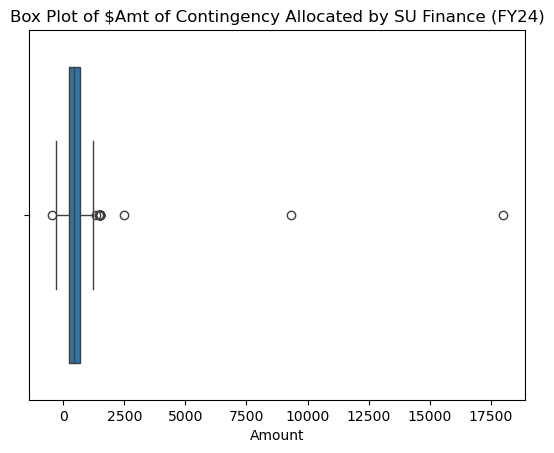

In [171]:
sns.boxplot(Contingency_2324, x='Amount')
plt.title('Box Plot of $Amt of Contingency Allocated by SU Finance (FY24)')

Text(0.5, 1.0, '[ADJUSTED] Box Plot of $Amt of Contingency Allocated by SU Finance (FY24)')

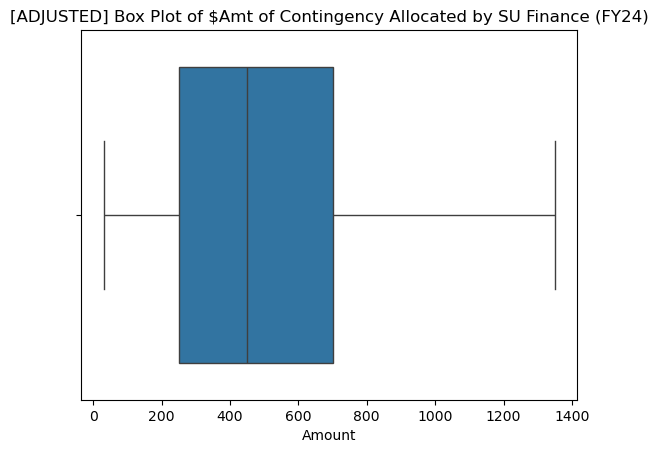

In [172]:
#removing outliers and negative values
sns.boxplot(Contingency_2324[Contingency_2324['Amount'] > 0], x='Amount', showfliers=False)
plt.title('[ADJUSTED] Box Plot of $Amt of Contingency Allocated by SU Finance (FY24)')

Text(0.5, 1.0, 'Density Histogram of %Amt of Contingency Allocated by SU Finance (FY24)')

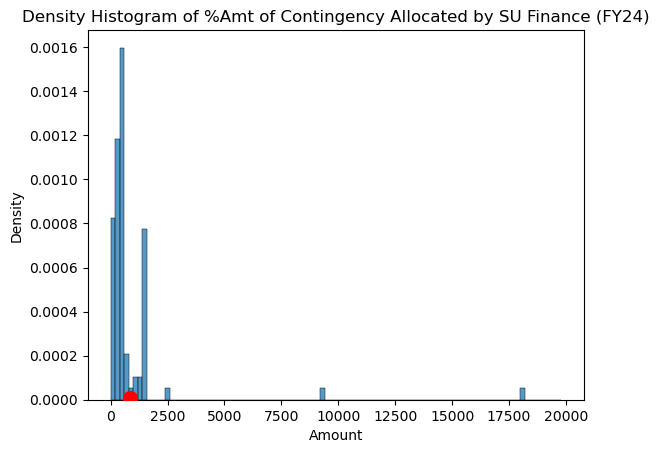

In [173]:
sns.histplot(Contingency_2324, x='Amount', stat='density', bins=np.arange(0, 20000, 200))
plt.scatter(np.average(Contingency_2324['Amount']), 0.00001, color='red', s=100, label=f'Average: {np.average(Contingency_2324["Amount"])}', zorder=5)
plt.title('Density Histogram of %Amt of Contingency Allocated by SU Finance (FY24)')

Text(0.5, 1.0, '[ADJUSTED]Density Histogram of %Amt of Contingency Allocated by SU Finance (FY24)')

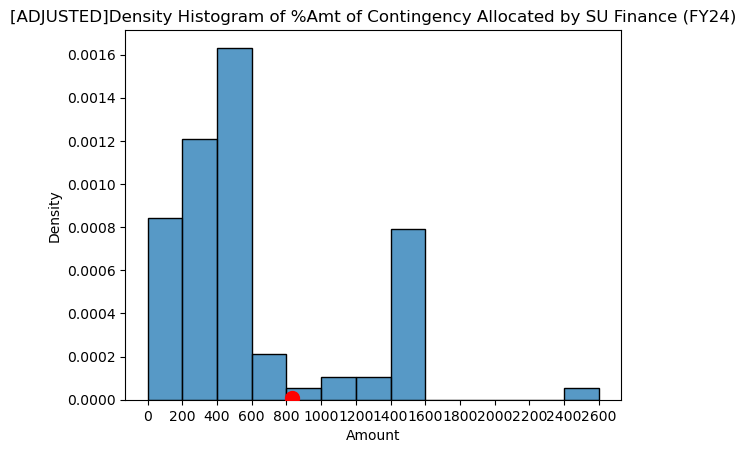

In [174]:
sns.histplot(Contingency_2324, x='Amount', stat='density', bins=np.arange(0, 2800, 200)).set_xticks(np.arange(0, 2800, 200))
plt.scatter(np.average(Contingency_2324['Amount']), 0.00001, color='red', s=100, label=f'Average: {np.average(Contingency_2324["Amount"])}', zorder=5)
plt.title('[ADJUSTED]Density Histogram of %Amt of Contingency Allocated by SU Finance (FY24)')

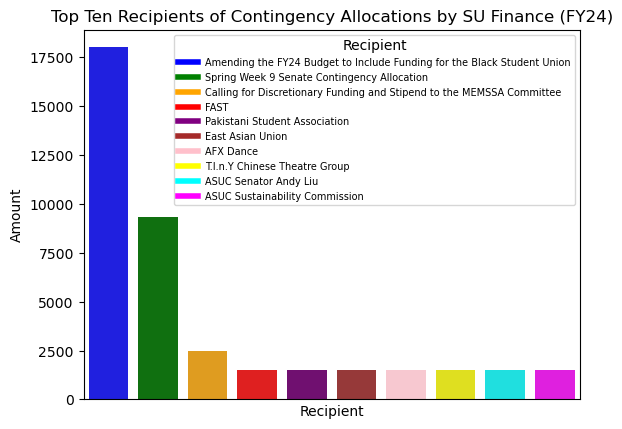

In [175]:
def top_ten_bar(df, col, x_input, y_input, title):
    assert len(df) == 10, 'Inputted df does not have ten rows'
    
    # Make a copy of the column for hue
    df[col + ' copy'] = df[col]

    # Define custom palette with color assignments for the top 10 unique recipients
    custom_palette = {df[col].iloc[i]: color for i, color in enumerate(
        ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink', 'yellow', 'cyan', 'magenta']
    )}

    # Create the barplot with hue and custom colors
    sns.barplot(data=df, x=x_input, y=y_input, hue=col + ' copy', palette=custom_palette)

    # Get the unique recipients and prepare labels and handles
    unique_recipients = df[col].unique()
    labels = list(unique_recipients)
    handles = [mlines.Line2D([0], [0], color=custom_palette[rec], lw=4) for rec in labels]

    # Customize the legend
    plt.legend(title=col, labels=labels,
               loc='upper right', prop={'size': 7},
               handles=handles)

    # Remove x-axis labels
    plt.xticks([])

    # Title
    plt.title(title)

    # Show the plot
    plt.show()

# Some pre-cleaning
ContinFY24_Top_Ten = Contingency_2324.sort_values('Amount', ascending=False).iloc[0:10]
ContinFY24_Top_Ten.iloc[1, len(ContinFY24_Top_Ten.columns) - 1] = 'Spring Week 9 Senate Contingency Allocation'

# Call the function to generate the plot
top_ten_bar(ContinFY24_Top_Ten, 'Recipient', 'Recipient', 'Amount', 'Top Ten Recipients of Contingency Allocations by SU Finance (FY24)')

In [176]:
ContinFY24_Top_Ten

,Account Name,Account Description,Transaction Reference #,Date,Reconciled,Created By,Payee/Source First Name,Payee/Source Last Name,Originator Account Name,From Request - Account Name,...,Memo,Category,Type,Transaction Method,Amount,Ending Balance After,Available Balance After,Entry Num,Recipient,Recipient copy
471,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1840244,2023-10-31,No,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,SR 23/24-002 Amending the FY24 Budget to Inclu...,Transfer between Accounts,NaN,Payment,18000.00,0.0,67459.55,31,Amending the FY24 Budget to Include Funding fo...,Amending the FY24 Budget to Include Funding fo...
520,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1850270,2024-03-27,Yes,NaN,Robert Jittrikawiphol,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,SR 23/24 Spring Week 9 Senate Contingency Allo...,Transfer between Accounts,Direct Deposit ACH/Stripe,Payment,9325.14,0.0,31703.13,80,Spring Week 9 Senate Contingency Allocation,Spring Week 9 Senate Contingency Allocation
490,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1847049,2024-02-06,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,SR 23/24-008 Calling for Discretionary Funding...,Transfer between Accounts,NaN,Payment,2500.00,0.0,54057.07,50,Calling for Discretionary Funding and Stipend ...,Calling for Discretionary Funding and Stipend ...
458,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1839096,2023-10-19,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,FR 23/24 F08 - FAST,Transfer between Accounts,NaN,Payment,1500.00,0.0,90903.20,18,FAST,FAST
535,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1851932,2024-04-23,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,FR 23/24 S12 - Pakistani Student Association,Transfer between Accounts,NaN,Payment,1500.00,0.0,21437.85,95,Pakistani Student Association,Pakistani Student Association
534,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1851108,2024-04-13,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,FR 23/24 S11 - East Asian Union,Transfer between Accounts,NaN,Payment,1500.00,0.0,22937.85,94,East Asian Union,East Asian Union
528,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1851102,2024-04-13,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,FR 23/24 S11 - AFX Dance,Transfer between Accounts,NaN,Payment,1500.00,0.0,27215.17,88,AFX Dance,AFX Dance
521,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1851095,2024-04-13,Yes,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,FR 23/24 S10 - T.I.n.Y Chinese Theatre Group,Transfer between Accounts,NaN,Payment,1500.00,0.0,30203.13,81,T.I.n.Y Chinese Theatre Group,T.I.n.Y Chinese Theatre Group
507,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1848514,2024-03-07,No,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,FR 23/24 S07 - ASUC Senator Andy Liu,Transfer between Accounts,NaN,Payment,1500.00,0.0,44787.33,67,ASUC Senator Andy Liu,ASUC Senator Andy Liu
506,3-40-100220-00000-ASUCFunds-SCF,ASUC/GA Student Fee Funding,1848513,2024-03-07,No,Henry F Isselbacher,Transfer from '3-40-100220-00000-ASUCFunds-SCF...,NaN,3-40-100220-00000-ASUCFunds-SCF,NaN,...,FR 23/24 S07 - ASUC Sustainability Commission,Transfer between Accounts,NaN,Payment,1500.00,0.0,46287.33,66,ASUC Sustainability Commission,ASUC Sustainability Commission


In [177]:
balance_fig = px.line(Contingency_2324, x="Date", y="Available Balance After", title='SU Contingency Funding Total Balance over Time FY24')
balance_fig.show()

In [178]:
allocation_amounts = Contingency_2324.groupby('Date')['Amount'].agg('sum').reset_index()
allocation_fig = px.line(allocation_amounts, x="Date", y="Amount", title='SU Contingency Funding Total Balance over Time FY24')
allocation_fig.show()

In [179]:
allocation_amounts['Date']

0    2023-09-21
1    2023-09-28
2    2023-09-29
3    2023-10-06
4    2023-10-19
5    2023-10-31
6    2023-11-06
7    2023-11-11
8    2023-11-17
9    2023-12-04
10   2024-01-25
11   2024-02-01
12   2024-02-06
13   2024-02-08
14   2024-02-15
15   2024-03-01
16   2024-03-07
17   2024-03-15
18   2024-03-27
19   2024-04-13
20   2024-04-23
21   2024-04-28
Name: Date, dtype: datetime64[ns]

### Ficomm Agenda Data: Analysis

In [180]:
FicommFY24_approved['Amount Allocated'].describe()

count      95.000000
mean      581.400000
std       458.745825
min        32.000000
25%       251.000000
50%       470.000000
75%       656.000000
max      1500.000000
Name: Amount Allocated, dtype: float64

In [181]:
np.sum(FicommFY24_approved['Amount Allocated'])

55233

Text(0.5, 1.0, 'Box Plot of $Amt of Contingency Allocated by Ficomm (FY24)')

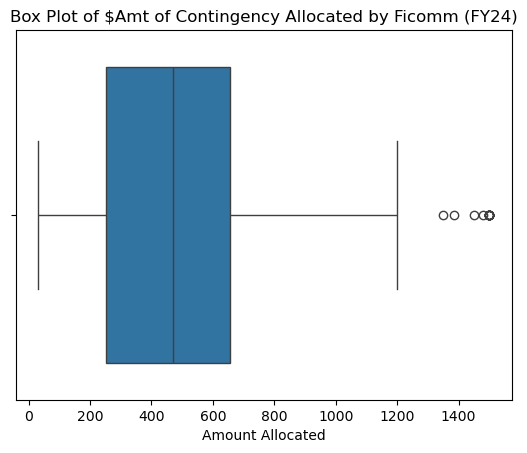

In [182]:
sns.boxplot(FicommFY24_approved, x='Amount Allocated')
plt.title('Box Plot of $Amt of Contingency Allocated by Ficomm (FY24)')

Text(0.5, 1.0, 'Density Histogram of %Amt of Contingency Allocated by Ficomm (FY24)')

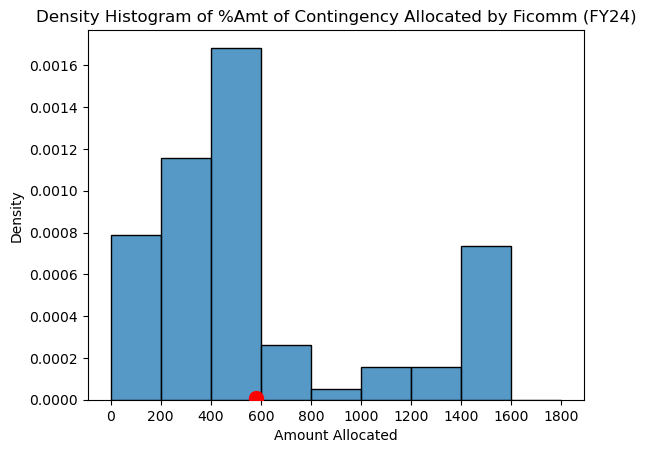

In [183]:
sns.histplot(FicommFY24_approved, x='Amount Allocated', stat='density', bins=np.arange(0, 1900, 200)).set_xticks(np.arange(0, 1900, 200))
plt.scatter(np.average(FicommFY24_approved['Amount Allocated']), 0.00001, color='red', s=100, label=f'Average: {np.average(FicommFY24_approved["Amount Allocated"])}', zorder=5)
plt.title('Density Histogram of %Amt of Contingency Allocated by Ficomm (FY24)')

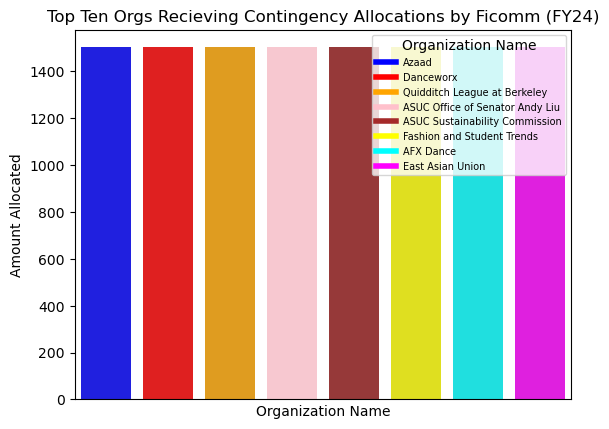

In [184]:
#cleaning to get top ten
FicommFY24_Top_Ten = FicommFY24_approved.sort_values('Amount Allocated', ascending=False).iloc[0:10]
top_ten_bar(FicommFY24_Top_Ten, 'Organization Name', 'Organization Name', 'Amount Allocated', 'Top Ten Orgs Recieving Contingency Allocations by Ficomm (FY24)')

In [185]:
FicommFY24_Top_Ten_Counts = FicommFY24_approved[['Organization Name', 'Amount Allocated']].groupby('Amount Allocated').count().sort_index(ascending=False).iloc[0:10]
FicommFY24_Top_Ten_Counts

,Organization Name
Amount Allocated,
1500,12
1478,1
1450,1
1386,1
1350,1
1200,1
1063,1
1000,2
880,1


### Distributions and Statistics by Club Type
Because of the relatively limited state of data collection and record keeping, there are limitations on the number of variables that can reveal interesting trends and relationships. Club type however, is one of those varibles that we do realiably have information on and is interesting to examine. 

In [186]:
print(f'{len(FicommFY24_approved[FicommFY24_approved["ASUC"]=="ASUC"])} applications from ASUC orgs were approved for alloction')
print(f'{len(FicommFY24_approved[FicommFY24_approved["ASUC"]=="Non-ASUC"])} applications from Non-ASUC orgs were approved for alloction')
print(f'Average $amt allocated to ASUC Orgs: {np.average(FicommFY24_approved[FicommFY24_approved["ASUC"]=="ASUC"]["Amount Allocated"])}')
print(f'Average $amt allocated to Non-ASUC Orgs: {np.average(FicommFY24_approved[FicommFY24_approved["ASUC"]=="Non-ASUC"]["Amount Allocated"])}')

30 applications from ASUC orgs were approved for alloction
65 applications from Non-ASUC orgs were approved for alloction
Average $amt allocated to ASUC Orgs: 669.9666666666667
Average $amt allocated to Non-ASUC Orgs: 540.5230769230769


Text(0.5, 1.0, 'Box Plot of $Amt of Contingency Allocated ASUC vs Non-ASUC by Ficomm (FY24)')

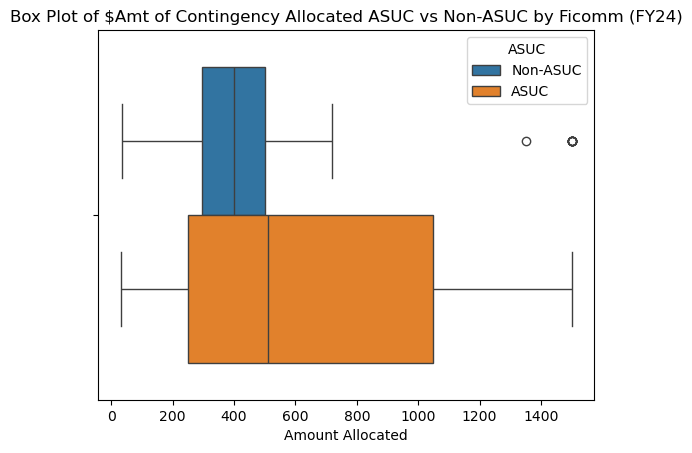

In [187]:
sns.boxplot(FicommFY24_approved, x='Amount Allocated', hue='ASUC')
plt.title('Box Plot of $Amt of Contingency Allocated ASUC vs Non-ASUC by Ficomm (FY24)')

Text(0.5, 1.0, '%Amt of Contingency Allocated by ASUC vs Non-ASUC by Ficomm (FY24)')

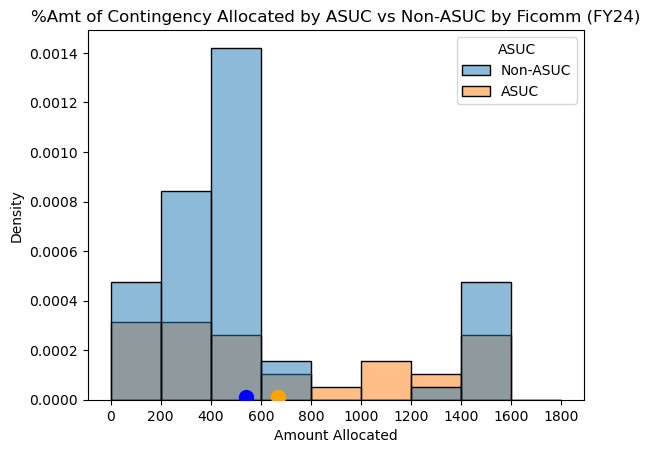

In [188]:
sns.histplot(FicommFY24_approved, x='Amount Allocated', stat='density', bins=np.arange(0, 1900, 200), hue='ASUC').set_xticks(np.arange(0, 1900, 200))

plt.scatter(np.average(FicommFY24_approved[FicommFY24_approved['ASUC'] == 'ASUC']['Amount Allocated']), 0.00001, color='orange', s=100, label=f'Average: {np.average(FicommFY24_approved["Amount Allocated"])}', zorder=5)
plt.scatter(np.average(FicommFY24_approved[FicommFY24_approved['ASUC'] == 'Non-ASUC']['Amount Allocated']), 0.00001, color='blue', s=100, label=f'Average: {np.average(FicommFY24_approved["Amount Allocated"])}', zorder=5)

plt.title('%Amt of Contingency Allocated by ASUC vs Non-ASUC by Ficomm (FY24)')

In [189]:
#PCA Analysis for ASUC vs non-ASUC?


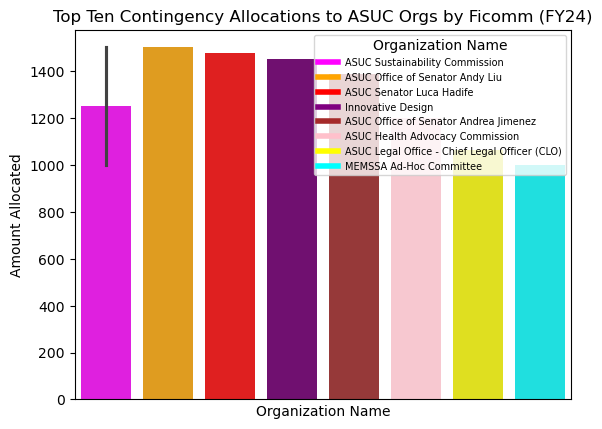

In [190]:
FicommFY24_ASUC_Top_Ten = FicommFY24_approved[FicommFY24_approved['ASUC'] == 'ASUC'].sort_values('Amount Allocated', ascending=False).iloc[0:10]
top_ten_bar(FicommFY24_ASUC_Top_Ten, 'Organization Name', 'Organization Name', 'Amount Allocated', 'Top Ten Contingency Allocations to ASUC Orgs by Ficomm (FY24)')

In [191]:
FicommFY24_ASUC_Top_Ten

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active,Ficomm Meeting Date,Ficomm Decision,Amount Allocated,Meeting Number,FY Year,ASUC,Organization Name copy
54,nan,ASUC Sustainability Commission,NaN,NaN,ASUC: Commission,NaN,2023-2024,8.0,1.0,2024-03-04,Approved,1500,18,FY24,ASUC,ASUC Sustainability Commission
39,nan,ASUC Office of Senator Andy Liu,NaN,NaN,ASUC: Senator,NaN,2023-2024,8.0,1.0,2024-01-29,Approved,1500,14,FY24,ASUC,ASUC Office of Senator Andy Liu
55,nan,ASUC Office of Senator Andy Liu,NaN,NaN,ASUC: Senator,NaN,2023-2024,8.0,1.0,2024-03-04,Approved,1500,18,FY24,ASUC,ASUC Office of Senator Andy Liu
93,nan,ASUC Senator Luca Hadife,NaN,NaN,ASUC: Senator,NaN,2023-2024,8.0,1.0,2024-04-22,Approved,1478,24,FY24,ASUC,ASUC Senator Luca Hadife
91,nan,Innovative Design,NaN,NaN,ASUC: Chartered,NaN,2023-2024,8.0,1.0,2024-04-15,Approved,1450,23,FY24,ASUC,Innovative Design
72,nan,ASUC Office of Senator Andrea Jimenez,NaN,NaN,ASUC: Senator,NaN,2023-2024,8.0,1.0,2024-03-18,Approved,1386,20,FY24,ASUC,ASUC Office of Senator Andrea Jimenez
49,nan,ASUC Health Advocacy Commission,NaN,NaN,ASUC: Commission,NaN,2023-2024,8.0,1.0,2024-02-12,Approved,1200,16,FY24,ASUC,ASUC Health Advocacy Commission
73,nan,ASUC Legal Office - Chief Legal Officer (CLO),NaN,NaN,ASUC: Appointed,NaN,2023-2024,8.0,1.0,2024-03-18,Approved,1063,20,FY24,ASUC,ASUC Legal Office - Chief Legal Officer (CLO)
13,nan,MEMSSA Ad-Hoc Committee,NaN,NaN,ASUC: Special,NaN,2023-2024,8.0,1.0,2023-10-09,Approved,1000,6,FY24,ASUC,MEMSSA Ad-Hoc Committee
65,nan,ASUC Sustainability Commission,NaN,NaN,ASUC: Commission,NaN,2023-2024,8.0,1.0,2024-03-11,Approved,1000,19,FY24,ASUC,ASUC Sustainability Commission


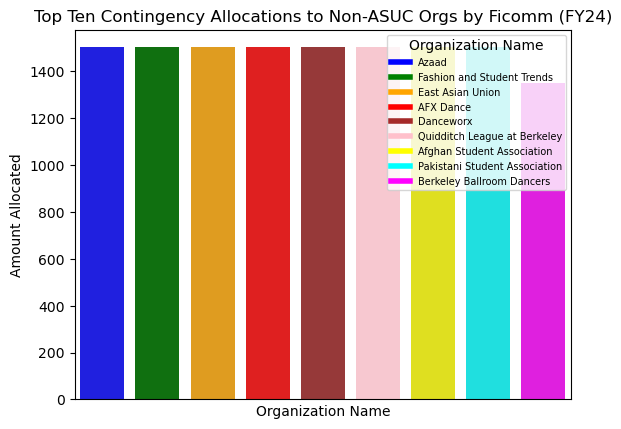

In [192]:
FicommFY24_NonASUC_Top_Ten = FicommFY24_approved[FicommFY24_approved['ASUC'] == 'Non-ASUC'].sort_values('Amount Allocated', ascending=False).iloc[0:10]
top_ten_bar(FicommFY24_NonASUC_Top_Ten, 'Organization Name', 'Organization Name', 'Amount Allocated', 'Top Ten Contingency Allocations to Non-ASUC Orgs by Ficomm (FY24)')

In [193]:
FicommFY24_NonASUC_Top_Ten

,Org ID,Organization Name,Org Type,Callink Page,OASIS RSO Designation,OASIS Center Advisor,Year,Year Rank,Active,Ficomm Meeting Date,Ficomm Decision,Amount Allocated,Meeting Number,FY Year,ASUC,Organization Name copy
0,91708,Azaad,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2023-09-18,Approved,1500,3,FY24,Non-ASUC,Azaad
11,45950,Fashion and Student Trends,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2023-10-09,Approved,1500,6,FY24,Non-ASUC,Fashion and Student Trends
89,46534,East Asian Union,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Cultural & Identity/International RSO,Melissa Landeros at melissalanderos@berkeley.edu,2023-2024,8.0,1.0,2024-04-08,Approved,1500,22,FY24,Non-ASUC,East Asian Union
83,91705,AFX Dance,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2024-04-08,Approved,1500,22,FY24,Non-ASUC,AFX Dance
70,45935,Danceworx,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2024-03-18,Approved,1500,20,FY24,Non-ASUC,Danceworx
36,45935,Danceworx,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2023-11-27,Approved,1500,12,FY24,Non-ASUC,Danceworx
32,46692,Quidditch League at Berkeley,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Recreational RSO,Millicent Morris-Chaney at millicen@berkeley.edu,2023-2024,8.0,1.0,2023-11-06,Approved,1500,10,FY24,Non-ASUC,Quidditch League at Berkeley
29,nan,Afghan Student Association,NaN,NaN,Cultural & Identity/International RSO,NaN,2023-2024,8.0,1.0,2023-11-06,Approved,1500,10,FY24,Non-ASUC,Afghan Student Association
90,nan,Pakistani Student Association,NaN,NaN,Cultural & Identity/International RSO,NaN,2023-2024,8.0,1.0,2024-04-15,Approved,1500,23,FY24,Non-ASUC,Pakistani Student Association
86,45882,Berkeley Ballroom Dancers,Registered Student Organizations,https://callink.berkeley.edu/actioncenter/orga...,Performing Arts RSO,Emily Enriquez at emilyenriquez@berkeley.edu,2023-2024,8.0,1.0,2024-04-08,Approved,1350,22,FY24,Non-ASUC,Berkeley Ballroom Dancers


Now let's look more closely at exact organization types.

In [194]:
def category_updater_full(df1, df2, match_on, df1_overwrite, df2_overwrite):
    """
    Updates the 'OASIS RSO Designation' column in df1 based on a mapping from df2.
    
    The function performs the following steps:
    1. Creates a copy of the first DataFrame (df1).
    2. Maps values from df2['Organization Name_latest'] to df2['OASIS RSO Designation_latest'].
    3. Updates the 'OASIS RSO Designation' in df1 based on this mapping.
    4. Fills any remaining missing ('NaN') values in the 'OASIS RSO Designation' column 
       with the corresponding values from the original df1['OASIS RSO Designation'].
    5. Returns the updated DataFrame and the indices of rows where the 'OASIS RSO Designation' was successfully updated.

    Args:
        df1 (pd.DataFrame): The original DataFrame to update, containing the 'Organization Name' and 'OASIS RSO Designation' columns.
        df2 (pd.DataFrame): The DataFrame containing the updated mappings from 'Organization Name_latest' to 'OASIS RSO Designation_latest'.
        
    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The updated DataFrame with the 'OASIS RSO Designation' column updated.
            - pd.Index: The indices of the rows where the 'OASIS RSO Designation' column was successfully updated (i.e., the values were not NaN).
    """
    cop = df1.copy()
    update_map = dict(zip(df2[match_on], df2[df2_overwrite]))
    cop[df1_overwrite] = cop[match_on].map(update_map).fillna(df1[df1_overwrite])
    
    indices = cop[cop[df1_overwrite] != df1[df1_overwrite]].index #indices of all non-NaN values (the values we changed)
    print(f'{len(indices)} values updated')
    return cop, indices

In [195]:
#must account for category migration and update to FY25 categories: recall that `cop2324` is just OASIS Dataset of active clubs from FY24 with updated categories
FicommFY24_approved_updated, _ = category_updater_full(FicommFY24_approved, cop2324, 'Org ID', 'OASIS RSO Designation', 'OASIS RSO Designation')

13 values updated


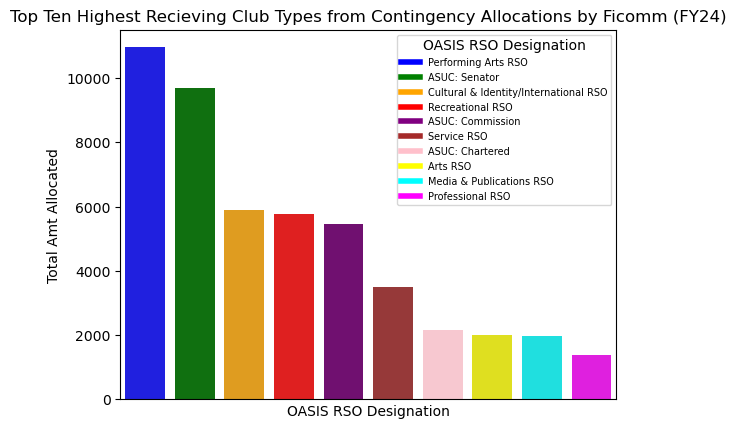

In [196]:
FicommFY24_Top_Categories = FicommFY24_approved_updated.groupby('OASIS RSO Designation')[['Amount Allocated']].sum().rename(columns={'Amount Allocated' : 'Total Amt Allocated'}).sort_values('Total Amt Allocated', ascending=False)
FicommFY24_Top_Ten_Categories = FicommFY24_Top_Categories.iloc[0:10]
top_ten_bar(FicommFY24_Top_Ten_Categories.reset_index(), 'OASIS RSO Designation', 'OASIS RSO Designation', 'Total Amt Allocated', 'Top Ten Highest Recieving Club Types from Contingency Allocations by Ficomm (FY24)')

In [197]:
FicommFY24_Top_Categories

,Total Amt Allocated
OASIS RSO Designation,
Performing Arts RSO,10949
ASUC: Senator,9676
Cultural & Identity/International RSO,5900
Recreational RSO,5753
ASUC: Commission,5450
Service RSO,3513
ASUC: Chartered,2150
Arts RSO,2000
Media & Publications RSO,1986


In [198]:
def Club_Type_Reporter(approved_ficomm_df, club_type, base_color, fund_name, containing=False, specific_name=None):
    """
    Generates a report and visualizations for a specific club type's allocations from Ficomm-approved data.

    Args:
        approved_ficomm_df (pd.DataFrame): A cleaned DataFrame containing only approved organizations.
        club_type (str): The club type to filter for (e.g., 'Cultural & Identity/International RSO').
        base_color (str): The base color to use in visualizations.
        fund_name (str): The name of the funding being analyzed (e.g., 'Contingency Fund').
        containing (bool): If True, filters using substring matching; otherwise, filters for exact matches.

    Returns:
        None: Displays statistical descriptions and visualizations for the specified club type's allocations.
    """
    # Extract fiscal year
    year = approved_ficomm_df['FY Year'].iloc[0]

    # Filter data based on the club type
    if not containing:
        cleaned = approved_ficomm_df[approved_ficomm_df['OASIS RSO Designation'] == club_type]
    else:
        cleaned = approved_ficomm_df[
            approved_ficomm_df['OASIS RSO Designation'].str.contains(club_type, na=False)
        ]

    # Print summary statistics
    if specific_name is not None:
        print(f"""
        Report on {specific_name} Allocations of {fund_name}
        ===========================================
        {cleaned['Amount Allocated'].describe()}
        """)

        # Boxplot
        sns.boxplot(data=cleaned, x='Amount Allocated', color=base_color)
        plt.title(f'Box Plot of ${fund_name} Allocations to {specific_name} by Ficomm ({year})')
        plt.show()

        # Histogram with density plot
        sns.histplot(
            data=cleaned,
            x='Amount Allocated',
            color=base_color,
            stat='density',
            bins=np.arange(0, 1900, 200)
        ).set_xticks(np.arange(0, 1900, 200))

        # Scatter plot to highlight the average
        avg = np.average(cleaned['Amount Allocated'])
        plt.scatter(
            avg, 0.00001, color='black', s=100, 
            label=f'Average: ${avg:.2f}', zorder=5
        )
        plt.legend()
        plt.title(f'Histogram of ${fund_name} Allocations to {specific_name} by Ficomm ({year})')
        plt.show()

    else: 
        print(f"""
        Report on {club_type} Allocations of {fund_name}
        ===========================================
        {cleaned['Amount Allocated'].describe()}
        """)

        # Boxplot
        sns.boxplot(data=cleaned, x='Amount Allocated', color=base_color)
        plt.title(f'Box Plot of ${fund_name} Allocations to {club_type} by Ficomm ({year})')
        plt.show()

        # Histogram with density plot
        sns.histplot(
            data=cleaned,
            x='Amount Allocated',
            color=base_color,
            stat='density',
            bins=np.arange(0, 1900, 200)
        ).set_xticks(np.arange(0, 1900, 200))

        # Scatter plot to highlight the average
        avg = np.average(cleaned['Amount Allocated'])
        plt.scatter(
            avg, 0.00001, color='black', s=100, 
            label=f'Average: ${avg:.2f}', zorder=5
        )
        plt.legend()
        plt.title(f'Histogram of ${fund_name} Allocations to {club_type} by Ficomm ({year})')
        plt.show()


        Report on Performing RSOs Allocations of Contingency
        count      14.000000
mean      746.357143
std       572.004520
min        58.000000
25%       355.750000
50%       450.000000
75%      1462.500000
max      1500.000000
Name: Amount Allocated, dtype: float64
        


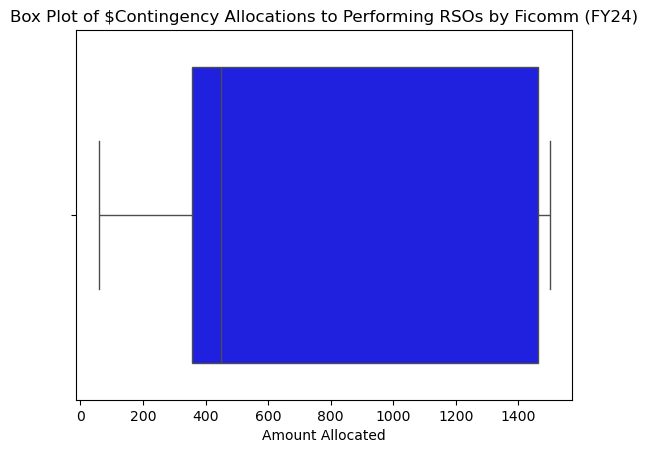

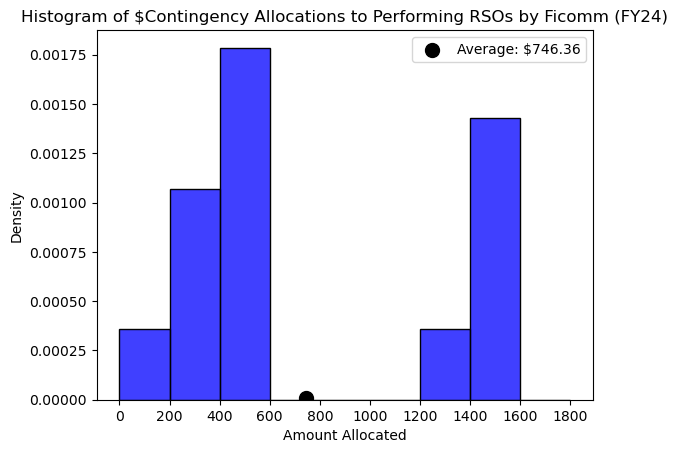

In [199]:
Club_Type_Reporter(FicommFY24_approved, 'Performing Arts RSO', 'blue', 'Contingency', specific_name='Performing RSOs')


        Report on ASUC Senators Allocations of Contingency
        count      18.000000
mean      537.555556
std       533.382240
min        32.000000
25%       165.000000
50%       277.000000
75%       555.250000
max      1500.000000
Name: Amount Allocated, dtype: float64
        


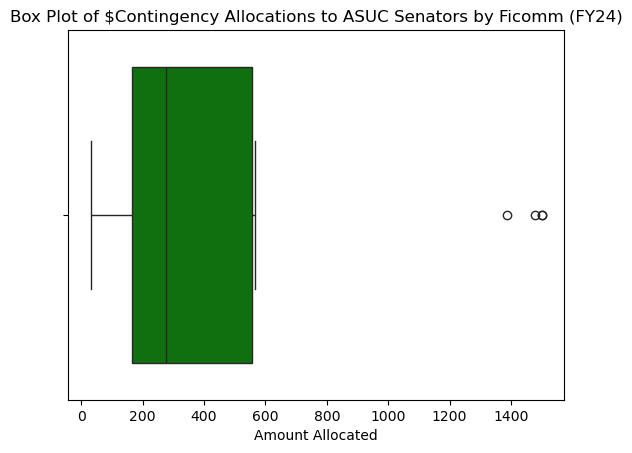

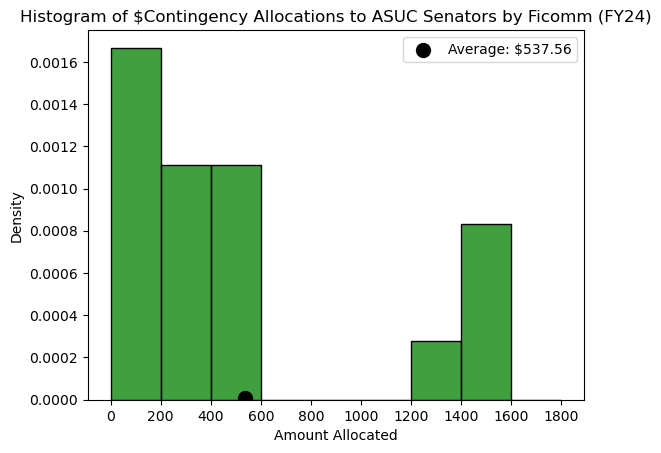

In [200]:
Club_Type_Reporter(FicommFY24_approved, 'ASUC: Senator', 'green', 'Contingency', specific_name='ASUC Senators')


        Report on Cultural RSOs Allocations of Contingency
        count       6.000000
mean      983.333333
std       567.156651
min       400.000000
25%       500.000000
50%      1000.000000
75%      1500.000000
max      1500.000000
Name: Amount Allocated, dtype: float64
        


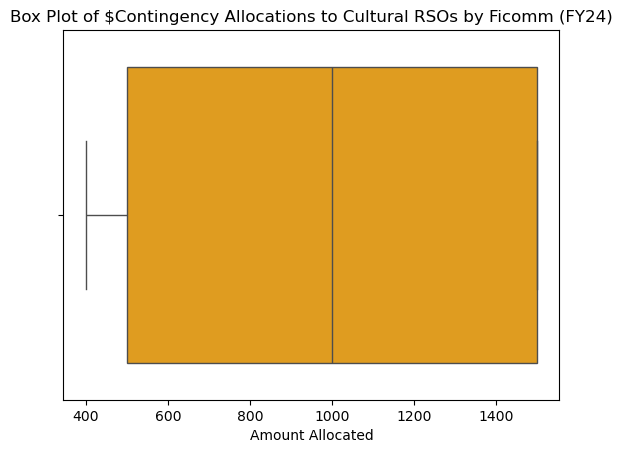

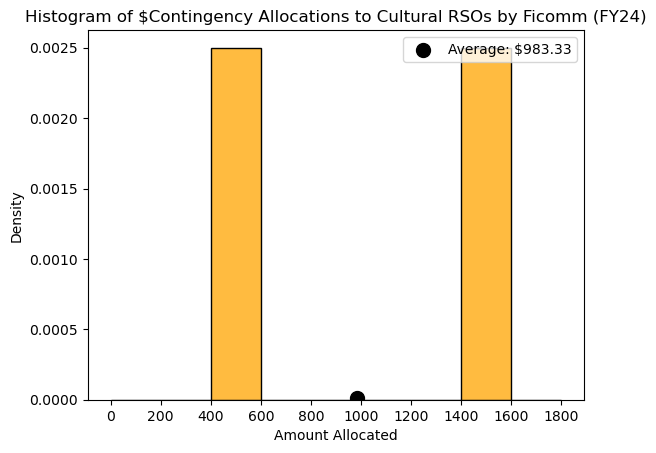

In [201]:
Club_Type_Reporter(FicommFY24_approved, 'Cultural & Identity/International RSO', 'orange', 'Contingency', specific_name='Cultural RSOs')

### Decline Rates

In [202]:
def Rates_Analyzer(full_ficomm_df):
      """
      Analyzes decline rates for funding decisions in an ASUC Ficomm dataset.

      This function calculates and prints the decline rates for various subsets 
      of organizations based on their ASUC designation or RSO category. The decline
      rate is defined as the proportion of funding requests that were not "Approved."

      Subsets analyzed include:
      - All organizations (overall decline rate).
      - ASUC-affiliated organizations.
      - Non-ASUC organizations.
      - Performing Arts RSOs.
      - ASUC Senators.
      - Cultural & Identity/International RSOs.

      Args:
            full_ficomm_df (pd.DataFrame): A DataFrame containing the Ficomm funding data. 
                                          Expected columns include:
                                          - 'ASUC': Indicates if the organization is ASUC or Non-ASUC.
                                          - 'OASIS RSO Designation': Specifies the RSO category.
                                          - 'Ficomm Decision': Records the decision for funding (e.g., "Approved" or other statuses).

      Returns:
            None: This function prints the calculated decline rates for the specified subsets.

      Example:
            >>> Rates_Analyzer(ficomm_df)
            Overall decline rate: 0.35
            Decline rate of ASUC orgs: 0.20
            Decline rate of Non-ASUC orgs: 0.50
            Decline rate of Performing Arts RSOs: 0.40
            Decline rate of ASUC Senators: 0.10
            Decline rate of Cultural RSOs: 0.30
      """
      
      ASUC_only = full_ficomm_df[full_ficomm_df['ASUC'] == 'ASUC']
      Non_ASUC_only = full_ficomm_df[full_ficomm_df['ASUC'] == 'Non-ASUC']
      Perf_Rates = full_ficomm_df[full_ficomm_df['OASIS RSO Designation'] == 'Performing Arts RSO']
      Sen_Rates = full_ficomm_df[full_ficomm_df['OASIS RSO Designation'] == 'ASUC: Senator']
      Cult_Rates = full_ficomm_df[full_ficomm_df['OASIS RSO Designation'] == 'Cultural & Identity/International RSO']

      print(f"""
      Overall decline rate: {sum(full_ficomm_df["Ficomm Decision"] != "Approved")/len(full_ficomm_df)}
      Decline rate of ASUC orgs: {sum(ASUC_only["Ficomm Decision"] != "Approved")/len(ASUC_only)}
      Decline rate of Non-ASUC orgs: {sum(Non_ASUC_only["Ficomm Decision"] != "Approved")/len(Non_ASUC_only)}
      Decline rate of Performing Arts RSOs: {sum(Perf_Rates["Ficomm Decision"] != "Approved")/len(Perf_Rates)}
      Decline rate of ASUC Senators: {sum(Sen_Rates["Ficomm Decision"] != "Approved")/len(Sen_Rates)}
      Decline rate of Cultural RSOs: {sum(Cult_Rates["Ficomm Decision"] != "Approved")/len(Cult_Rates)}
      """)

In [203]:
Rates_Analyzer(FicommFY24_full)


      Overall decline rate: 0.3708609271523179
      Decline rate of ASUC orgs: 0.2682926829268293
      Decline rate of Non-ASUC orgs: 0.4090909090909091
      Decline rate of Performing Arts RSOs: 0.3333333333333333
      Decline rate of ASUC Senators: 0.09523809523809523
      Decline rate of Cultural RSOs: 0.3333333333333333
      


# Expected Cumulative Difference
### A Key Performance Indicator for Financial Health
---

The Expected Cumulative Difference (ECD) metric was developed to address a central question in measuring the financial health of ASUC Finance Committee's Contingency Funding allocation decisions

**"How far off is the committee from where it is 'supposed' to be at any given meeting?"**

This question stems from the need to ensure financial health by maintaining consistent spending patterns throughout the academic year and potentially even across academic years as senators on the ASUC Finance committee get swapped out with each election cycle. The ECD metric aims to quantify deviations from an expected spending trajectory, enabling the committee to monitor progress and identify irregularities on a per-meeting basis. 

##### Deriving the Metric

The ECD metric relies on two key components: **"Expected Cumulative"** and **"Difference."**

##### 1. "Expected Cumulative": Where Should Spending Be?

The "expected cumulative" value represents the total amount the committee is expected to have spent by a particular meeting. This value depends on the model of expectation chosen:

- **Algebraic Average ($\bar{c}_n$):** A simple model assumes equal spending across all meetings. For a contingency fund of $(c)$ dollar amount total and $(n)$ total meetings over the course of an academic year, the algebraic average at a given meeting $k$ is:
  $$
  \text{Expected Spending at Meeting } k = \frac{c}{n} \cdot k
  $$

  We will denote the algebraic averge as $\bar{c}_n$.

- **Historical Weighted Average:** This more sophisticated approach uses historical spending patterns to weight certain meetings higher (e.g., earlier meetings typically involve less spending as clubs are still setting up while later meetings involve more bulk spending as club leaders rush to get their applications in before the semester ends).

##### 2. "Difference": How Far Off Is Spending?

The "difference" component measures the deviation between the actual cumulative spending and the expected cumulative spending. There are multiple ways to define this:

- **Non-Absolute Difference:** The raw dollar amount:
  $$
  \text{Difference} = \text{Expected Cumulative} - \text{Actual Cumulative Spending}
  $$

- **Absolute Difference:** The absolute raw dollar amount:
$$
\text{Difference} = \lvert \text{Expected Cumulative} - \text{Actual Cumulative Spending} \rvert
$$

- **Proportional Difference:** The percentage deviation relative to the expected value:
  $$
  \text{Proportional Difference} = \frac{\text{Expected Cumulative} - \text{Actual Cumulative Spending}}{\text{Expected Cumulative}} \cdot 100
  $$

##### Final Definition for Convenience

For practical use, the ECD metric is expressed as the **non-absolute  difference from the algebraic average**. Given a contingency fund $(c)$, total meetings $(n)$, and actual cumulative spending $(S_k)$ by meeting $(k)$, the ECD metric is:

$$
\text{ECD}_k = \left( \frac{c}{n} \cdot k \right) - S_k
$$

Or more concisely: 

$$
\text{ECD}_k = \left( \bar{c}_n \cdot k \right) - S_k
$$

This form allows stakeholders to directly read the absolute dollar difference between expected and actual spending for a given meeting.

By focusing on difference from expected cumulative spending, the ECD metric offers a transparent, flexible framework for financial oversight and quickly gleaning financial health while leaving open room for future refinements or modifications for more specific questions. 

##### Note on Notation

You will realized that while the letters denoting the total dollar amount of the contingency fund $(c)$ and the total number of meetings in a academic year $(n)$ are in lower case whereas the total spending at any given meeting $(S_k)$ is capitalized. This is because the total dollar amount of the contingency fund and the number of meetings in a academic year are held constant whereas the total spending at any given meeting changes from meeting to meeting and thus can be interpretted as a random variable. 

We will not go into speculation about possible probablistic models that could represent the underlying distribution of clubs that come to ficomm for contingency funding money nor will we dwell on possible probabilistic models that define when clubs apply for contingency funding and follow through with every step of the processs in this project. However, this metric is intended to be set up such that it can be easily interpretted in the context of randomization assumptions and probabilistic models being applied to the ASUC Finance Committee's situation. 


### Example: ECDs for FY24

We will first analyze ECD per meeting for using the Ficomm Agenda dataset then ECD per transaction per day using the SU Contingency Dataset.

In [204]:
Total_Allocations_FY24 = pd.DataFrame(FicommFY24_full.groupby('Ficomm Meeting Date')[['Amount Allocated']].apply(lambda x: sum(x[x['Amount Allocated'] > 0]['Amount Allocated']))).rename(columns={0 : 'Amount'})
Total_Allocations_FY24['Meeting Number'] = np.arange(1, len(Total_Allocations_FY24) + 1)
Total_Allocations_FY24 = Total_Allocations_FY24.reset_index().set_index('Meeting Number')
Total_Allocations_FY24

,Ficomm Meeting Date,Amount
Meeting Number,,
1,2023-09-05,0
2,2023-09-11,0
3,2023-09-18,2100
4,2023-09-25,284
5,2023-10-02,3070
6,2023-10-09,3752
7,2023-10-16,2561
8,2023-10-23,882
9,2023-10-30,1977


In [205]:
FY24_ECDs = Total_Allocations_FY24
FY24_ECDs['ECD'] = FY24_ECDs.index.to_series() * (100000 / len(FY24_ECDs)) - FY24_ECDs['Amount'].cumsum()
FY24_ECDs

,Ficomm Meeting Date,Amount,ECD
Meeting Number,,,
1,2023-09-05,0,4166.666667
2,2023-09-11,0,8333.333333
3,2023-09-18,2100,10400.000000
4,2023-09-25,284,14282.666667
5,2023-10-02,3070,15379.333333
6,2023-10-09,3752,15794.000000
7,2023-10-16,2561,17399.666667
8,2023-10-23,882,20684.333333
9,2023-10-30,1977,22874.000000


In [206]:
Total_SU_FY24 = Contingency_2324.groupby('Date')[['Amount']].sum()
Total_SU_FY24['Transaction Number'] = np.arange(1, len(Total_SU_FY24) + 1)
Total_SU_FY24 = Total_SU_FY24.reset_index().set_index('Transaction Number').rename(columns={'Date' : 'SU Finance Transaction Date'})
Total_SU_FY24

,SU Finance Transaction Date,Amount
Transaction Number,,
1,2023-09-21,2100.00
2,2023-09-28,674.80
3,2023-09-29,0.00
4,2023-10-06,4570.00
5,2023-10-19,6313.28
6,2023-10-31,18882.37
7,2023-11-06,1977.52
8,2023-11-11,3850.00
9,2023-11-17,946.00


In [207]:
FY24_SU_ECDs = Total_SU_FY24
FY24_SU_ECDs['ECD'] = FY24_ECDs.index.to_series() * (100000 / len(FY24_SU_ECDs)) - FY24_SU_ECDs['Amount'].cumsum()
FY24_SU_ECDs

,SU Finance Transaction Date,Amount,ECD
Transaction Number,,,
1,2023-09-21,2100.00,2445.454545
2,2023-09-28,674.80,6316.109091
3,2023-09-29,0.00,10861.563636
4,2023-10-06,4570.00,10837.018182
5,2023-10-19,6313.28,9069.192727
6,2023-10-31,18882.37,-5267.722727
7,2023-11-06,1977.52,-2699.788182
8,2023-11-11,3850.00,-2004.333636
9,2023-11-17,946.00,1595.120909


# Conclusion
---

Throught this notebook we have gone over the different datasets and my cleaning process in detail, I hope it was interesting I know I certainly found it interesting. The cleaned datasets are free to be used and you can fine a more robust implementation of most if not all the cleaning pipeline functions in those notebook in my package ASUC-Explore.
 
 Thanks!